In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

In [2]:

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [3]:
# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

In [4]:
# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [9]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [10]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 4000

Testing
Number of Labels: 1311


In [11]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [13]:
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [15]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.4318 - loss: 1.1879 - val_accuracy: 0.6423 - val_loss: 1.0186 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7457 - loss: 0.6528 - val_accuracy: 0.7620 - val_loss: 0.6231 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.8252 - loss: 0.4674 - val_accuracy: 0.8078 - val_loss: 0.5052 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.8723 - loss: 0.3421 - val_accuracy: 0.8696 - val_loss: 0.3873 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9043 - loss: 0.2676 - val_accuracy: 0.8970 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.9207 - loss: 0.2085 - val_accuracy: 0.8886 - val_loss: 0.3749 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - accuracy: 0.9

In [16]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9788 - loss: 0.2987
Test accuracy: 97.2540%


In [17]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       300
           1       0.97      0.93      0.95       306
           2       0.96      0.99      0.98       405
           3       0.99      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



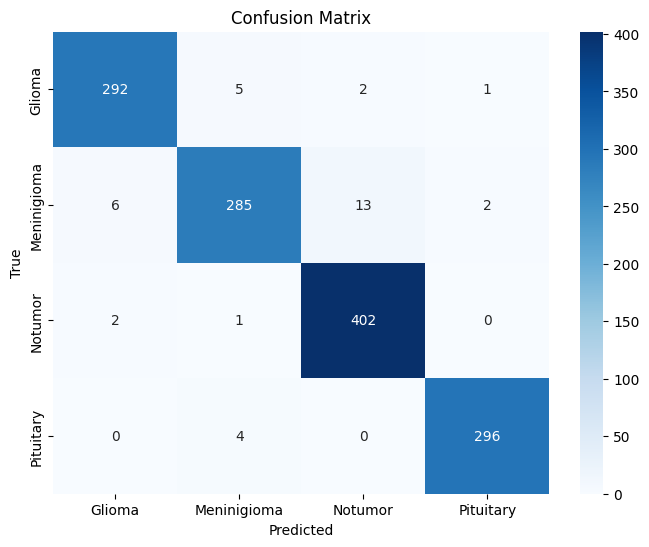

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [19]:
model.save('SSL_70-30.h5')

In [20]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_70-30.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/unlabelled"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.98
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/1712 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


  0%|          | 1/1712 [00:01<37:54,  1.33s/it]

Tr-pi_1149.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1149.jpg to BT100/Training/pituitary/20250330_175357_Tr-pi_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  0%|          | 2/1712 [00:01<17:25,  1.64it/s]

Tr-no_0171.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0171.jpg to BT100/Training/notumor/20250330_175357_Tr-no_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0917.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0917.jpg to BT100/Training/pituitary/20250330_175358_Tr-pi_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  0%|          | 4/1712 [00:01<08:04,  3.52it/s]

Tr-pi_0297.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0297.jpg to BT100/Training/pituitary/20250330_175358_Tr-pi_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0216.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0216.jpg to BT100/Training/notumor/20250330_175358_Tr-me_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 6/1712 [00:01<05:10,  5.49it/s]

Tr-pi_1058.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1058.jpg to BT100/Training/pituitary/20250330_175358_Tr-pi_1058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1217.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1217.jpg to BT100/Training/meningioma/20250330_175358_Tr-me_1217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  0%|          | 8/1712 [00:01<03:51,  7.35it/s]

Tr-pi_1357.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1357.jpg to BT100/Training/pituitary/20250330_175358_Tr-pi_1357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0570.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0570.jpg to BT100/Training/pituitary/20250330_175358_Tr-pi_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 10/1712 [00:02<03:09,  8.97it/s]

Tr-no_1338.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1338.jpg to BT100/Training/notumor/20250330_175358_Tr-no_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0119.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0119.jpg to BT100/Training/glioma/20250330_175358_Tr-gl_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  1%|          | 12/1712 [00:02<02:44, 10.33it/s]

Tr-no_0679.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0679.jpg to BT100/Training/notumor/20250330_175358_Tr-no_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1230.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1230.jpg to BT100/Training/meningioma/20250330_175358_Tr-me_1230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 14/1712 [00:02<02:41, 10.51it/s]

Tr-pi_1389.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1389.jpg to BT100/Training/pituitary/20250330_175358_Tr-pi_1389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-me_0753.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0753.jpg to BT100/Training/meningioma/20250330_175359_Tr-me_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|          | 16/1712 [00:02<03:01,  9.36it/s]

Tr-me_0185.jpg -> Class: meningioma, Confidence: 0.91
Moved low-confidence image Tr-me_0185.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0121.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0121.jpg to BT100/Training/meningioma/20250330_175359_Tr-me_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 18/1712 [00:02<03:17,  8.56it/s]

Tr-me_1181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1181.jpg to BT100/Training/meningioma/20250330_175359_Tr-me_1181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0112.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0112.jpg to BT100/Training/notumor/20250330_175359_Tr-no_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|          | 20/1712 [00:03<03:15,  8.64it/s]

Tr-pi_1143.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1143.jpg to BT100/Training/pituitary/20250330_175359_Tr-pi_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  1%|          | 21/1712 [00:03<03:19,  8.49it/s]

Tr-me_0978.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0978.jpg to BT100/Training/meningioma/20250330_175359_Tr-me_0978.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|▏         | 22/1712 [00:03<03:28,  8.12it/s]

Tr-gl_0928.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0928.jpg to BT100/Training/glioma/20250330_175359_Tr-gl_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0266.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0266.jpg to BT100/Training/glioma/20250330_175400_Tr-gl_0266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  1%|▏         | 24/1712 [00:03<03:11,  8.82it/s]

Tr-no_0380.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0380.jpg to BT100/Training/notumor/20250330_175400_Tr-no_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  1%|▏         | 25/1712 [00:03<03:10,  8.86it/s]

Tr-me_0019.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0019.jpg to BT100/Training/meningioma/20250330_175400_Tr-me_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 26/1712 [00:03<03:17,  8.52it/s]

Tr-me_0701.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0701.jpg to BT100/Training/meningioma/20250330_175400_Tr-me_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 27/1712 [00:03<03:26,  8.15it/s]

Tr-me_1223.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1223.jpg to BT100/Training/meningioma/20250330_175400_Tr-me_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 28/1712 [00:04<03:29,  8.02it/s]

Tr-pi_0067.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0067.jpg to BT100/Training/pituitary/20250330_175400_Tr-pi_0067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 29/1712 [00:04<03:33,  7.88it/s]

Tr-me_0033.jpg -> Class: notumor, Confidence: 0.74
Moved low-confidence image Tr-me_0033.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0306.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0306.jpg to BT100/Training/glioma/20250330_175400_Tr-gl_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 31/1712 [00:04<02:53,  9.68it/s]

Tr-me_1250.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1250.jpg to BT100/Training/meningioma/20250330_175400_Tr-me_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0178.jpg to BT100/Training/notumor/20250330_175400_Tr-no_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 33/1712 [00:04<02:29, 11.26it/s]

Tr-gl_0418.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0418.jpg to BT100/Training/glioma/20250330_175401_Tr-gl_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0233.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0233.jpg to BT100/Training/meningioma/20250330_175401_Tr-me_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0336.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0336.jpg to BT100/Training/pituitary/20250330_175401_Tr-pi_0336.jpg


  2%|▏         | 35/1712 [00:04<02:16, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1457.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1457.jpg to BT100/Training/notumor/20250330_175401_Tr-no_1457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  2%|▏         | 37/1712 [00:04<02:08, 13.01it/s]

Tr-pi_1188.jpg -> Class: pituitary, Confidence: 0.82
Moved low-confidence image Tr-pi_1188.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0785.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0785.jpg to BT100/Training/notumor/20250330_175401_Tr-no_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 39/1712 [00:04<02:03, 13.59it/s]

Tr-me_0254.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0254.jpg to BT100/Training/meningioma/20250330_175401_Tr-me_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0753.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0753.jpg to BT100/Training/pituitary/20250330_175401_Tr-pi_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  2%|▏         | 41/1712 [00:05<02:00, 13.92it/s]

Tr-no_1289.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1289.jpg to BT100/Training/notumor/20250330_175401_Tr-no_1289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1032.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1032.jpg to BT100/Training/meningioma/20250330_175401_Tr-me_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 43/1712 [00:05<01:57, 14.15it/s]

Tr-no_0241.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0241.jpg to BT100/Training/notumor/20250330_175401_Tr-no_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0839.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0839.jpg to BT100/Training/pituitary/20250330_175401_Tr-pi_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  3%|▎         | 45/1712 [00:05<02:01, 13.70it/s]

Tr-me_1279.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1279.jpg to BT100/Training/meningioma/20250330_175401_Tr-me_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1131.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1131.jpg to BT100/Training/meningioma/20250330_175401_Tr-me_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  3%|▎         | 47/1712 [00:05<01:59, 13.91it/s]

Tr-gl_0799.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0799.jpg to BT100/Training/glioma/20250330_175402_Tr-gl_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1034.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1034.jpg to BT100/Training/pituitary/20250330_175402_Tr-pi_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 49/1712 [00:05<01:57, 14.14it/s]

Tr-gl_1131.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1131.jpg to BT100/Training/glioma/20250330_175402_Tr-gl_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0432.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0432.jpg to BT100/Training/pituitary/20250330_175402_Tr-pi_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 51/1712 [00:05<01:59, 13.94it/s]

Tr-me_0839.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0839.jpg to BT100/Training/meningioma/20250330_175402_Tr-me_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0331.jpg -> Class: glioma, Confidence: 0.91
Moved low-confidence image Tr-me_0331.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 53/1712 [00:05<02:09, 12.82it/s]

Tr-pi_0732.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0732.jpg to BT100/Training/pituitary/20250330_175402_Tr-pi_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0341.jpg -> Class: meningioma, Confidence: 0.88
Moved low-confidence image Tr-me_0341.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 55/1712 [00:06<02:05, 13.19it/s]

Tr-pi_0804.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0804.jpg to BT100/Training/pituitary/20250330_175402_Tr-pi_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0364.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0364.jpg to BT100/Training/notumor/20250330_175402_Tr-no_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 57/1712 [00:06<02:02, 13.56it/s]

Tr-me_1205.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1205.jpg to BT100/Training/meningioma/20250330_175402_Tr-me_1205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0841.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0841.jpg to BT100/Training/pituitary/20250330_175402_Tr-pi_0841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 59/1712 [00:06<02:05, 13.13it/s]

Tr-gl_0747.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0747.jpg to BT100/Training/glioma/20250330_175402_Tr-gl_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0377.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0377.jpg to BT100/Training/glioma/20250330_175402_Tr-gl_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 61/1712 [00:06<02:03, 13.42it/s]

Tr-no_1455.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1455.jpg to BT100/Training/notumor/20250330_175403_Tr-no_1455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0363.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0363.jpg to BT100/Training/meningioma/20250330_175403_Tr-me_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▎         | 63/1712 [00:06<02:00, 13.64it/s]

Tr-gl_1147.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1147.jpg to BT100/Training/glioma/20250330_175403_Tr-gl_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0733.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0733.jpg to BT100/Training/glioma/20250330_175403_Tr-gl_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 65/1712 [00:06<01:59, 13.78it/s]

Tr-pi_1185.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1185.jpg to BT100/Training/pituitary/20250330_175403_Tr-pi_1185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0788.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0788.jpg to BT100/Training/pituitary/20250330_175403_Tr-pi_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 67/1712 [00:06<01:57, 14.05it/s]

Tr-no_1211.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1211.jpg to BT100/Training/notumor/20250330_175403_Tr-no_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0613.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0613.jpg to BT100/Training/glioma/20250330_175403_Tr-gl_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▍         | 69/1712 [00:07<01:54, 14.40it/s]

Tr-no_0917.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0917.jpg to BT100/Training/notumor/20250330_175403_Tr-no_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0013.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0013.jpg to BT100/Training/meningioma/20250330_175403_Tr-me_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 71/1712 [00:07<01:53, 14.40it/s]

Tr-pi_1383.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1383.jpg to BT100/Training/pituitary/20250330_175403_Tr-pi_1383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0427.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0427.jpg to BT100/Training/meningioma/20250330_175403_Tr-me_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0841.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0841.jpg to BT100/Training/meningioma/20250330_175403_Tr-me_0841.jpg


  4%|▍         | 73/1712 [00:07<02:05, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0378.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0378.jpg to BT100/Training/pituitary/20250330_175404_Tr-pi_0378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 75/1712 [00:07<02:11, 12.41it/s]

Tr-me_0181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0181.jpg to BT100/Training/meningioma/20250330_175404_Tr-me_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0634.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0634.jpg to BT100/Training/notumor/20250330_175404_Tr-no_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 77/1712 [00:07<02:07, 12.87it/s]

Tr-me_0309.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0309.jpg to BT100/Training/meningioma/20250330_175404_Tr-me_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1245.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1245.jpg to BT100/Training/glioma/20250330_175404_Tr-gl_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▍         | 79/1712 [00:07<02:03, 13.23it/s]

Tr-pi_0513.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0513.jpg to BT100/Training/pituitary/20250330_175404_Tr-pi_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1250.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1250.jpg to BT100/Training/notumor/20250330_175404_Tr-no_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▍         | 81/1712 [00:07<01:58, 13.82it/s]

Tr-me_0424.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0424.jpg to BT100/Training/meningioma/20250330_175404_Tr-me_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0906.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0906.jpg to BT100/Training/notumor/20250330_175404_Tr-no_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▍         | 83/1712 [00:08<01:56, 13.96it/s]

Tr-no_0996.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0996.jpg to BT100/Training/notumor/20250330_175404_Tr-no_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1254.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1254.jpg to BT100/Training/glioma/20250330_175404_Tr-gl_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 85/1712 [00:08<02:06, 12.82it/s]

Tr-me_0686.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0686.jpg to BT100/Training/meningioma/20250330_175404_Tr-me_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1271.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1271.jpg to BT100/Training/pituitary/20250330_175404_Tr-pi_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▌         | 87/1712 [00:08<02:01, 13.36it/s]

Tr-gl_1236.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1236.jpg to BT100/Training/glioma/20250330_175404_Tr-gl_1236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1392.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1392.jpg to BT100/Training/pituitary/20250330_175405_Tr-pi_1392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 89/1712 [00:08<01:57, 13.86it/s]

Tr-gl_1010.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1010.jpg to BT100/Training/glioma/20250330_175405_Tr-gl_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0135.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0135.jpg to BT100/Training/pituitary/20250330_175405_Tr-pi_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 91/1712 [00:08<01:54, 14.20it/s]

Tr-no_1480.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1480.jpg to BT100/Training/notumor/20250330_175405_Tr-no_1480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0049.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0049.jpg to BT100/Training/pituitary/20250330_175405_Tr-pi_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▌         | 93/1712 [00:08<02:05, 12.88it/s]

Tr-no_0192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0192.jpg to BT100/Training/notumor/20250330_175405_Tr-no_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0976.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0976.jpg to BT100/Training/pituitary/20250330_175405_Tr-pi_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 95/1712 [00:09<02:00, 13.45it/s]

Tr-me_0993.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0993.jpg to BT100/Training/meningioma/20250330_175405_Tr-me_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0572.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0572.jpg to BT100/Training/meningioma/20250330_175405_Tr-me_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 97/1712 [00:09<01:56, 13.92it/s]

Tr-me_1098.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1098.jpg to BT100/Training/meningioma/20250330_175405_Tr-me_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0975.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0975.jpg to BT100/Training/notumor/20250330_175405_Tr-no_0975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  6%|▌         | 99/1712 [00:09<02:06, 12.70it/s]

Tr-pi_0317.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0317.jpg to BT100/Training/pituitary/20250330_175405_Tr-pi_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1233.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1233.jpg to BT100/Training/pituitary/20250330_175405_Tr-pi_1233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0384.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0384.jpg to BT100/Training/pituitary/20250330_175406_Tr-pi_0384.jpg


  6%|▌         | 101/1712 [00:09<02:03, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0535.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0535.jpg to BT100/Training/glioma/20250330_175406_Tr-gl_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 103/1712 [00:09<02:09, 12.42it/s]

Tr-pi_1355.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1355.jpg to BT100/Training/pituitary/20250330_175406_Tr-pi_1355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1307.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1307.jpg to BT100/Training/pituitary/20250330_175406_Tr-pi_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▌         | 105/1712 [00:09<02:07, 12.57it/s]

Tr-me_0305.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0305.jpg to BT100/Training/meningioma/20250330_175406_Tr-me_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1287.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1287.jpg to BT100/Training/meningioma/20250330_175406_Tr-me_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▋         | 107/1712 [00:10<02:16, 11.79it/s]

Tr-me_0791.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0791.jpg to BT100/Training/meningioma/20250330_175406_Tr-me_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0284.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0284.jpg to BT100/Training/meningioma/20250330_175406_Tr-me_0284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  6%|▋         | 109/1712 [00:10<02:10, 12.29it/s]

Tr-no_0455.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0455.jpg to BT100/Training/notumor/20250330_175406_Tr-no_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0013.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0013.jpg to BT100/Training/pituitary/20250330_175406_Tr-pi_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▋         | 111/1712 [00:10<02:19, 11.51it/s]

Tr-pi_0091.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0091.jpg to BT100/Training/pituitary/20250330_175406_Tr-pi_0091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0836.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0836.jpg to BT100/Training/meningioma/20250330_175406_Tr-me_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 113/1712 [00:10<02:10, 12.23it/s]

Tr-no_0249.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0249.jpg to BT100/Training/notumor/20250330_175407_Tr-no_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1166.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1166.jpg to BT100/Training/pituitary/20250330_175407_Tr-pi_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  7%|▋         | 115/1712 [00:10<02:04, 12.87it/s]

Tr-me_1201.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1201.jpg to BT100/Training/meningioma/20250330_175407_Tr-me_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0808.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0808.jpg to BT100/Training/notumor/20250330_175407_Tr-no_0808.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 117/1712 [00:10<02:00, 13.25it/s]

Tr-pi_0699.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0699.jpg to BT100/Training/pituitary/20250330_175407_Tr-pi_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0749.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0749.jpg to BT100/Training/meningioma/20250330_175407_Tr-me_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 119/1712 [00:10<02:00, 13.22it/s]

Tr-no_0250.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0250.jpg to BT100/Training/notumor/20250330_175407_Tr-no_0250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1553.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1553.jpg to BT100/Training/notumor/20250330_175407_Tr-no_1553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 121/1712 [00:11<01:57, 13.54it/s]

Tr-gl_1002.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1002.jpg to BT100/Training/glioma/20250330_175407_Tr-gl_1002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0694.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0694.jpg to BT100/Training/notumor/20250330_175407_Tr-no_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 123/1712 [00:11<01:55, 13.79it/s]

Tr-gl_0603.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0603.jpg to BT100/Training/glioma/20250330_175407_Tr-gl_0603.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0376.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0376.jpg to BT100/Training/notumor/20250330_175407_Tr-no_0376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  7%|▋         | 125/1712 [00:11<02:06, 12.57it/s]

Tr-pi_0481.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0481.jpg to BT100/Training/pituitary/20250330_175407_Tr-pi_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1077.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1077.jpg to BT100/Training/glioma/20250330_175408_Tr-gl_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 127/1712 [00:11<02:01, 13.07it/s]

Tr-gl_0312.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0312.jpg to BT100/Training/glioma/20250330_175408_Tr-gl_0312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0350.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0350.jpg to BT100/Training/pituitary/20250330_175408_Tr-pi_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 129/1712 [00:11<01:58, 13.41it/s]

Tr-pi_0469.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0469.jpg to BT100/Training/pituitary/20250330_175408_Tr-pi_0469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0600.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0600.jpg to BT100/Training/meningioma/20250330_175408_Tr-me_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 131/1712 [00:11<02:06, 12.50it/s]

Tr-pi_1000.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1000.jpg to BT100/Training/pituitary/20250330_175408_Tr-pi_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0678.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0678.jpg to BT100/Training/glioma/20250330_175408_Tr-gl_0678.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 133/1712 [00:12<02:02, 12.91it/s]

Tr-no_0012.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0012.jpg to BT100/Training/notumor/20250330_175408_Tr-no_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0179.jpg -> Class: meningioma, Confidence: 0.83
Moved low-confidence image Tr-me_0179.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 135/1712 [00:12<01:59, 13.23it/s]

Tr-gl_0439.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0439.jpg to BT100/Training/glioma/20250330_175408_Tr-gl_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1012.jpg -> Class: pituitary, Confidence: 0.88
Moved low-confidence image Tr-pi_1012.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  8%|▊         | 137/1712 [00:12<02:09, 12.15it/s]

Tr-pi_0098.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0098.jpg to BT100/Training/pituitary/20250330_175408_Tr-pi_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0954.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0954.jpg to BT100/Training/meningioma/20250330_175408_Tr-me_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 139/1712 [00:12<02:03, 12.78it/s]

Tr-pi_0341.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0341.jpg to BT100/Training/pituitary/20250330_175409_Tr-pi_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1541.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1541.jpg to BT100/Training/notumor/20250330_175409_Tr-no_1541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  8%|▊         | 141/1712 [00:12<02:00, 13.08it/s]

Tr-me_0416.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0416.jpg to BT100/Training/meningioma/20250330_175409_Tr-me_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0821.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0821.jpg to BT100/Training/notumor/20250330_175409_Tr-no_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 143/1712 [00:12<02:07, 12.29it/s]

Tr-gl_0774.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0774.jpg to BT100/Training/glioma/20250330_175409_Tr-gl_0774.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1180.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1180.jpg to BT100/Training/glioma/20250330_175409_Tr-gl_1180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  8%|▊         | 145/1712 [00:12<02:04, 12.58it/s]

Tr-pi_0782.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0782.jpg to BT100/Training/pituitary/20250330_175409_Tr-pi_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0633.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0633.jpg to BT100/Training/pituitary/20250330_175409_Tr-pi_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▊         | 147/1712 [00:13<01:59, 13.13it/s]

Tr-me_0430.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0430.jpg to BT100/Training/meningioma/20250330_175409_Tr-me_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1109.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1109.jpg to BT100/Training/meningioma/20250330_175409_Tr-me_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▊         | 149/1712 [00:13<02:17, 11.34it/s]

Tr-me_1316.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1316.jpg to BT100/Training/meningioma/20250330_175409_Tr-me_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0039.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0039.jpg to BT100/Training/glioma/20250330_175409_Tr-gl_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▉         | 151/1712 [00:13<02:08, 12.17it/s]

Tr-pi_0366.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0366.jpg to BT100/Training/pituitary/20250330_175410_Tr-pi_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0037.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0037.jpg to BT100/Training/glioma/20250330_175410_Tr-gl_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  9%|▉         | 153/1712 [00:13<02:09, 12.04it/s]

Tr-me_0195.jpg -> Class: notumor, Confidence: 0.80
Moved low-confidence image Tr-me_0195.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0959.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0959.jpg to BT100/Training/notumor/20250330_175410_Tr-no_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 155/1712 [00:13<02:23, 10.83it/s]

Tr-no_1092.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1092.jpg to BT100/Training/notumor/20250330_175410_Tr-no_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0313.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0313.jpg to BT100/Training/glioma/20250330_175410_Tr-gl_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▉         | 157/1712 [00:14<02:14, 11.55it/s]

Tr-pi_0674.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0674.jpg to BT100/Training/pituitary/20250330_175410_Tr-pi_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1062.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1062.jpg to BT100/Training/pituitary/20250330_175410_Tr-pi_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 159/1712 [00:14<02:06, 12.28it/s]

Tr-gl_0049.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0049.jpg to BT100/Training/glioma/20250330_175410_Tr-gl_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-pi_1226.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1226.jpg to BT100/Training/pituitary/20250330_175410_Tr-pi_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|▉         | 161/1712 [00:14<02:23, 10.82it/s]

Tr-no_1024.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1024.jpg to BT100/Training/notumor/20250330_175410_Tr-no_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-gl_1205.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1205.jpg to BT100/Training/glioma/20250330_175411_Tr-gl_1205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 163/1712 [00:14<02:32, 10.16it/s]

Tr-gl_1136.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_1136.jpg to BT100/Training/notumor/20250330_175411_Tr-gl_1136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0828.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0828.jpg to BT100/Training/notumor/20250330_175411_Tr-no_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|▉         | 165/1712 [00:14<02:40,  9.61it/s]

Tr-gl_0120.jpg -> Class: glioma, Confidence: 0.89
Moved low-confidence image Tr-gl_0120.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0816.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0816.jpg to BT100/Training/notumor/20250330_175411_Tr-no_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|▉         | 167/1712 [00:15<02:44,  9.39it/s]

Tr-no_0346.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0346.jpg to BT100/Training/notumor/20250330_175411_Tr-no_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0519.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0519.jpg to BT100/Training/notumor/20250330_175411_Tr-no_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|▉         | 169/1712 [00:15<02:47,  9.20it/s]

Tr-me_0180.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0180.jpg to BT100/Training/notumor/20250330_175411_Tr-me_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0499.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0499.jpg to BT100/Training/pituitary/20250330_175411_Tr-pi_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|▉         | 171/1712 [00:15<02:49,  9.10it/s]

Tr-no_0591.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0591.jpg to BT100/Training/notumor/20250330_175412_Tr-no_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0451.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0451.jpg to BT100/Training/meningioma/20250330_175412_Tr-me_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 10%|█         | 173/1712 [00:15<02:50,  9.03it/s]

Tr-pi_0388.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0388.jpg to BT100/Training/pituitary/20250330_175412_Tr-pi_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|█         | 174/1712 [00:15<02:57,  8.68it/s]

Tr-pi_0791.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0791.jpg to BT100/Training/pituitary/20250330_175412_Tr-pi_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 10%|█         | 175/1712 [00:16<02:56,  8.70it/s]

Tr-no_1097.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1097.jpg to BT100/Training/notumor/20250330_175412_Tr-no_1097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|█         | 176/1712 [00:16<03:05,  8.30it/s]

Tr-gl_0538.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0538.jpg to BT100/Training/glioma/20250330_175412_Tr-gl_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1292.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1292.jpg to BT100/Training/glioma/20250330_175412_Tr-gl_1292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 178/1712 [00:16<02:40,  9.54it/s]

Tr-pi_1314.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1314.jpg to BT100/Training/pituitary/20250330_175412_Tr-pi_1314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1161.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1161.jpg to BT100/Training/notumor/20250330_175412_Tr-no_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 180/1712 [00:16<02:34,  9.94it/s]

Tr-pi_0711.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0711.jpg to BT100/Training/pituitary/20250330_175413_Tr-pi_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0075.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0075.jpg to BT100/Training/pituitary/20250330_175413_Tr-pi_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 182/1712 [00:16<02:20, 10.88it/s]

Tr-no_0574.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0574.jpg to BT100/Training/notumor/20250330_175413_Tr-no_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1449.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1449.jpg to BT100/Training/pituitary/20250330_175413_Tr-pi_1449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 184/1712 [00:16<02:19, 10.96it/s]

Tr-me_1037.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1037.jpg to BT100/Training/meningioma/20250330_175413_Tr-me_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0791.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0791.jpg to BT100/Training/notumor/20250330_175413_Tr-no_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 186/1712 [00:16<02:08, 11.87it/s]

Tr-no_0613.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0613.jpg to BT100/Training/notumor/20250330_175413_Tr-no_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0480.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0480.jpg to BT100/Training/pituitary/20250330_175413_Tr-pi_0480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█         | 188/1712 [00:17<02:03, 12.39it/s]

Tr-no_1344.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1344.jpg to BT100/Training/notumor/20250330_175413_Tr-no_1344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0252.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0252.jpg to BT100/Training/pituitary/20250330_175413_Tr-pi_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|█         | 190/1712 [00:17<02:09, 11.74it/s]

Tr-pi_0878.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0878.jpg to BT100/Training/pituitary/20250330_175413_Tr-pi_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0811.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0811.jpg to BT100/Training/glioma/20250330_175413_Tr-gl_0811.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 11%|█         | 192/1712 [00:17<02:23, 10.63it/s]

Tr-gl_1264.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1264.jpg to BT100/Training/glioma/20250330_175414_Tr-gl_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0843.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0843.jpg to BT100/Training/pituitary/20250330_175414_Tr-pi_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█▏        | 194/1712 [00:17<02:13, 11.33it/s]

Tr-pi_0422.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0422.jpg to BT100/Training/pituitary/20250330_175414_Tr-pi_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0527.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0527.jpg to BT100/Training/notumor/20250330_175414_Tr-no_0527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 11%|█▏        | 196/1712 [00:17<02:07, 11.86it/s]

Tr-no_1450.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1450.jpg to BT100/Training/notumor/20250330_175414_Tr-no_1450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0920.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0920.jpg to BT100/Training/pituitary/20250330_175414_Tr-pi_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 12%|█▏        | 198/1712 [00:18<02:11, 11.48it/s]

Tr-pi_1352.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1352.jpg to BT100/Training/pituitary/20250330_175414_Tr-pi_1352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0497.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0497.jpg to BT100/Training/notumor/20250330_175414_Tr-no_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 200/1712 [00:18<02:04, 12.12it/s]

Tr-no_1478.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1478.jpg to BT100/Training/notumor/20250330_175414_Tr-no_1478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0319.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0319.jpg to BT100/Training/notumor/20250330_175414_Tr-no_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▏        | 202/1712 [00:18<02:12, 11.43it/s]

Tr-pi_0697.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0697.jpg to BT100/Training/pituitary/20250330_175414_Tr-pi_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0758.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0758.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 204/1712 [00:18<02:13, 11.33it/s]

Tr-pi_1221.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-pi_1221.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0196.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0196.jpg to BT100/Training/glioma/20250330_175415_Tr-gl_0196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 206/1712 [00:18<02:04, 12.11it/s]

Tr-no_0204.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0204.jpg to BT100/Training/notumor/20250330_175415_Tr-no_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0862.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0862.jpg to BT100/Training/glioma/20250330_175415_Tr-gl_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 208/1712 [00:18<01:58, 12.74it/s]

Tr-pi_0387.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0387.jpg to BT100/Training/pituitary/20250330_175415_Tr-pi_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0583.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0583.jpg to BT100/Training/meningioma/20250330_175415_Tr-me_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 210/1712 [00:18<01:54, 13.08it/s]

Tr-me_0083.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0083.jpg to BT100/Training/meningioma/20250330_175415_Tr-me_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1198.jpg -> Class: meningioma, Confidence: 0.89
Moved low-confidence image Tr-me_1198.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 212/1712 [00:19<01:53, 13.16it/s]

Tr-pi_0423.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0423.jpg to BT100/Training/pituitary/20250330_175415_Tr-pi_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0849.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0849.jpg to BT100/Training/notumor/20250330_175415_Tr-no_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 12%|█▎        | 214/1712 [00:19<02:13, 11.26it/s]

Tr-gl_0537.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0537.jpg to BT100/Training/glioma/20250330_175415_Tr-gl_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0149.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0149.jpg to BT100/Training/meningioma/20250330_175415_Tr-me_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 216/1712 [00:19<02:05, 11.90it/s]

Tr-gl_0208.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0208.jpg to BT100/Training/glioma/20250330_175416_Tr-gl_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0110.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0110.jpg to BT100/Training/pituitary/20250330_175416_Tr-pi_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 218/1712 [00:19<01:59, 12.46it/s]

Tr-me_0802.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0802.jpg to BT100/Training/meningioma/20250330_175416_Tr-me_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0715.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0715.jpg to BT100/Training/glioma/20250330_175416_Tr-gl_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 220/1712 [00:19<01:53, 13.09it/s]

Tr-no_1459.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1459.jpg to BT100/Training/notumor/20250330_175416_Tr-no_1459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0208.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0208.jpg to BT100/Training/notumor/20250330_175416_Tr-no_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 222/1712 [00:19<01:51, 13.35it/s]

Tr-no_0265.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0265.jpg to BT100/Training/notumor/20250330_175416_Tr-no_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1403.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1403.jpg to BT100/Training/pituitary/20250330_175416_Tr-pi_1403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 224/1712 [00:20<01:58, 12.57it/s]

Tr-me_0994.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0994.jpg to BT100/Training/meningioma/20250330_175416_Tr-me_0994.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0494.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0494.jpg to BT100/Training/pituitary/20250330_175416_Tr-pi_0494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 13%|█▎        | 226/1712 [00:20<02:05, 11.88it/s]

Tr-gl_0623.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0623.jpg to BT100/Training/glioma/20250330_175416_Tr-gl_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0919.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0919.jpg to BT100/Training/meningioma/20250330_175416_Tr-me_0919.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 228/1712 [00:20<01:59, 12.38it/s]

Tr-pi_0795.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0795.jpg to BT100/Training/pituitary/20250330_175416_Tr-pi_0795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0304.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0304.jpg to BT100/Training/pituitary/20250330_175417_Tr-pi_0304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 230/1712 [00:20<01:56, 12.76it/s]

Tr-no_0802.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0802.jpg to BT100/Training/notumor/20250330_175417_Tr-no_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1147.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1147.jpg to BT100/Training/pituitary/20250330_175417_Tr-pi_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▎        | 232/1712 [00:20<01:52, 13.21it/s]

Tr-me_0348.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0348.jpg to BT100/Training/meningioma/20250330_175417_Tr-me_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0227.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0227.jpg to BT100/Training/glioma/20250330_175417_Tr-gl_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▎        | 234/1712 [00:20<02:07, 11.56it/s]

Tr-no_0974.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0974.jpg to BT100/Training/notumor/20250330_175417_Tr-no_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0354.jpg -> Class: notumor, Confidence: 0.91
Moved low-confidence image Tr-gl_0354.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▍        | 236/1712 [00:21<02:09, 11.41it/s]

Tr-me_0850.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0850.jpg to BT100/Training/meningioma/20250330_175417_Tr-me_0850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0861.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0861.jpg to BT100/Training/glioma/20250330_175417_Tr-gl_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 14%|█▍        | 238/1712 [00:21<02:12, 11.16it/s]

Tr-me_0565.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0565.jpg to BT100/Training/meningioma/20250330_175417_Tr-me_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0787.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0787.jpg to BT100/Training/notumor/20250330_175417_Tr-no_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 240/1712 [00:21<02:03, 11.95it/s]

Tr-gl_0220.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0220.jpg to BT100/Training/glioma/20250330_175417_Tr-gl_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0689.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0689.jpg to BT100/Training/glioma/20250330_175418_Tr-gl_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 242/1712 [00:21<02:07, 11.57it/s]

Tr-gl_0051.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0051.jpg to BT100/Training/glioma/20250330_175418_Tr-gl_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0787.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0787.jpg to BT100/Training/glioma/20250330_175418_Tr-gl_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 244/1712 [00:21<02:00, 12.14it/s]

Tr-gl_0420.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0420.jpg to BT100/Training/glioma/20250330_175418_Tr-gl_0420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1258.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1258.jpg to BT100/Training/meningioma/20250330_175418_Tr-me_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▍        | 246/1712 [00:21<01:55, 12.68it/s]

Tr-gl_0405.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0405.jpg to BT100/Training/glioma/20250330_175418_Tr-gl_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0695.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0695.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 248/1712 [00:22<02:01, 12.09it/s]

Tr-me_0730.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0730.jpg to BT100/Training/meningioma/20250330_175418_Tr-me_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1226.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1226.jpg to BT100/Training/glioma/20250330_175418_Tr-gl_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 15%|█▍        | 250/1712 [00:22<01:59, 12.27it/s]

Tr-me_1313.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1313.jpg to BT100/Training/meningioma/20250330_175418_Tr-me_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0452.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0452.jpg to BT100/Training/meningioma/20250330_175418_Tr-me_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 15%|█▍        | 252/1712 [00:22<02:15, 10.80it/s]

Tr-gl_0076.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0076.jpg to BT100/Training/glioma/20250330_175419_Tr-gl_0076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0309.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0309.jpg to BT100/Training/notumor/20250330_175419_Tr-no_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▍        | 254/1712 [00:22<02:15, 10.79it/s]

Tr-no_0793.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0793.jpg to BT100/Training/notumor/20250330_175419_Tr-no_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0561.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0561.jpg to BT100/Training/notumor/20250330_175419_Tr-no_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▍        | 256/1712 [00:22<02:14, 10.81it/s]

Tr-no_1212.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1212.jpg to BT100/Training/notumor/20250330_175419_Tr-no_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1127.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1127.jpg to BT100/Training/notumor/20250330_175419_Tr-no_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▌        | 258/1712 [00:23<02:16, 10.65it/s]

Tr-gl_0388.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0388.jpg to BT100/Training/glioma/20250330_175419_Tr-gl_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0832.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0832.jpg to BT100/Training/pituitary/20250330_175419_Tr-pi_0832.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 260/1712 [00:23<02:16, 10.64it/s]

Tr-no_1124.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1124.jpg to BT100/Training/notumor/20250330_175419_Tr-no_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0616.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0616.jpg to BT100/Training/pituitary/20250330_175419_Tr-pi_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 15%|█▌        | 262/1712 [00:23<02:08, 11.26it/s]

Tr-pi_1021.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1021.jpg to BT100/Training/pituitary/20250330_175419_Tr-pi_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0629.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0629.jpg to BT100/Training/glioma/20250330_175420_Tr-gl_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 264/1712 [00:23<02:10, 11.11it/s]

Tr-pi_0035.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0035.jpg to BT100/Training/meningioma/20250330_175420_Tr-pi_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0539.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0539.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 266/1712 [00:23<02:02, 11.78it/s]

Tr-gl_1102.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1102.jpg to BT100/Training/glioma/20250330_175420_Tr-gl_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0558.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0558.jpg to BT100/Training/pituitary/20250330_175420_Tr-pi_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 268/1712 [00:23<01:57, 12.28it/s]

Tr-no_1245.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1245.jpg to BT100/Training/notumor/20250330_175420_Tr-no_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1083.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1083.jpg to BT100/Training/pituitary/20250330_175420_Tr-pi_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 270/1712 [00:24<02:02, 11.82it/s]

Tr-gl_0038.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0038.jpg to BT100/Training/glioma/20250330_175420_Tr-gl_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1144.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1144.jpg to BT100/Training/pituitary/20250330_175420_Tr-pi_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 272/1712 [00:24<01:58, 12.14it/s]

Tr-gl_0970.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0970.jpg to BT100/Training/glioma/20250330_175420_Tr-gl_0970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0367.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0367.jpg to BT100/Training/meningioma/20250330_175420_Tr-me_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 274/1712 [00:24<02:14, 10.69it/s]

Tr-me_0459.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0459.jpg to BT100/Training/meningioma/20250330_175420_Tr-me_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0984.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0984.jpg to BT100/Training/notumor/20250330_175421_Tr-no_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 16%|█▌        | 276/1712 [00:24<02:16, 10.52it/s]

Tr-no_0478.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0478.jpg to BT100/Training/notumor/20250330_175421_Tr-no_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0363.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0363.jpg to BT100/Training/glioma/20250330_175421_Tr-gl_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 16%|█▌        | 278/1712 [00:24<02:24,  9.90it/s]

Tr-me_0018.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0018.jpg to BT100/Training/meningioma/20250330_175421_Tr-me_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0597.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0597.jpg to BT100/Training/pituitary/20250330_175421_Tr-pi_0597.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▋        | 280/1712 [00:25<02:13, 10.72it/s]

Tr-no_0587.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0587.jpg to BT100/Training/notumor/20250330_175421_Tr-no_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1128.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1128.jpg to BT100/Training/meningioma/20250330_175421_Tr-me_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 16%|█▋        | 282/1712 [00:25<02:12, 10.75it/s]

Tr-pi_1201.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1201.jpg to BT100/Training/pituitary/20250330_175421_Tr-pi_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0356.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-gl_0356.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 284/1712 [00:25<02:06, 11.27it/s]

Tr-pi_1080.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1080.jpg to BT100/Training/pituitary/20250330_175421_Tr-pi_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0337.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0337.jpg to BT100/Training/pituitary/20250330_175421_Tr-pi_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 286/1712 [00:25<02:01, 11.73it/s]

Tr-no_1240.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1240.jpg to BT100/Training/notumor/20250330_175422_Tr-no_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0765.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0765.jpg to BT100/Training/glioma/20250330_175422_Tr-gl_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 288/1712 [00:25<01:55, 12.31it/s]

Tr-me_0078.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0078.jpg to BT100/Training/meningioma/20250330_175422_Tr-me_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1243.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1243.jpg to BT100/Training/pituitary/20250330_175422_Tr-pi_1243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 290/1712 [00:25<01:59, 11.91it/s]

Tr-gl_0321.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0321.jpg to BT100/Training/glioma/20250330_175422_Tr-gl_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1253.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1253.jpg to BT100/Training/notumor/20250330_175422_Tr-no_1253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 292/1712 [00:26<01:54, 12.37it/s]

Tr-me_0834.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0834.jpg to BT100/Training/meningioma/20250330_175422_Tr-me_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1371.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1371.jpg to BT100/Training/notumor/20250330_175422_Tr-no_1371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 294/1712 [00:26<01:51, 12.76it/s]

Tr-pi_0519.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0519.jpg to BT100/Training/pituitary/20250330_175422_Tr-pi_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-me_1292.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-me_1292.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 296/1712 [00:26<02:19, 10.19it/s]

Tr-me_0710.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0710.jpg to BT100/Training/meningioma/20250330_175422_Tr-me_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-no_0715.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0715.jpg to BT100/Training/notumor/20250330_175423_Tr-no_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 298/1712 [00:26<02:28,  9.50it/s]

Tr-me_0075.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0075.jpg to BT100/Training/meningioma/20250330_175423_Tr-me_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-pi_0040.jpg to BT100/Training/notumor/20250330_175423_Tr-pi_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 300/1712 [00:26<02:24,  9.78it/s]

Tr-no_1401.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1401.jpg to BT100/Training/notumor/20250330_175423_Tr-no_1401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-gl_0834.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0834.jpg to BT100/Training/glioma/20250330_175423_Tr-gl_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|█▊        | 302/1712 [00:27<02:35,  9.07it/s]

Tr-no_0303.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0303.jpg to BT100/Training/notumor/20250330_175423_Tr-no_0303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 18%|█▊        | 303/1712 [00:27<02:36,  9.01it/s]

Tr-me_0394.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0394.jpg to BT100/Training/meningioma/20250330_175423_Tr-me_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 304/1712 [00:27<02:46,  8.47it/s]

Tr-gl_1188.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1188.jpg to BT100/Training/glioma/20250330_175423_Tr-gl_1188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 305/1712 [00:27<02:41,  8.73it/s]

Tr-pi_1018.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1018.jpg to BT100/Training/pituitary/20250330_175424_Tr-pi_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|█▊        | 306/1712 [00:27<02:47,  8.39it/s]

Tr-no_1524.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1524.jpg to BT100/Training/notumor/20250330_175424_Tr-no_1524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|█▊        | 307/1712 [00:27<02:51,  8.17it/s]

Tr-pi_0721.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0721.jpg to BT100/Training/pituitary/20250330_175424_Tr-pi_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 308/1712 [00:27<02:57,  7.91it/s]

Tr-me_0247.jpg -> Class: notumor, Confidence: 0.82
Moved low-confidence image Tr-me_0247.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 309/1712 [00:28<02:50,  8.24it/s]

Tr-pi_0829.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0829.jpg to BT100/Training/pituitary/20250330_175424_Tr-pi_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 310/1712 [00:28<03:02,  7.70it/s]

Tr-no_0181.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0181.jpg to BT100/Training/notumor/20250330_175424_Tr-no_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0423.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0423.jpg to BT100/Training/notumor/20250330_175424_Tr-no_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 312/1712 [00:28<02:43,  8.57it/s]

Tr-gl_0881.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0881.jpg to BT100/Training/glioma/20250330_175424_Tr-gl_0881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 313/1712 [00:28<02:42,  8.61it/s]

Tr-pi_0243.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0243.jpg to BT100/Training/pituitary/20250330_175425_Tr-pi_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 314/1712 [00:28<02:40,  8.70it/s]

Tr-pi_0755.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0755.jpg to BT100/Training/pituitary/20250330_175425_Tr-pi_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 315/1712 [00:28<02:39,  8.75it/s]

Tr-no_1235.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1235.jpg to BT100/Training/notumor/20250330_175425_Tr-no_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1448.jpg to BT100/Training/notumor/20250330_175425_Tr-no_1448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▊        | 317/1712 [00:28<02:13, 10.42it/s]

Tr-no_1164.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1164.jpg to BT100/Training/notumor/20250330_175425_Tr-no_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0481.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0481.jpg to BT100/Training/notumor/20250330_175425_Tr-no_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▊        | 319/1712 [00:29<02:12, 10.51it/s]

Tr-gl_1207.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1207.jpg to BT100/Training/glioma/20250330_175425_Tr-gl_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1155.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1155.jpg to BT100/Training/glioma/20250330_175425_Tr-gl_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▉        | 321/1712 [00:29<02:09, 10.70it/s]

Tr-gl_0835.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0835.jpg to BT100/Training/glioma/20250330_175425_Tr-gl_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1103.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1103.jpg to BT100/Training/pituitary/20250330_175425_Tr-pi_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 19%|█▉        | 323/1712 [00:29<02:23,  9.71it/s]

Tr-gl_1291.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1291.jpg to BT100/Training/glioma/20250330_175425_Tr-gl_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 324/1712 [00:29<02:26,  9.49it/s]

Tr-no_1312.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1312.jpg to BT100/Training/notumor/20250330_175426_Tr-no_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0048.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0048.jpg to BT100/Training/meningioma/20250330_175426_Tr-me_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 326/1712 [00:29<02:21,  9.77it/s]

Tr-me_0939.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0939.jpg to BT100/Training/meningioma/20250330_175426_Tr-me_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 327/1712 [00:29<02:25,  9.52it/s]

Tr-gl_0645.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0645.jpg to BT100/Training/glioma/20250330_175426_Tr-gl_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0566.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0566.jpg to BT100/Training/meningioma/20250330_175426_Tr-me_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 329/1712 [00:30<02:11, 10.55it/s]

Tr-no_1278.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1278.jpg to BT100/Training/notumor/20250330_175426_Tr-no_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0107.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0107.jpg to BT100/Training/pituitary/20250330_175426_Tr-pi_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 19%|█▉        | 331/1712 [00:30<02:09, 10.63it/s]

Tr-no_0880.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0880.jpg to BT100/Training/notumor/20250330_175426_Tr-no_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0574.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0574.jpg to BT100/Training/meningioma/20250330_175426_Tr-me_0574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 333/1712 [00:30<02:08, 10.74it/s]

Tr-gl_1211.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1211.jpg to BT100/Training/glioma/20250330_175426_Tr-gl_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0562.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0562.jpg to BT100/Training/notumor/20250330_175427_Tr-me_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|█▉        | 335/1712 [00:30<02:18,  9.97it/s]

Tr-no_0058.jpg -> Class: notumor, Confidence: 0.96
Moved low-confidence image Tr-no_0058.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0261.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0261.jpg to BT100/Training/meningioma/20250330_175427_Tr-me_0261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|█▉        | 337/1712 [00:30<02:23,  9.56it/s]

Tr-pi_0385.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0385.jpg to BT100/Training/pituitary/20250330_175427_Tr-pi_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0722.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0722.jpg to BT100/Training/pituitary/20250330_175427_Tr-pi_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|█▉        | 339/1712 [00:31<02:18,  9.90it/s]

Tr-no_1166.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1166.jpg to BT100/Training/notumor/20250330_175427_Tr-no_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0674.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0674.jpg to BT100/Training/meningioma/20250330_175427_Tr-me_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|█▉        | 341/1712 [00:31<02:05, 10.91it/s]

Tr-gl_0209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0209.jpg to BT100/Training/glioma/20250330_175427_Tr-gl_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1233.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1233.jpg to BT100/Training/notumor/20250330_175427_Tr-no_1233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|██        | 343/1712 [00:31<02:07, 10.73it/s]

Tr-no_0017.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0017.jpg to BT100/Training/notumor/20250330_175427_Tr-no_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0705.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0705.jpg to BT100/Training/glioma/20250330_175427_Tr-gl_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 20%|██        | 345/1712 [00:31<01:57, 11.62it/s]

Tr-no_0716.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0716.jpg to BT100/Training/notumor/20250330_175428_Tr-no_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1297.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1297.jpg to BT100/Training/glioma/20250330_175428_Tr-gl_1297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 20%|██        | 347/1712 [00:31<02:00, 11.34it/s]

Tr-me_0538.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0538.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0068.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0068.jpg to BT100/Training/glioma/20250330_175428_Tr-gl_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|██        | 349/1712 [00:31<02:09, 10.55it/s]

Tr-me_1209.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1209.jpg to BT100/Training/meningioma/20250330_175428_Tr-me_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0660.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0660.jpg to BT100/Training/notumor/20250330_175428_Tr-no_0660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 351/1712 [00:32<02:07, 10.65it/s]

Tr-no_0467.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0467.jpg to BT100/Training/notumor/20250330_175428_Tr-no_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0123.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0123.jpg to BT100/Training/glioma/20250330_175428_Tr-gl_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 353/1712 [00:32<02:06, 10.75it/s]

Tr-gl_0276.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0276.jpg to BT100/Training/glioma/20250330_175428_Tr-gl_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0660.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0660.jpg to BT100/Training/meningioma/20250330_175428_Tr-me_0660.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██        | 355/1712 [00:32<02:00, 11.27it/s]

Tr-pi_0264.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0264.jpg to BT100/Training/pituitary/20250330_175428_Tr-pi_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0195.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0195.jpg to BT100/Training/pituitary/20250330_175429_Tr-pi_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 357/1712 [00:32<01:53, 11.98it/s]

Tr-no_0970.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0970.jpg to BT100/Training/notumor/20250330_175429_Tr-no_0970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0847.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0847.jpg to BT100/Training/meningioma/20250330_175429_Tr-me_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 359/1712 [00:32<02:06, 10.73it/s]

Tr-pi_0183.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0183.jpg to BT100/Training/pituitary/20250330_175429_Tr-pi_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1090.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1090.jpg to BT100/Training/glioma/20250330_175429_Tr-gl_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 21%|██        | 361/1712 [00:32<01:59, 11.32it/s]

Tr-gl_0136.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0136.jpg to BT100/Training/glioma/20250330_175429_Tr-gl_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1097.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1097.jpg to BT100/Training/glioma/20250330_175429_Tr-gl_1097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 21%|██        | 363/1712 [00:33<01:53, 11.87it/s]

Tr-pi_0705.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0705.jpg to BT100/Training/pituitary/20250330_175429_Tr-pi_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0015.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0015.jpg to BT100/Training/notumor/20250330_175429_Tr-no_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 365/1712 [00:33<01:58, 11.35it/s]

Tr-gl_0125.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0125.jpg to BT100/Training/glioma/20250330_175429_Tr-gl_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1051.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1051.jpg to BT100/Training/pituitary/20250330_175429_Tr-pi_1051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██▏       | 367/1712 [00:33<02:00, 11.13it/s]

Tr-no_1587.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1587.jpg to BT100/Training/notumor/20250330_175430_Tr-no_1587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0050.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0050.jpg to BT100/Training/notumor/20250330_175430_Tr-no_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|██▏       | 369/1712 [00:33<01:53, 11.79it/s]

Tr-no_0177.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0177.jpg to BT100/Training/notumor/20250330_175430_Tr-no_0177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1051.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1051.jpg to BT100/Training/glioma/20250330_175430_Tr-gl_1051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 371/1712 [00:33<01:51, 12.02it/s]

Tr-no_0233.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0233.jpg to BT100/Training/notumor/20250330_175430_Tr-no_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0826.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0826.jpg to BT100/Training/glioma/20250330_175430_Tr-gl_0826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 373/1712 [00:34<01:56, 11.54it/s]

Tr-no_0596.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0596.jpg to BT100/Training/notumor/20250330_175430_Tr-no_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0781.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0781.jpg to BT100/Training/pituitary/20250330_175430_Tr-pi_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 375/1712 [00:34<01:58, 11.32it/s]

Tr-no_0958.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0958.jpg to BT100/Training/notumor/20250330_175430_Tr-no_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0291.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0291.jpg to BT100/Training/pituitary/20250330_175430_Tr-pi_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|██▏       | 377/1712 [00:34<01:59, 11.14it/s]

Tr-pi_0400.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0400.jpg to BT100/Training/pituitary/20250330_175430_Tr-pi_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0430.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0430.jpg to BT100/Training/pituitary/20250330_175431_Tr-pi_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 379/1712 [00:34<02:02, 10.88it/s]

Tr-gl_0275.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0275.jpg to BT100/Training/glioma/20250330_175431_Tr-gl_0275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0045.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0045.jpg to BT100/Training/pituitary/20250330_175431_Tr-pi_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 381/1712 [00:34<01:53, 11.68it/s]

Tr-pi_0982.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0982.jpg to BT100/Training/pituitary/20250330_175431_Tr-pi_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0956.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0956.jpg to BT100/Training/notumor/20250330_175431_Tr-no_0956.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 383/1712 [00:34<01:49, 12.18it/s]

Tr-me_0290.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0290.jpg to BT100/Training/meningioma/20250330_175431_Tr-me_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0958.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0958.jpg to BT100/Training/pituitary/20250330_175431_Tr-pi_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 22%|██▏       | 385/1712 [00:35<01:45, 12.60it/s]

Tr-pi_0024.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0024.jpg to BT100/Training/pituitary/20250330_175431_Tr-pi_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0900.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0900.jpg to BT100/Training/pituitary/20250330_175431_Tr-pi_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 387/1712 [00:35<01:50, 11.95it/s]

Tr-gl_0863.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0863.jpg to BT100/Training/glioma/20250330_175431_Tr-gl_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0253.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0253.jpg to BT100/Training/meningioma/20250330_175431_Tr-me_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 389/1712 [00:35<01:55, 11.48it/s]

Tr-pi_0548.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0548.jpg to BT100/Training/pituitary/20250330_175431_Tr-pi_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1432.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1432.jpg to BT100/Training/notumor/20250330_175432_Tr-no_1432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 23%|██▎       | 391/1712 [00:35<01:57, 11.25it/s]

Tr-me_0621.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0621.jpg to BT100/Training/meningioma/20250330_175432_Tr-me_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0935.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0935.jpg to BT100/Training/pituitary/20250330_175432_Tr-pi_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 393/1712 [00:35<01:50, 11.93it/s]

Tr-no_0492.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0492.jpg to BT100/Training/notumor/20250330_175432_Tr-no_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0383.jpg -> Class: meningioma, Confidence: 0.84
Moved low-confidence image Tr-me_0383.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 395/1712 [00:35<01:49, 12.02it/s]

Tr-gl_0463.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0463.jpg to BT100/Training/glioma/20250330_175432_Tr-gl_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1495.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1495.jpg to BT100/Training/notumor/20250330_175432_Tr-no_1495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 397/1712 [00:36<01:55, 11.42it/s]

Tr-pi_0969.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0969.jpg to BT100/Training/pituitary/20250330_175432_Tr-pi_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0640.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0640.jpg to BT100/Training/glioma/20250330_175432_Tr-gl_0640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 399/1712 [00:36<01:57, 11.22it/s]

Tr-no_0170.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0170.jpg to BT100/Training/notumor/20250330_175432_Tr-no_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1220.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1220.jpg to BT100/Training/meningioma/20250330_175432_Tr-me_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 401/1712 [00:36<01:51, 11.76it/s]

Tr-no_1481.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1481.jpg to BT100/Training/notumor/20250330_175432_Tr-no_1481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0909.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0909.jpg to BT100/Training/pituitary/20250330_175433_Tr-pi_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▎       | 403/1712 [00:36<02:01, 10.75it/s]

Tr-gl_0361.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0361.jpg to BT100/Training/glioma/20250330_175433_Tr-gl_0361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1306.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1306.jpg to BT100/Training/meningioma/20250330_175433_Tr-me_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 405/1712 [00:36<02:00, 10.85it/s]

Tr-me_0470.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0470.jpg to BT100/Training/meningioma/20250330_175433_Tr-me_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0664.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0664.jpg to BT100/Training/glioma/20250330_175433_Tr-gl_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 407/1712 [00:37<02:00, 10.79it/s]

Tr-gl_0198.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0198.jpg to BT100/Training/glioma/20250330_175433_Tr-gl_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0639.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0639.jpg to BT100/Training/notumor/20250330_175433_Tr-no_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 409/1712 [00:37<02:01, 10.76it/s]

Tr-pi_0468.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0468.jpg to BT100/Training/pituitary/20250330_175433_Tr-pi_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1068.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1068.jpg to BT100/Training/glioma/20250330_175433_Tr-gl_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 411/1712 [00:37<02:04, 10.42it/s]

Tr-pi_0659.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0659.jpg to BT100/Training/pituitary/20250330_175433_Tr-pi_0659.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0973.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0973.jpg to BT100/Training/meningioma/20250330_175434_Tr-me_0973.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 413/1712 [00:37<02:02, 10.57it/s]

Tr-me_1025.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_1025.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0641.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0641.jpg to BT100/Training/pituitary/20250330_175434_Tr-pi_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▍       | 415/1712 [00:37<02:01, 10.64it/s]

Tr-gl_0211.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0211.jpg to BT100/Training/glioma/20250330_175434_Tr-gl_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0767.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0767.jpg to BT100/Training/pituitary/20250330_175434_Tr-pi_0767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▍       | 417/1712 [00:37<01:52, 11.53it/s]

Tr-no_0414.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0414.jpg to BT100/Training/notumor/20250330_175434_Tr-no_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0255.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0255.jpg to BT100/Training/pituitary/20250330_175434_Tr-pi_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 419/1712 [00:38<01:56, 11.12it/s]

Tr-gl_1108.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1108.jpg to BT100/Training/glioma/20250330_175434_Tr-gl_1108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0168.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0168.jpg to BT100/Training/meningioma/20250330_175434_Tr-me_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▍       | 421/1712 [00:38<02:12,  9.76it/s]

Tr-pi_1010.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1010.jpg to BT100/Training/pituitary/20250330_175434_Tr-pi_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-pi_0890.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0890.jpg to BT100/Training/pituitary/20250330_175435_Tr-pi_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 423/1712 [00:38<02:19,  9.23it/s]

Tr-no_1386.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1386.jpg to BT100/Training/notumor/20250330_175435_Tr-no_1386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▍       | 424/1712 [00:38<02:23,  8.99it/s]

Tr-me_1020.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1020.jpg to BT100/Training/meningioma/20250330_175435_Tr-me_1020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0144.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0144.jpg to BT100/Training/glioma/20250330_175435_Tr-gl_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 426/1712 [00:38<02:14,  9.59it/s]

Tr-gl_0071.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0071.jpg to BT100/Training/glioma/20250330_175435_Tr-gl_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0271.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0271.jpg to BT100/Training/pituitary/20250330_175435_Tr-pi_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▌       | 428/1712 [00:39<02:10,  9.82it/s]

Tr-me_1161.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1161.jpg to BT100/Training/meningioma/20250330_175435_Tr-me_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 25%|██▌       | 429/1712 [00:39<02:18,  9.29it/s]

Tr-gl_0334.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0334.jpg to BT100/Training/glioma/20250330_175435_Tr-gl_0334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 430/1712 [00:39<02:27,  8.72it/s]

Tr-no_1221.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1221.jpg to BT100/Training/notumor/20250330_175435_Tr-no_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|██▌       | 431/1712 [00:39<02:31,  8.48it/s]

Tr-me_1294.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1294.jpg to BT100/Training/meningioma/20250330_175436_Tr-me_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 25%|██▌       | 432/1712 [00:39<02:31,  8.43it/s]

Tr-pi_0095.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0095.jpg to BT100/Training/pituitary/20250330_175436_Tr-pi_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▌       | 433/1712 [00:39<02:38,  8.09it/s]

Tr-no_1163.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1163.jpg to BT100/Training/notumor/20250330_175436_Tr-no_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▌       | 434/1712 [00:39<02:35,  8.21it/s]

Tr-gl_1228.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1228.jpg to BT100/Training/glioma/20250330_175436_Tr-gl_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▌       | 435/1712 [00:40<02:41,  7.92it/s]

Tr-gl_0296.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0296.jpg to BT100/Training/glioma/20250330_175436_Tr-gl_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|██▌       | 436/1712 [00:40<02:46,  7.66it/s]

Tr-pi_0971.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0971.jpg to BT100/Training/pituitary/20250330_175436_Tr-pi_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 26%|██▌       | 437/1712 [00:40<02:49,  7.53it/s]

Tr-pi_0708.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0708.jpg to BT100/Training/pituitary/20250330_175436_Tr-pi_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 438/1712 [00:40<02:42,  7.82it/s]

Tr-no_0773.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0773.jpg to BT100/Training/notumor/20250330_175436_Tr-no_0773.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1310.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1310.jpg to BT100/Training/glioma/20250330_175437_Tr-gl_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 440/1712 [00:40<02:22,  8.94it/s]

Tr-no_0847.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0847.jpg to BT100/Training/notumor/20250330_175437_Tr-no_0847.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0591.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0591.jpg to BT100/Training/meningioma/20250330_175437_Tr-me_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 442/1712 [00:40<02:06, 10.04it/s]

Tr-me_1328.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1328.jpg to BT100/Training/meningioma/20250330_175437_Tr-me_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 26%|██▌       | 443/1712 [00:40<02:11,  9.65it/s]

Tr-me_1235.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1235.jpg to BT100/Training/meningioma/20250330_175437_Tr-me_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 444/1712 [00:40<02:14,  9.41it/s]

Tr-gl_0619.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0619.jpg to BT100/Training/glioma/20250330_175437_Tr-gl_0619.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 445/1712 [00:41<02:21,  8.93it/s]

Tr-pi_0032.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0032.jpg to BT100/Training/meningioma/20250330_175437_Tr-pi_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0820.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0820.jpg to BT100/Training/glioma/20250330_175437_Tr-gl_0820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 26%|██▌       | 447/1712 [00:41<02:03, 10.26it/s]

Tr-gl_0218.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0218.jpg to BT100/Training/glioma/20250330_175437_Tr-gl_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1214.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1214.jpg to BT100/Training/notumor/20250330_175437_Tr-no_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 449/1712 [00:41<01:53, 11.12it/s]

Tr-no_0751.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0751.jpg to BT100/Training/notumor/20250330_175437_Tr-no_0751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1030.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1030.jpg to BT100/Training/meningioma/20250330_175438_Tr-me_1030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▋       | 451/1712 [00:41<01:46, 11.89it/s]

Tr-pi_0864.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0864.jpg to BT100/Training/pituitary/20250330_175438_Tr-pi_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0378.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0378.jpg to BT100/Training/glioma/20250330_175438_Tr-gl_0378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▋       | 453/1712 [00:41<01:42, 12.28it/s]

Tr-pi_0968.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0968.jpg to BT100/Training/pituitary/20250330_175438_Tr-pi_0968.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0649.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0649.jpg to BT100/Training/glioma/20250330_175438_Tr-gl_0649.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 455/1712 [00:41<01:49, 11.52it/s]

Tr-me_1003.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1003.jpg to BT100/Training/meningioma/20250330_175438_Tr-me_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1323.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1323.jpg to BT100/Training/meningioma/20250330_175438_Tr-me_1323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 457/1712 [00:42<01:53, 11.09it/s]

Tr-no_1356.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1356.jpg to BT100/Training/notumor/20250330_175438_Tr-no_1356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1020.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1020.jpg to BT100/Training/glioma/20250330_175438_Tr-gl_1020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 459/1712 [00:42<01:57, 10.70it/s]

Tr-pi_0515.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0515.jpg to BT100/Training/meningioma/20250330_175438_Tr-pi_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0558.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0558.jpg to BT100/Training/meningioma/20250330_175438_Tr-me_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 461/1712 [00:42<01:56, 10.76it/s]

Tr-gl_0451.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0451.jpg to BT100/Training/glioma/20250330_175439_Tr-gl_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1233.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1233.jpg to BT100/Training/meningioma/20250330_175439_Tr-me_1233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|██▋       | 463/1712 [00:42<01:58, 10.57it/s]

Tr-me_1057.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1057.jpg to BT100/Training/meningioma/20250330_175439_Tr-me_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1361.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1361.jpg to BT100/Training/pituitary/20250330_175439_Tr-pi_1361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 465/1712 [00:42<01:50, 11.30it/s]

Tr-pi_1159.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1159.jpg to BT100/Training/pituitary/20250330_175439_Tr-pi_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1128.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1128.jpg to BT100/Training/pituitary/20250330_175439_Tr-pi_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0130.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0130.jpg to BT100/Training/glioma/20250330_175439_Tr-gl_0130.jpg


 27%|██▋       | 467/1712 [00:43<01:54, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0173.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0173.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0912.jpg -> Class: glioma, Confidence: 1.00

 27%|██▋       | 469/1712 [00:43<01:49, 11.38it/s]


Moving Tr-gl_0912.jpg to BT100/Training/glioma/20250330_175439_Tr-gl_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1046.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1046.jpg to BT100/Training/pituitary/20250330_175439_Tr-pi_1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 471/1712 [00:43<02:00, 10.27it/s]

Tr-me_1138.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1138.jpg to BT100/Training/meningioma/20250330_175439_Tr-me_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1064.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1064.jpg to BT100/Training/glioma/20250330_175440_Tr-gl_1064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 473/1712 [00:43<01:51, 11.10it/s]

Tr-gl_0507.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0507.jpg to BT100/Training/glioma/20250330_175440_Tr-gl_0507.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0317.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0317.jpg to BT100/Training/glioma/20250330_175440_Tr-gl_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 475/1712 [00:43<01:53, 10.94it/s]

Tr-pi_0369.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0369.jpg to BT100/Training/pituitary/20250330_175440_Tr-pi_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0825.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0825.jpg to BT100/Training/pituitary/20250330_175440_Tr-pi_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 477/1712 [00:43<01:57, 10.54it/s]

Tr-pi_0077.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0077.jpg to BT100/Training/pituitary/20250330_175440_Tr-pi_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0893.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0893.jpg to BT100/Training/pituitary/20250330_175440_Tr-pi_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 479/1712 [00:44<02:03,  9.98it/s]

Tr-pi_0238.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0238.jpg to BT100/Training/pituitary/20250330_175440_Tr-pi_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_1089.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1089.jpg to BT100/Training/pituitary/20250330_175440_Tr-pi_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 481/1712 [00:44<02:03, 10.00it/s]

Tr-no_1230.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1230.jpg to BT100/Training/notumor/20250330_175440_Tr-no_1230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0056.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0056.jpg to BT100/Training/pituitary/20250330_175441_Tr-pi_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 483/1712 [00:44<01:53, 10.86it/s]

Tr-pi_0763.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0763.jpg to BT100/Training/pituitary/20250330_175441_Tr-pi_0763.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0508.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0508.jpg to BT100/Training/glioma/20250330_175441_Tr-gl_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 28%|██▊       | 485/1712 [00:44<02:01, 10.08it/s]

Tr-gl_0308.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0308.jpg to BT100/Training/glioma/20250330_175441_Tr-gl_0308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0278.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0278.jpg to BT100/Training/notumor/20250330_175441_Tr-me_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 487/1712 [00:44<01:51, 10.94it/s]

Tr-pi_0653.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0653.jpg to BT100/Training/pituitary/20250330_175441_Tr-pi_0653.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0251.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0251.jpg to BT100/Training/notumor/20250330_175441_Tr-no_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▊       | 489/1712 [00:45<01:45, 11.63it/s]

Tr-no_1140.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1140.jpg to BT100/Training/notumor/20250330_175441_Tr-no_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0625.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0625.jpg to BT100/Training/pituitary/20250330_175441_Tr-pi_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▊       | 491/1712 [00:45<01:56, 10.45it/s]

Tr-gl_1162.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1162.jpg to BT100/Training/glioma/20250330_175441_Tr-gl_1162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1210.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1210.jpg to BT100/Training/glioma/20250330_175441_Tr-gl_1210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 493/1712 [00:45<01:48, 11.26it/s]

Tr-no_0338.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0338.jpg to BT100/Training/notumor/20250330_175441_Tr-no_0338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0980.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0980.jpg to BT100/Training/notumor/20250330_175442_Tr-no_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 495/1712 [00:45<01:49, 11.13it/s]

Tr-gl_1290.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1290.jpg to BT100/Training/glioma/20250330_175442_Tr-gl_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0830.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0830.jpg to BT100/Training/pituitary/20250330_175442_Tr-pi_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 497/1712 [00:45<01:57, 10.32it/s]

Tr-me_1330.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1330.jpg to BT100/Training/meningioma/20250330_175442_Tr-me_1330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0273.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0273.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▉       | 499/1712 [00:46<01:55, 10.47it/s]

Tr-gl_0348.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0348.jpg to BT100/Training/glioma/20250330_175442_Tr-gl_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1229.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1229.jpg to BT100/Training/notumor/20250330_175442_Tr-no_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 501/1712 [00:46<01:56, 10.39it/s]

Tr-gl_0626.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0626.jpg to BT100/Training/glioma/20250330_175442_Tr-gl_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0107.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0107.jpg to BT100/Training/glioma/20250330_175442_Tr-gl_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 503/1712 [00:46<01:56, 10.33it/s]

Tr-pi_0401.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0401.jpg to BT100/Training/pituitary/20250330_175442_Tr-pi_0401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0739.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0739.jpg to BT100/Training/pituitary/20250330_175443_Tr-pi_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 29%|██▉       | 505/1712 [00:46<01:55, 10.43it/s]

Tr-no_1228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1228.jpg to BT100/Training/notumor/20250330_175443_Tr-no_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0108.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0108.jpg to BT100/Training/meningioma/20250330_175443_Tr-me_0108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|██▉       | 507/1712 [00:46<01:47, 11.18it/s]

Tr-no_1271.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1271.jpg to BT100/Training/notumor/20250330_175443_Tr-no_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0624.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0624.jpg to BT100/Training/meningioma/20250330_175443_Tr-me_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|██▉       | 509/1712 [00:46<01:44, 11.56it/s]

Tr-gl_0534.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0534.jpg to BT100/Training/glioma/20250330_175443_Tr-gl_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0567.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0567.jpg to BT100/Training/glioma/20250330_175443_Tr-gl_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 30%|██▉       | 511/1712 [00:47<01:54, 10.47it/s]

Tr-no_1590.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1590.jpg to BT100/Training/notumor/20250330_175443_Tr-no_1590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1358.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1358.jpg to BT100/Training/notumor/20250330_175443_Tr-no_1358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 513/1712 [00:47<01:52, 10.64it/s]

Tr-me_0497.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0497.jpg to BT100/Training/meningioma/20250330_175443_Tr-me_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0415.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0415.jpg to BT100/Training/pituitary/20250330_175444_Tr-pi_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|███       | 515/1712 [00:47<02:00,  9.95it/s]

Tr-no_0873.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0873.jpg to BT100/Training/notumor/20250330_175444_Tr-no_0873.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0741.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0741.jpg to BT100/Training/glioma/20250330_175444_Tr-gl_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 30%|███       | 517/1712 [00:47<01:58, 10.12it/s]

Tr-me_0531.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0531.jpg to BT100/Training/meningioma/20250330_175444_Tr-me_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0677.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0677.jpg to BT100/Training/pituitary/20250330_175444_Tr-pi_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|███       | 519/1712 [00:47<01:57, 10.13it/s]

Tr-pi_0729.jpg -> Class: notumor, Confidence: 0.55
Moved low-confidence image Tr-pi_0729.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0148.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0148.jpg to BT100/Training/notumor/20250330_175444_Tr-no_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 521/1712 [00:48<01:48, 10.96it/s]

Tr-me_0409.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0409.jpg to BT100/Training/meningioma/20250330_175444_Tr-me_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1222.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1222.jpg to BT100/Training/notumor/20250330_175444_Tr-no_1222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 31%|███       | 523/1712 [00:48<01:50, 10.81it/s]

Tr-no_1452.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1452.jpg to BT100/Training/notumor/20250330_175444_Tr-no_1452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0390.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0390.jpg to BT100/Training/meningioma/20250330_175444_Tr-me_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 525/1712 [00:48<01:55, 10.24it/s]

Tr-me_0930.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0930.jpg to BT100/Training/meningioma/20250330_175445_Tr-me_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0223.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0223.jpg to BT100/Training/meningioma/20250330_175445_Tr-me_0223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 31%|███       | 527/1712 [00:48<01:47, 11.05it/s]

Tr-gl_0033.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0033.jpg to BT100/Training/glioma/20250330_175445_Tr-gl_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0511.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0511.jpg to BT100/Training/glioma/20250330_175445_Tr-gl_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 529/1712 [00:48<01:40, 11.74it/s]

Tr-no_0273.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0273.jpg to BT100/Training/notumor/20250330_175445_Tr-no_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1127.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1127.jpg to BT100/Training/glioma/20250330_175445_Tr-gl_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 531/1712 [00:48<01:38, 12.03it/s]

Tr-gl_0518.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0518.jpg to BT100/Training/glioma/20250330_175445_Tr-gl_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1094.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1094.jpg to BT100/Training/pituitary/20250330_175445_Tr-pi_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███       | 533/1712 [00:49<01:41, 11.63it/s]

Tr-me_1065.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1065.jpg to BT100/Training/meningioma/20250330_175445_Tr-me_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0343.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0343.jpg to BT100/Training/notumor/20250330_175445_Tr-no_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███▏      | 535/1712 [00:49<01:43, 11.35it/s]

Tr-no_1591.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1591.jpg to BT100/Training/notumor/20250330_175445_Tr-no_1591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0338.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0338.jpg to BT100/Training/meningioma/20250330_175445_Tr-me_0338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 31%|███▏      | 537/1712 [00:49<01:37, 12.00it/s]

Tr-no_0377.jpg -> Class: pituitary, Confidence: 0.83
Moved low-confidence image Tr-no_0377.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1559.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1559.jpg to BT100/Training/notumor/20250330_175446_Tr-no_1559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███▏      | 539/1712 [00:49<01:41, 11.51it/s]

Tr-gl_0344.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0344.jpg to BT100/Training/glioma/20250330_175446_Tr-gl_0344.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0379.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0379.jpg to BT100/Training/notumor/20250330_175446_Tr-no_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 32%|███▏      | 541/1712 [00:49<01:43, 11.30it/s]

Tr-no_0383.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0383.jpg to BT100/Training/notumor/20250330_175446_Tr-no_0383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1320.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1320.jpg to BT100/Training/glioma/20250330_175446_Tr-gl_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|███▏      | 543/1712 [00:50<01:39, 11.78it/s]

Tr-no_0829.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0829.jpg to BT100/Training/notumor/20250330_175446_Tr-no_0829.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0659.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0659.jpg to BT100/Training/notumor/20250330_175446_Tr-no_0659.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 545/1712 [00:50<01:42, 11.38it/s]

Tr-pi_1260.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1260.jpg to BT100/Training/pituitary/20250330_175446_Tr-pi_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_1082.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1082.jpg to BT100/Training/meningioma/20250330_175446_Tr-me_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 547/1712 [00:50<01:57,  9.94it/s]

Tr-me_0205.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0205.jpg to BT100/Training/meningioma/20250330_175447_Tr-me_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Tr-me_0588.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0588.jpg to BT100/Training/meningioma/20250330_175447_Tr-me_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 549/1712 [00:50<02:06,  9.17it/s]

Tr-piTr_0006.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0006.jpg to BT100/Training/pituitary/20250330_175447_Tr-piTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Tr-no_1027.jpg -> Class: notumor, Confidence: 1.00

 32%|███▏      | 550/1712 [00:50<02:20,  8.28it/s]


Moving Tr-no_1027.jpg to BT100/Training/notumor/20250330_175447_Tr-no_1027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 551/1712 [00:51<02:18,  8.41it/s]

Tr-gl_0062.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0062.jpg to BT100/Training/glioma/20250330_175447_Tr-gl_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 552/1712 [00:51<02:21,  8.22it/s]

Tr-pi_1252.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1252.jpg to BT100/Training/pituitary/20250330_175447_Tr-pi_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|███▏      | 553/1712 [00:51<02:25,  7.99it/s]

Tr-pi_1427.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1427.jpg to BT100/Training/pituitary/20250330_175447_Tr-pi_1427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|███▏      | 554/1712 [00:51<02:30,  7.69it/s]

Tr-me_0584.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0584.jpg to BT100/Training/meningioma/20250330_175447_Tr-me_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 32%|███▏      | 555/1712 [00:51<02:31,  7.64it/s]

Tr-no_1567.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1567.jpg to BT100/Training/notumor/20250330_175448_Tr-no_1567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|███▏      | 556/1712 [00:51<02:32,  7.60it/s]

Tr-me_0926.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0926.jpg to BT100/Training/meningioma/20250330_175448_Tr-me_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_1142.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1142.jpg to BT100/Training/glioma/20250330_175448_Tr-gl_1142.jpg


 33%|███▎      | 557/1712 [00:51<02:35,  7.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|███▎      | 558/1712 [00:51<02:36,  7.36it/s]

Tr-pi_1329.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1329.jpg to BT100/Training/pituitary/20250330_175448_Tr-pi_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|███▎      | 559/1712 [00:52<02:40,  7.19it/s]

Tr-me_1028.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1028.jpg to BT100/Training/meningioma/20250330_175448_Tr-me_1028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|███▎      | 560/1712 [00:52<02:32,  7.57it/s]

Tr-no_0722.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0722.jpg to BT100/Training/notumor/20250330_175448_Tr-no_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|███▎      | 561/1712 [00:52<02:37,  7.32it/s]

Tr-gl_0063.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0063.jpg to BT100/Training/glioma/20250330_175448_Tr-gl_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 562/1712 [00:52<02:31,  7.57it/s]

Tr-no_1263.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1263.jpg to BT100/Training/notumor/20250330_175449_Tr-no_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 563/1712 [00:52<02:25,  7.91it/s]

Tr-me_1126.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1126.jpg to BT100/Training/meningioma/20250330_175449_Tr-me_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 33%|███▎      | 564/1712 [00:52<02:21,  8.09it/s]

Tr-gl_0870.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0870.jpg to BT100/Training/glioma/20250330_175449_Tr-gl_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 565/1712 [00:52<02:18,  8.25it/s]

Tr-no_0534.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0534.jpg to BT100/Training/notumor/20250330_175449_Tr-no_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1374.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1374.jpg to BT100/Training/pituitary/20250330_175449_Tr-pi_1374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 567/1712 [00:53<01:56,  9.85it/s]

Tr-no_0300.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0300.jpg to BT100/Training/notumor/20250330_175449_Tr-no_0300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 568/1712 [00:53<01:59,  9.60it/s]

Tr-no_1223.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1223.jpg to BT100/Training/notumor/20250330_175449_Tr-no_1223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1425.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1425.jpg to BT100/Training/pituitary/20250330_175449_Tr-pi_1425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 33%|███▎      | 570/1712 [00:53<01:47, 10.63it/s]

Tr-gl_1184.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1184.jpg to BT100/Training/glioma/20250330_175449_Tr-gl_1184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0707.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0707.jpg to BT100/Training/notumor/20250330_175449_Tr-no_0707.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 572/1712 [00:53<01:38, 11.63it/s]

Tr-me_0259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0259.jpg to BT100/Training/notumor/20250330_175449_Tr-me_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1212.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1212.jpg to BT100/Training/pituitary/20250330_175450_Tr-pi_1212.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▎      | 574/1712 [00:53<01:33, 12.12it/s]

Tr-no_1384.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1384.jpg to BT100/Training/notumor/20250330_175450_Tr-no_1384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1098.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1098.jpg to BT100/Training/glioma/20250330_175450_Tr-gl_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▎      | 576/1712 [00:53<01:37, 11.60it/s]

Tr-pi_0631.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0631.jpg to BT100/Training/pituitary/20250330_175450_Tr-pi_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0858.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0858.jpg to BT100/Training/pituitary/20250330_175450_Tr-pi_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 578/1712 [00:53<01:39, 11.38it/s]

Tr-me_0827.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0827.jpg to BT100/Training/meningioma/20250330_175450_Tr-me_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0720.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0720.jpg to BT100/Training/glioma/20250330_175450_Tr-gl_0720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|███▍      | 580/1712 [00:54<01:50, 10.27it/s]

Tr-gl_0902.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0902.jpg to BT100/Training/glioma/20250330_175450_Tr-gl_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0265.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0265.jpg to BT100/Training/pituitary/20250330_175450_Tr-pi_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 582/1712 [00:54<01:56,  9.69it/s]

Tr-pi_1276.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1276.jpg to BT100/Training/pituitary/20250330_175450_Tr-pi_1276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1368.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1368.jpg to BT100/Training/notumor/20250330_175451_Tr-no_1368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 34%|███▍      | 584/1712 [00:54<01:45, 10.68it/s]

Tr-gl_0936.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0936.jpg to BT100/Training/glioma/20250330_175451_Tr-gl_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0635.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0635.jpg to BT100/Training/glioma/20250330_175451_Tr-gl_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 586/1712 [00:54<01:39, 11.37it/s]

Tr-me_0238.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0238.jpg to BT100/Training/meningioma/20250330_175451_Tr-me_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0886.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0886.jpg to BT100/Training/meningioma/20250330_175451_Tr-me_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 588/1712 [00:54<01:42, 10.95it/s]

Tr-no_0662.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0662.jpg to BT100/Training/notumor/20250330_175451_Tr-no_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0830.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0830.jpg to BT100/Training/glioma/20250330_175451_Tr-gl_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1260.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1260.jpg to BT100/Training/glioma/20250330_175451_Tr-gl_1260.jpg


 34%|███▍      | 590/1712 [00:55<01:45, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0559.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0559.jpg to BT100/Training/meningioma/20250330_175451_Tr-me_0559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▍      | 592/1712 [00:55<01:40, 11.16it/s]

Tr-no_0431.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0431.jpg to BT100/Training/notumor/20250330_175451_Tr-no_0431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0908.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0908.jpg to BT100/Training/notumor/20250330_175451_Tr-no_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 35%|███▍      | 594/1712 [00:55<01:34, 11.78it/s]

Tr-gl_0770.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0770.jpg to BT100/Training/glioma/20250330_175451_Tr-gl_0770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0712.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0712.jpg to BT100/Training/pituitary/20250330_175452_Tr-pi_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0429.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0429.jpg to BT100/Training/notumor/20250330_175452_Tr-no_0429.jpg


 35%|███▍      | 596/1712 [00:55<01:36, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0958.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0958.jpg to BT100/Training/glioma/20250330_175452_Tr-gl_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 35%|███▍      | 598/1712 [00:55<01:32, 12.11it/s]

Tr-no_0314.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0314.jpg to BT100/Training/notumor/20250330_175452_Tr-no_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0575.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0575.jpg to BT100/Training/glioma/20250330_175452_Tr-gl_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▌      | 600/1712 [00:55<01:28, 12.53it/s]

Tr-no_1098.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1098.jpg to BT100/Training/notumor/20250330_175452_Tr-no_1098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0207.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0207.jpg to BT100/Training/glioma/20250330_175452_Tr-gl_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 35%|███▌      | 602/1712 [00:56<01:34, 11.75it/s]

Tr-pi_0614.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0614.jpg to BT100/Training/pituitary/20250330_175452_Tr-pi_0614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0279.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0279.jpg to BT100/Training/pituitary/20250330_175452_Tr-pi_0279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 35%|███▌      | 604/1712 [00:56<01:44, 10.65it/s]

Tr-no_0355.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0355.jpg to BT100/Training/notumor/20250330_175452_Tr-no_0355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1193.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1193.jpg to BT100/Training/meningioma/20250330_175452_Tr-me_1193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 35%|███▌      | 606/1712 [00:56<01:36, 11.47it/s]

Tr-gl_0740.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0740.jpg to BT100/Training/glioma/20250330_175453_Tr-gl_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1163.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1163.jpg to BT100/Training/pituitary/20250330_175453_Tr-pi_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 608/1712 [00:56<01:38, 11.24it/s]

Tr-gl_0333.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0333.jpg to BT100/Training/glioma/20250330_175453_Tr-gl_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0253.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0253.jpg to BT100/Training/pituitary/20250330_175453_Tr-pi_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 610/1712 [00:56<01:46, 10.35it/s]

Tr-me_1302.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1302.jpg to BT100/Training/meningioma/20250330_175453_Tr-me_1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0689.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0689.jpg to BT100/Training/pituitary/20250330_175453_Tr-pi_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 612/1712 [00:57<01:45, 10.43it/s]

Tr-gl_0671.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0671.jpg to BT100/Training/glioma/20250330_175453_Tr-gl_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0473.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0473.jpg to BT100/Training/pituitary/20250330_175453_Tr-pi_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 36%|███▌      | 614/1712 [00:57<01:53,  9.66it/s]

Tr-no_1258.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1258.jpg to BT100/Training/notumor/20250330_175453_Tr-no_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 615/1712 [00:57<01:56,  9.43it/s]

Tr-pi_0665.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0665.jpg to BT100/Training/pituitary/20250330_175453_Tr-pi_0665.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0282.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0282.jpg to BT100/Training/glioma/20250330_175454_Tr-gl_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 36%|███▌      | 617/1712 [00:57<01:44, 10.47it/s]

Tr-gl_0712.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0712.jpg to BT100/Training/glioma/20250330_175454_Tr-gl_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0163.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0163.jpg to BT100/Training/notumor/20250330_175454_Tr-no_0163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▌      | 619/1712 [00:57<01:35, 11.39it/s]

Tr-pi_1244.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1244.jpg to BT100/Training/pituitary/20250330_175454_Tr-pi_1244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0783.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0783.jpg to BT100/Training/glioma/20250330_175454_Tr-gl_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▋      | 621/1712 [00:57<01:37, 11.19it/s]

Tr-me_1088.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1088.jpg to BT100/Training/meningioma/20250330_175454_Tr-me_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0911.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0911.jpg to BT100/Training/meningioma/20250330_175454_Tr-me_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 36%|███▋      | 623/1712 [00:58<01:46, 10.21it/s]

Tr-me_0547.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0547.jpg to BT100/Training/meningioma/20250330_175454_Tr-me_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1230.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1230.jpg to BT100/Training/pituitary/20250330_175454_Tr-pi_1230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 625/1712 [00:58<01:52,  9.63it/s]

Tr-pi_1347.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1347.jpg to BT100/Training/pituitary/20250330_175454_Tr-pi_1347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 626/1712 [00:58<01:54,  9.46it/s]

Tr-pi_0576.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0576.jpg to BT100/Training/pituitary/20250330_175455_Tr-pi_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 627/1712 [00:58<01:57,  9.27it/s]

Tr-no_1387.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1387.jpg to BT100/Training/notumor/20250330_175455_Tr-no_1387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 628/1712 [00:58<01:58,  9.13it/s]

Tr-no_0348.jpg -> Class: meningioma, Confidence: 0.80
Moved low-confidence image Tr-no_0348.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0122.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0122.jpg to BT100/Training/glioma/20250330_175455_Tr-gl_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 630/1712 [00:58<01:51,  9.70it/s]

Tr-no_0549.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0549.jpg to BT100/Training/notumor/20250330_175455_Tr-no_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0541.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0541.jpg to BT100/Training/notumor/20250330_175455_Tr-no_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 37%|███▋      | 632/1712 [00:59<01:39, 10.87it/s]

Tr-gl_0035.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0035.jpg to BT100/Training/glioma/20250330_175455_Tr-gl_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0793.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0793.jpg to BT100/Training/glioma/20250330_175455_Tr-gl_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 634/1712 [00:59<01:48,  9.96it/s]

Tr-gl_1021.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1021.jpg to BT100/Training/glioma/20250330_175455_Tr-gl_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0757.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0757.jpg to BT100/Training/meningioma/20250330_175455_Tr-me_0757.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 636/1712 [00:59<01:46, 10.11it/s]

Tr-no_1066.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1066.jpg to BT100/Training/notumor/20250330_175456_Tr-no_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0506.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0506.jpg to BT100/Training/glioma/20250330_175456_Tr-gl_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 638/1712 [00:59<01:44, 10.27it/s]

Tr-me_1278.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-me_1278.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0657.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0657.jpg to BT100/Training/pituitary/20250330_175456_Tr-pi_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 640/1712 [00:59<01:42, 10.47it/s]

Tr-no_1362.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1362.jpg to BT100/Training/notumor/20250330_175456_Tr-no_1362.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0925.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0925.jpg to BT100/Training/glioma/20250330_175456_Tr-gl_0925.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 642/1712 [01:00<01:42, 10.49it/s]

Tr-pi_0115.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0115.jpg to BT100/Training/pituitary/20250330_175456_Tr-pi_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0695.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0695.jpg to BT100/Training/pituitary/20250330_175456_Tr-pi_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 38%|███▊      | 644/1712 [01:00<01:42, 10.41it/s]

Tr-gl_0350.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0350.jpg to BT100/Training/glioma/20250330_175456_Tr-gl_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1110.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1110.jpg to BT100/Training/notumor/20250330_175456_Tr-no_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 646/1712 [01:00<01:43, 10.33it/s]

Tr-no_0255.jpg -> Class: notumor, Confidence: 0.93
Moved low-confidence image Tr-no_0255.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0510.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0510.jpg to BT100/Training/pituitary/20250330_175457_Tr-pi_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 648/1712 [01:00<01:49,  9.75it/s]

Tr-no_1346.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1346.jpg to BT100/Training/notumor/20250330_175457_Tr-no_1346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-me_0447.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0447.jpg to BT100/Training/meningioma/20250330_175457_Tr-me_0447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 650/1712 [01:00<01:49,  9.68it/s]

Tr-pi_1380.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1380.jpg to BT100/Training/pituitary/20250330_175457_Tr-pi_1380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 651/1712 [01:00<01:51,  9.55it/s]

Tr-no_0628.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0628.jpg to BT100/Training/notumor/20250330_175457_Tr-no_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0980.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0980.jpg to BT100/Training/glioma/20250330_175457_Tr-gl_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 653/1712 [01:01<01:40, 10.53it/s]

Tr-pi_0242.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0242.jpg to BT100/Training/pituitary/20250330_175457_Tr-pi_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_1247.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1247.jpg to BT100/Training/notumor/20250330_175457_Tr-no_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 655/1712 [01:01<01:44, 10.14it/s]

Tr-me_0047.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0047.jpg to BT100/Training/meningioma/20250330_175457_Tr-me_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0965.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0965.jpg to BT100/Training/notumor/20250330_175457_Tr-no_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0126.jpg -> Class: meningioma, Confidence: 1.00

 38%|███▊      | 657/1712 [01:01<01:35, 11.10it/s]


Moving Tr-me_0126.jpg to BT100/Training/meningioma/20250330_175458_Tr-me_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1197.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1197.jpg to BT100/Training/notumor/20250330_175458_Tr-no_1197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 38%|███▊      | 659/1712 [01:01<01:37, 10.81it/s]

Tr-no_1414.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1414.jpg to BT100/Training/notumor/20250330_175458_Tr-no_1414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1151.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1151.jpg to BT100/Training/notumor/20250330_175458_Tr-no_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▊      | 661/1712 [01:01<01:38, 10.69it/s]

Tr-gl_0909.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0909.jpg to BT100/Training/glioma/20250330_175458_Tr-gl_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0858.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0858.jpg to BT100/Training/meningioma/20250330_175458_Tr-me_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▊      | 663/1712 [01:02<01:44, 10.01it/s]

Tr-gl_0140.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0140.jpg to BT100/Training/glioma/20250330_175458_Tr-gl_0140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0994.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0994.jpg to BT100/Training/glioma/20250330_175458_Tr-gl_0994.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 39%|███▉      | 665/1712 [01:02<01:50,  9.44it/s]

Tr-no_1279.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1279.jpg to BT100/Training/notumor/20250330_175458_Tr-no_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 666/1712 [01:02<01:53,  9.22it/s]

Tr-no_0845.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0845.jpg to BT100/Training/notumor/20250330_175459_Tr-no_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_0892.jpg -> Class: glioma, Confidence: 1.00

 39%|███▉      | 667/1712 [01:02<02:00,  8.65it/s]


Moving Tr-gl_0892.jpg to BT100/Training/glioma/20250330_175459_Tr-gl_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 668/1712 [01:02<02:03,  8.43it/s]

Tr-gl_0523.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0523.jpg to BT100/Training/glioma/20250330_175459_Tr-gl_0523.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▉      | 669/1712 [01:02<02:09,  8.05it/s]

Tr-me_0204.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0204.jpg to BT100/Training/notumor/20250330_175459_Tr-me_0204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███▉      | 670/1712 [01:03<02:11,  7.94it/s]

Tr-me_0646.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0646.jpg to BT100/Training/meningioma/20250330_175459_Tr-me_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▉      | 671/1712 [01:03<02:13,  7.80it/s]

Tr-gl_0375.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0375.jpg to BT100/Training/glioma/20250330_175459_Tr-gl_0375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 39%|███▉      | 672/1712 [01:03<02:20,  7.39it/s]

Tr-pi_0626.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0626.jpg to BT100/Training/pituitary/20250330_175459_Tr-pi_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 39%|███▉      | 673/1712 [01:03<02:19,  7.43it/s]

Tr-pi_0765.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0765.jpg to BT100/Training/pituitary/20250330_175459_Tr-pi_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▉      | 674/1712 [01:03<02:20,  7.37it/s]

Tr-no_0772.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0772.jpg to BT100/Training/notumor/20250330_175500_Tr-no_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███▉      | 675/1712 [01:03<02:23,  7.25it/s]

Tr-gl_1086.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1086.jpg to BT100/Training/glioma/20250330_175500_Tr-gl_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███▉      | 676/1712 [01:03<02:27,  7.03it/s]

Tr-me_0449.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0449.jpg to BT100/Training/meningioma/20250330_175500_Tr-me_0449.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_1345.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1345.jpg to BT100/Training/pituitary/20250330_175500_Tr-pi_1345.jpg


 40%|███▉      | 677/1712 [01:04<02:27,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 40%|███▉      | 678/1712 [01:04<02:22,  7.25it/s]

Tr-me_0676.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0676.jpg to BT100/Training/meningioma/20250330_175500_Tr-me_0676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 40%|███▉      | 679/1712 [01:04<02:25,  7.09it/s]

Tr-gl_0679.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0679.jpg to BT100/Training/glioma/20250330_175500_Tr-gl_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███▉      | 680/1712 [01:04<02:22,  7.22it/s]

Tr-no_1464.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1464.jpg to BT100/Training/notumor/20250330_175500_Tr-no_1464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 681/1712 [01:04<02:22,  7.25it/s]

Tr-me_0064.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0064.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|███▉      | 682/1712 [01:04<02:16,  7.55it/s]

Tr-gl_0151.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0151.jpg to BT100/Training/glioma/20250330_175501_Tr-gl_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1417.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1417.jpg to BT100/Training/pituitary/20250330_175501_Tr-pi_1417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|███▉      | 684/1712 [01:04<02:00,  8.56it/s]

Tr-pi_0572.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0572.jpg to BT100/Training/pituitary/20250330_175501_Tr-pi_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 40%|████      | 685/1712 [01:04<02:00,  8.51it/s]

Tr-no_1138.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1138.jpg to BT100/Training/notumor/20250330_175501_Tr-no_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0871.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0871.jpg to BT100/Training/notumor/20250330_175501_Tr-no_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 40%|████      | 687/1712 [01:05<01:43,  9.91it/s]

Tr-pi_1267.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1267.jpg to BT100/Training/pituitary/20250330_175501_Tr-pi_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|████      | 688/1712 [01:05<01:47,  9.52it/s]

Tr-pi_0568.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0568.jpg to BT100/Training/pituitary/20250330_175501_Tr-pi_0568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|████      | 689/1712 [01:05<01:55,  8.87it/s]

Tr-me_0489.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0489.jpg to BT100/Training/meningioma/20250330_175501_Tr-me_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0863.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0863.jpg to BT100/Training/notumor/20250330_175502_Tr-no_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|████      | 691/1712 [01:05<01:46,  9.55it/s]

Tr-no_0412.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0412.jpg to BT100/Training/notumor/20250330_175502_Tr-no_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 40%|████      | 692/1712 [01:05<01:49,  9.36it/s]

Tr-gl_0642.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0642.jpg to BT100/Training/glioma/20250330_175502_Tr-gl_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 693/1712 [01:05<01:50,  9.23it/s]

Tr-gl_1298.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1298.jpg to BT100/Training/glioma/20250330_175502_Tr-gl_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 41%|████      | 694/1712 [01:05<01:53,  8.93it/s]

Tr-pi_0022.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0022.jpg to BT100/Training/pituitary/20250330_175502_Tr-pi_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 695/1712 [01:06<01:55,  8.77it/s]

Tr-pi_0670.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0670.jpg to BT100/Training/pituitary/20250330_175502_Tr-pi_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0870.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0870.jpg to BT100/Training/pituitary/20250330_175502_Tr-pi_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 697/1712 [01:06<01:48,  9.38it/s]

Tr-no_0848.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0848.jpg to BT100/Training/notumor/20250330_175502_Tr-no_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 698/1712 [01:06<01:46,  9.49it/s]

Tr-pi_0759.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0759.jpg to BT100/Training/pituitary/20250330_175502_Tr-pi_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 699/1712 [01:06<01:49,  9.21it/s]

Tr-no_0992.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0992.jpg to BT100/Training/notumor/20250330_175503_Tr-no_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 700/1712 [01:06<01:53,  8.89it/s]

Tr-gl_1067.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1067.jpg to BT100/Training/glioma/20250330_175503_Tr-gl_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 701/1712 [01:06<01:54,  8.79it/s]

Tr-pi_0273.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0273.jpg to BT100/Training/pituitary/20250330_175503_Tr-pi_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████      | 702/1712 [01:06<01:54,  8.78it/s]

Tr-pi_1127.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1127.jpg to BT100/Training/pituitary/20250330_175503_Tr-pi_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 41%|████      | 703/1712 [01:06<01:55,  8.71it/s]

Tr-me_0713.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0713.jpg to BT100/Training/meningioma/20250330_175503_Tr-me_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0714.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0714.jpg to BT100/Training/pituitary/20250330_175503_Tr-pi_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 41%|████      | 705/1712 [01:07<01:37, 10.30it/s]

Tr-no_0949.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0949.jpg to BT100/Training/notumor/20250330_175503_Tr-no_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0889.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0889.jpg to BT100/Training/pituitary/20250330_175503_Tr-pi_0889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_1036.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1036.jpg to BT100/Training/meningioma/20250330_175503_Tr-me_1036.jpg


 41%|████▏     | 707/1712 [01:07<01:39, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0949.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0949.jpg to BT100/Training/glioma/20250330_175503_Tr-gl_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████▏     | 709/1712 [01:07<01:38, 10.14it/s]

Tr-no_0556.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0556.jpg to BT100/Training/notumor/20250330_175504_Tr-no_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0495.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0495.jpg to BT100/Training/notumor/20250330_175504_Tr-no_0495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 711/1712 [01:07<01:38, 10.17it/s]

Tr-pi_0205.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0205.jpg to BT100/Training/pituitary/20250330_175504_Tr-pi_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1109.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1109.jpg to BT100/Training/notumor/20250330_175504_Tr-no_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 713/1712 [01:07<01:37, 10.25it/s]

Tr-no_0642.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0642.jpg to BT100/Training/notumor/20250330_175504_Tr-no_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0171.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0171.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 715/1712 [01:08<01:30, 11.07it/s]

Tr-gl_0228.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0228.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0833.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0833.jpg to BT100/Training/pituitary/20250330_175504_Tr-pi_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 717/1712 [01:08<01:26, 11.56it/s]

Tr-pi_0130.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0130.jpg to BT100/Training/pituitary/20250330_175504_Tr-pi_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0363.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0363.jpg to BT100/Training/pituitary/20250330_175504_Tr-pi_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 719/1712 [01:08<01:37, 10.15it/s]

Tr-no_1367.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1367.jpg to BT100/Training/notumor/20250330_175504_Tr-no_1367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1068.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1068.jpg to BT100/Training/notumor/20250330_175505_Tr-no_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 721/1712 [01:08<01:44,  9.50it/s]

Tr-gl_0289.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0289.jpg to BT100/Training/glioma/20250330_175505_Tr-gl_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0923.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-me_0923.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 723/1712 [01:08<01:36, 10.21it/s]

Tr-noTr_0004.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0004.jpg to BT100/Training/notumor/20250330_175505_Tr-noTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0705.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0705.jpg to BT100/Training/notumor/20250330_175505_Tr-no_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 725/1712 [01:09<01:42,  9.66it/s]

Tr-me_1139.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1139.jpg to BT100/Training/meningioma/20250330_175505_Tr-me_1139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 726/1712 [01:09<01:44,  9.39it/s]

Tr-me_1214.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1214.jpg to BT100/Training/meningioma/20250330_175505_Tr-me_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 727/1712 [01:09<01:49,  8.98it/s]

Tr-me_1207.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1207.jpg to BT100/Training/meningioma/20250330_175505_Tr-me_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 43%|████▎     | 728/1712 [01:09<01:50,  8.87it/s]

Tr-me_0131.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0131.jpg to BT100/Training/meningioma/20250330_175505_Tr-me_0131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0908.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0908.jpg to BT100/Training/meningioma/20250330_175506_Tr-me_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 730/1712 [01:09<01:39,  9.86it/s]

Tr-pi_0868.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0868.jpg to BT100/Training/pituitary/20250330_175506_Tr-pi_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 731/1712 [01:09<02:32,  6.43it/s]

Tr-me_0709.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0709.jpg to BT100/Training/meningioma/20250330_175506_Tr-me_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 732/1712 [01:10<02:22,  6.88it/s]

Tr-me_1270.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1270.jpg to BT100/Training/meningioma/20250330_175506_Tr-me_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0888.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0888.jpg to BT100/Training/pituitary/20250330_175506_Tr-pi_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 734/1712 [01:10<02:02,  7.99it/s]

Tr-gl_0286.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0286.jpg to BT100/Training/glioma/20250330_175506_Tr-gl_0286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1364.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1364.jpg to BT100/Training/notumor/20250330_175506_Tr-no_1364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 736/1712 [01:10<01:52,  8.66it/s]

Tr-no_1577.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1577.jpg to BT100/Training/notumor/20250330_175506_Tr-no_1577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 737/1712 [01:10<01:52,  8.64it/s]

Tr-no_0934.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0934.jpg to BT100/Training/notumor/20250330_175507_Tr-no_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 738/1712 [01:10<01:52,  8.65it/s]

Tr-me_0542.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0542.jpg to BT100/Training/meningioma/20250330_175507_Tr-me_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0748.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0748.jpg to BT100/Training/glioma/20250330_175507_Tr-gl_0748.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 43%|████▎     | 740/1712 [01:10<01:36, 10.11it/s]

Tr-gl_0311.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0311.jpg to BT100/Training/glioma/20250330_175507_Tr-gl_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1473.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1473.jpg to BT100/Training/notumor/20250330_175507_Tr-no_1473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 43%|████▎     | 742/1712 [01:11<01:34, 10.26it/s]

Tr-gl_1053.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1053.jpg to BT100/Training/glioma/20250330_175507_Tr-gl_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1044.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1044.jpg to BT100/Training/glioma/20250330_175507_Tr-gl_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 744/1712 [01:11<01:34, 10.25it/s]

Tr-no_0869.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0869.jpg to BT100/Training/notumor/20250330_175507_Tr-no_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0227.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0227.jpg to BT100/Training/pituitary/20250330_175507_Tr-pi_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▎     | 746/1712 [01:11<01:41,  9.50it/s]

Tr-pi_1182.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1182.jpg to BT100/Training/pituitary/20250330_175508_Tr-pi_1182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0399.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0399.jpg to BT100/Training/glioma/20250330_175508_Tr-gl_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▎     | 748/1712 [01:11<01:39,  9.73it/s]

Tr-me_0982.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0982.jpg to BT100/Training/meningioma/20250330_175508_Tr-me_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 749/1712 [01:11<01:41,  9.52it/s]

Tr-me_1150.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1150.jpg to BT100/Training/meningioma/20250330_175508_Tr-me_1150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 750/1712 [01:11<01:43,  9.29it/s]

Tr-pi_0891.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0891.jpg to BT100/Training/pituitary/20250330_175508_Tr-pi_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 751/1712 [01:12<01:45,  9.12it/s]

Tr-gl_1314.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1314.jpg to BT100/Training/glioma/20250330_175508_Tr-gl_1314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 752/1712 [01:12<01:46,  8.99it/s]

Tr-gl_0458.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0458.jpg to BT100/Training/glioma/20250330_175508_Tr-gl_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 44%|████▍     | 753/1712 [01:12<01:47,  8.95it/s]

Tr-no_0987.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0987.jpg to BT100/Training/notumor/20250330_175508_Tr-no_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 754/1712 [01:12<01:50,  8.71it/s]

Tr-no_0394.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0394.jpg to BT100/Training/notumor/20250330_175508_Tr-no_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 755/1712 [01:12<01:51,  8.59it/s]

Tr-gl_1316.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1316.jpg to BT100/Training/glioma/20250330_175509_Tr-gl_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 756/1712 [01:12<01:51,  8.61it/s]

Tr-gl_0768.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0768.jpg to BT100/Training/glioma/20250330_175509_Tr-gl_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1257.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1257.jpg to BT100/Training/meningioma/20250330_175509_Tr-me_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 758/1712 [01:12<01:43,  9.24it/s]

Tr-pi_1176.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1176.jpg to BT100/Training/pituitary/20250330_175509_Tr-pi_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 759/1712 [01:12<01:45,  9.07it/s]

Tr-no_0878.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0878.jpg to BT100/Training/notumor/20250330_175509_Tr-no_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 760/1712 [01:13<01:47,  8.87it/s]

Tr-gl_0965.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0965.jpg to BT100/Training/glioma/20250330_175509_Tr-gl_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 761/1712 [01:13<01:48,  8.74it/s]

Tr-pi_1190.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1190.jpg to BT100/Training/pituitary/20250330_175509_Tr-pi_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 45%|████▍     | 762/1712 [01:13<01:49,  8.68it/s]

Tr-gl_0443.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0443.jpg to BT100/Training/glioma/20250330_175509_Tr-gl_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 763/1712 [01:13<01:51,  8.54it/s]

Tr-no_0062.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0062.jpg to BT100/Training/notumor/20250330_175509_Tr-no_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1456.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1456.jpg to BT100/Training/pituitary/20250330_175510_Tr-pi_1456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1511.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1511.jpg to BT100/Training/notumor/20250330_175510_Tr-no_1511.jpg


 45%|████▍     | 765/1712 [01:13<01:35,  9.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▍     | 766/1712 [01:13<01:39,  9.49it/s]

Tr-gl_0190.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0190.jpg to BT100/Training/glioma/20250330_175510_Tr-gl_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 45%|████▍     | 767/1712 [01:13<01:42,  9.22it/s]

Tr-me_0306.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0306.jpg to BT100/Training/meningioma/20250330_175510_Tr-me_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 768/1712 [01:13<01:45,  8.96it/s]

Tr-gl_0183.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0183.jpg to BT100/Training/glioma/20250330_175510_Tr-gl_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0898.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0898.jpg to BT100/Training/notumor/20250330_175510_Tr-no_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▍     | 770/1712 [01:14<01:40,  9.41it/s]

Tr-gl_1319.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1319.jpg to BT100/Training/glioma/20250330_175510_Tr-gl_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1410.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1410.jpg to BT100/Training/notumor/20250330_175510_Tr-no_1410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 772/1712 [01:14<01:35,  9.79it/s]

Tr-me_1074.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1074.jpg to BT100/Training/meningioma/20250330_175510_Tr-me_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▌     | 773/1712 [01:14<01:40,  9.31it/s]

Tr-pi_0564.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0564.jpg to BT100/Training/pituitary/20250330_175510_Tr-pi_0564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 774/1712 [01:14<01:43,  9.03it/s]

Tr-pi_0280.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0280.jpg to BT100/Training/pituitary/20250330_175511_Tr-pi_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_1318.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1318.jpg to BT100/Training/glioma/20250330_175511_Tr-gl_1318.jpg


 45%|████▌     | 775/1712 [01:14<01:51,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 45%|████▌     | 776/1712 [01:14<01:57,  7.96it/s]

Tr-me_1149.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1149.jpg to BT100/Training/meningioma/20250330_175511_Tr-me_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▌     | 777/1712 [01:14<01:53,  8.21it/s]

Tr-pi_0026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0026.jpg to BT100/Training/pituitary/20250330_175511_Tr-pi_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 778/1712 [01:15<01:56,  8.05it/s]

Tr-me_0320.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0320.jpg to BT100/Training/meningioma/20250330_175511_Tr-me_0320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 46%|████▌     | 779/1712 [01:15<01:56,  7.98it/s]

Tr-no_1345.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1345.jpg to BT100/Training/notumor/20250330_175511_Tr-no_1345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 46%|████▌     | 780/1712 [01:15<02:00,  7.73it/s]

Tr-no_0856.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0856.jpg to BT100/Training/notumor/20250330_175511_Tr-no_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|████▌     | 781/1712 [01:15<01:56,  7.98it/s]

Tr-pi_0316.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0316.jpg to BT100/Training/pituitary/20250330_175511_Tr-pi_0316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 46%|████▌     | 782/1712 [01:15<02:03,  7.55it/s]

Tr-no_1273.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1273.jpg to BT100/Training/notumor/20250330_175512_Tr-no_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▌     | 783/1712 [01:15<02:02,  7.59it/s]

Tr-no_0281.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0281.jpg to BT100/Training/notumor/20250330_175512_Tr-no_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 46%|████▌     | 784/1712 [01:15<02:05,  7.40it/s]

Tr-me_0245.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0245.jpg to BT100/Training/meningioma/20250330_175512_Tr-me_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 46%|████▌     | 785/1712 [01:16<02:10,  7.10it/s]

Tr-piTr_0004.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0004.jpg to BT100/Training/pituitary/20250330_175512_Tr-piTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 46%|████▌     | 786/1712 [01:16<02:10,  7.11it/s]

Tr-pi_0737.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0737.jpg to BT100/Training/pituitary/20250330_175512_Tr-pi_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 46%|████▌     | 787/1712 [01:16<02:04,  7.43it/s]

Tr-pi_0313.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0313.jpg to BT100/Training/pituitary/20250330_175512_Tr-pi_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 46%|████▌     | 788/1712 [01:16<02:09,  7.16it/s]

Tr-pi_0876.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0876.jpg to BT100/Training/pituitary/20250330_175512_Tr-pi_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 46%|████▌     | 789/1712 [01:16<02:13,  6.91it/s]

Tr-no_0231.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0231.jpg to BT100/Training/notumor/20250330_175513_Tr-no_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-no_0896.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0896.jpg to BT100/Training/notumor/20250330_175513_Tr-no_0896.jpg


 46%|████▌     | 790/1712 [01:16<02:13,  6.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 791/1712 [01:16<02:08,  7.16it/s]

Tr-no_1177.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1177.jpg to BT100/Training/notumor/20250330_175513_Tr-no_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0426.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0426.jpg to BT100/Training/pituitary/20250330_175513_Tr-pi_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0958.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0958.jpg to BT100/Training/meningioma/20250330_175513_Tr-me_0958.jpg


 46%|████▋     | 793/1712 [01:17<01:42,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▋     | 794/1712 [01:17<01:44,  8.80it/s]

Tr-me_0435.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0435.jpg to BT100/Training/meningioma/20250330_175513_Tr-me_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▋     | 795/1712 [01:17<01:45,  8.69it/s]

Tr-pi_1049.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1049.jpg to BT100/Training/pituitary/20250330_175513_Tr-pi_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▋     | 796/1712 [01:17<01:46,  8.62it/s]

Tr-me_0552.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0552.jpg to BT100/Training/meningioma/20250330_175513_Tr-me_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0569.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0569.jpg to BT100/Training/pituitary/20250330_175514_Tr-pi_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 798/1712 [01:17<01:39,  9.21it/s]

Tr-gl_0436.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0436.jpg to BT100/Training/glioma/20250330_175514_Tr-gl_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0060.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0060.jpg to BT100/Training/pituitary/20250330_175514_Tr-pi_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 800/1712 [01:17<01:35,  9.51it/s]

Tr-gl_0691.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0691.jpg to BT100/Training/glioma/20250330_175514_Tr-gl_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1575.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1575.jpg to BT100/Training/notumor/20250330_175514_Tr-no_1575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 802/1712 [01:17<01:32,  9.81it/s]

Tr-no_0636.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0636.jpg to BT100/Training/notumor/20250330_175514_Tr-no_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0055.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0055.jpg to BT100/Training/meningioma/20250330_175514_Tr-me_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 804/1712 [01:18<01:32,  9.79it/s]

Tr-gl_0627.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0627.jpg to BT100/Training/glioma/20250330_175514_Tr-gl_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 805/1712 [01:18<01:35,  9.54it/s]

Tr-gl_0320.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0320.jpg to BT100/Training/glioma/20250330_175514_Tr-gl_0320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 806/1712 [01:18<01:38,  9.22it/s]

Tr-pi_0628.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0628.jpg to BT100/Training/pituitary/20250330_175514_Tr-pi_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 807/1712 [01:18<01:41,  8.95it/s]

Tr-no_0197.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0197.jpg to BT100/Training/notumor/20250330_175515_Tr-no_0197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 808/1712 [01:18<01:42,  8.79it/s]

Tr-no_0720.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0720.jpg to BT100/Training/notumor/20250330_175515_Tr-no_0720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 809/1712 [01:18<01:47,  8.43it/s]

Tr-gl_1201.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_1201.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1179.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1179.jpg to BT100/Training/glioma/20250330_175515_Tr-gl_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 811/1712 [01:18<01:32,  9.74it/s]

Tr-gl_0638.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0638.jpg to BT100/Training/glioma/20250330_175515_Tr-gl_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1276.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1276.jpg to BT100/Training/meningioma/20250330_175515_Tr-me_1276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 813/1712 [01:19<01:24, 10.60it/s]

Tr-pi_0778.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0778.jpg to BT100/Training/pituitary/20250330_175515_Tr-pi_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1121.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1121.jpg to BT100/Training/notumor/20250330_175515_Tr-no_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 815/1712 [01:19<01:33,  9.55it/s]

Tr-pi_1411.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1411.jpg to BT100/Training/pituitary/20250330_175515_Tr-pi_1411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 816/1712 [01:19<01:36,  9.33it/s]

Tr-pi_1155.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1155.jpg to BT100/Training/pituitary/20250330_175516_Tr-pi_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0443.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0443.jpg to BT100/Training/meningioma/20250330_175516_Tr-me_0443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 818/1712 [01:19<01:33,  9.54it/s]

Tr-me_0404.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0404.jpg to BT100/Training/meningioma/20250330_175516_Tr-me_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 48%|████▊     | 819/1712 [01:19<01:38,  9.10it/s]

Tr-pi_1287.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1287.jpg to BT100/Training/pituitary/20250330_175516_Tr-pi_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 820/1712 [01:19<01:39,  8.95it/s]

Tr-no_0217.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0217.jpg to BT100/Training/notumor/20250330_175516_Tr-no_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 821/1712 [01:20<01:41,  8.78it/s]

Tr-meTr_0001.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0001.jpg to BT100/Training/meningioma/20250330_175516_Tr-meTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0156.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0156.jpg to BT100/Training/meningioma/20250330_175516_Tr-me_0156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 823/1712 [01:20<01:36,  9.20it/s]

Tr-me_0054.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0054.jpg to BT100/Training/meningioma/20250330_175516_Tr-me_0054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 824/1712 [01:20<01:39,  8.94it/s]

Tr-pi_0332.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0332.jpg to BT100/Training/pituitary/20250330_175516_Tr-pi_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 825/1712 [01:20<01:41,  8.74it/s]

Tr-no_0130.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0130.jpg to BT100/Training/notumor/20250330_175517_Tr-no_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 826/1712 [01:20<01:42,  8.66it/s]

Tr-no_0402.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0402.jpg to BT100/Training/notumor/20250330_175517_Tr-no_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 827/1712 [01:20<01:44,  8.44it/s]

Tr-pi_0235.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0235.jpg to BT100/Training/pituitary/20250330_175517_Tr-pi_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 828/1712 [01:20<01:45,  8.38it/s]

Tr-me_0889.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0889.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1254.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1254.jpg to BT100/Training/meningioma/20250330_175517_Tr-me_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 830/1712 [01:21<01:36,  9.12it/s]

Tr-pi_1400.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1400.jpg to BT100/Training/pituitary/20250330_175517_Tr-pi_1400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1103.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1103.jpg to BT100/Training/notumor/20250330_175517_Tr-no_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▊     | 832/1712 [01:21<01:32,  9.48it/s]

Tr-me_0359.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0359.jpg to BT100/Training/notumor/20250330_175517_Tr-me_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▊     | 833/1712 [01:21<01:36,  9.14it/s]

Tr-no_0064.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0064.jpg to BT100/Training/notumor/20250330_175517_Tr-no_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▊     | 834/1712 [01:21<01:38,  8.96it/s]

Tr-no_0118.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0118.jpg to BT100/Training/notumor/20250330_175518_Tr-no_0118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 835/1712 [01:21<01:39,  8.80it/s]

Tr-pi_1177.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1177.jpg to BT100/Training/pituitary/20250330_175518_Tr-pi_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0217.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0217.jpg to BT100/Training/glioma/20250330_175518_Tr-gl_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 837/1712 [01:21<01:28,  9.85it/s]

Tr-no_0966.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0966.jpg to BT100/Training/notumor/20250330_175518_Tr-no_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0124.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0124.jpg to BT100/Training/notumor/20250330_175518_Tr-no_0124.jpg


 49%|████▉     | 838/1712 [01:21<01:32,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0508.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0508.jpg to BT100/Training/pituitary/20250330_175518_Tr-pi_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 840/1712 [01:22<01:29,  9.71it/s]

Tr-no_0345.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0345.jpg to BT100/Training/notumor/20250330_175518_Tr-no_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0175.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0175.jpg to BT100/Training/meningioma/20250330_175518_Tr-me_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|████▉     | 842/1712 [01:22<01:24, 10.34it/s]

Tr-me_0504.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0504.jpg to BT100/Training/meningioma/20250330_175518_Tr-me_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0843.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0843.jpg to BT100/Training/glioma/20250330_175518_Tr-gl_0843.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 844/1712 [01:22<01:30,  9.64it/s]

Tr-me_0084.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0084.jpg to BT100/Training/meningioma/20250330_175519_Tr-me_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 845/1712 [01:22<01:31,  9.42it/s]

Tr-gl_0605.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0605.jpg to BT100/Training/glioma/20250330_175519_Tr-gl_0605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 846/1712 [01:22<01:33,  9.22it/s]

Tr-gl_0963.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0963.jpg to BT100/Training/glioma/20250330_175519_Tr-gl_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 49%|████▉     | 847/1712 [01:22<01:38,  8.79it/s]

Tr-pi_0582.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0582.jpg to BT100/Training/pituitary/20250330_175519_Tr-pi_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|████▉     | 848/1712 [01:23<01:39,  8.70it/s]

Tr-gl_1288.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1288.jpg to BT100/Training/glioma/20250330_175519_Tr-gl_1288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0470.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0470.jpg to BT100/Training/glioma/20250330_175519_Tr-gl_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 850/1712 [01:23<01:33,  9.23it/s]

Tr-gl_0986.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0986.jpg to BT100/Training/glioma/20250330_175519_Tr-gl_0986.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 851/1712 [01:23<01:39,  8.69it/s]

Tr-no_0946.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0946.jpg to BT100/Training/notumor/20250330_175519_Tr-no_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1427.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1427.jpg to BT100/Training/notumor/20250330_175519_Tr-no_1427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|████▉     | 853/1712 [01:23<01:33,  9.20it/s]

Tr-me_0301.jpg -> Class: glioma, Confidence: 0.64
Moved low-confidence image Tr-me_0301.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0398.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0398.jpg to BT100/Training/notumor/20250330_175520_Tr-no_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 50%|████▉     | 855/1712 [01:23<01:30,  9.42it/s]

Tr-no_0969.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0969.jpg to BT100/Training/notumor/20250330_175520_Tr-no_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 856/1712 [01:23<01:32,  9.23it/s]

Tr-pi_0133.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0133.jpg to BT100/Training/pituitary/20250330_175520_Tr-pi_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 857/1712 [01:23<01:34,  9.02it/s]

Tr-pi_1039.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1039.jpg to BT100/Training/pituitary/20250330_175520_Tr-pi_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 858/1712 [01:24<01:36,  8.85it/s]

Tr-me_0010.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0010.jpg to BT100/Training/meningioma/20250330_175520_Tr-me_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|█████     | 859/1712 [01:24<01:37,  8.73it/s]

Tr-me_1148.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1148.jpg to BT100/Training/meningioma/20250330_175520_Tr-me_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 50%|█████     | 860/1712 [01:24<01:41,  8.41it/s]

Tr-pi_0993.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0993.jpg to BT100/Training/pituitary/20250330_175520_Tr-pi_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|█████     | 861/1712 [01:24<01:41,  8.36it/s]

Tr-gl_0776.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0776.jpg to BT100/Training/glioma/20250330_175521_Tr-gl_0776.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 50%|█████     | 862/1712 [01:24<01:40,  8.42it/s]

Tr-no_0986.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0986.jpg to BT100/Training/notumor/20250330_175521_Tr-no_0986.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 863/1712 [01:24<01:41,  8.32it/s]

Tr-gl_0394.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0394.jpg to BT100/Training/glioma/20250330_175521_Tr-gl_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 50%|█████     | 864/1712 [01:24<01:42,  8.28it/s]

Tr-pi_0153.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0153.jpg to BT100/Training/pituitary/20250330_175521_Tr-pi_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 865/1712 [01:24<01:44,  8.07it/s]

Tr-pi_0635.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0635.jpg to BT100/Training/pituitary/20250330_175521_Tr-pi_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 866/1712 [01:25<01:43,  8.15it/s]

Tr-no_0144.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0144.jpg to BT100/Training/notumor/20250330_175521_Tr-no_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 867/1712 [01:25<01:43,  8.18it/s]

Tr-me_0848.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0848.jpg to BT100/Training/meningioma/20250330_175521_Tr-me_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|█████     | 868/1712 [01:25<01:45,  8.01it/s]

Tr-me_1087.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1087.jpg to BT100/Training/meningioma/20250330_175521_Tr-me_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 869/1712 [01:25<01:43,  8.12it/s]

Tr-no_0027.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0027.jpg to BT100/Training/notumor/20250330_175521_Tr-no_0027.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 870/1712 [01:25<01:43,  8.14it/s]

Tr-no_1379.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1379.jpg to BT100/Training/notumor/20250330_175522_Tr-no_1379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 871/1712 [01:25<01:42,  8.24it/s]

Tr-gl_0134.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0134.jpg to BT100/Training/glioma/20250330_175522_Tr-gl_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████     | 872/1712 [01:25<01:41,  8.32it/s]

Tr-gl_0977.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0977.jpg to BT100/Training/glioma/20250330_175522_Tr-gl_0977.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 873/1712 [01:25<01:40,  8.35it/s]

Tr-no_1578.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1578.jpg to BT100/Training/notumor/20250330_175522_Tr-no_1578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0240.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0240.jpg to BT100/Training/notumor/20250330_175522_Tr-no_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0522.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0522.jpg to BT100/Training/glioma/20250330_175522_Tr-gl_0522.jpg


 51%|█████     | 875/1712 [01:26<01:33,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 876/1712 [01:26<01:35,  8.72it/s]

Tr-pi_0562.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0562.jpg to BT100/Training/pituitary/20250330_175522_Tr-pi_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1032.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1032.jpg to BT100/Training/glioma/20250330_175522_Tr-gl_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████▏    | 878/1712 [01:26<01:32,  9.01it/s]

Tr-me_1160.jpg -> Class: meningioma, Confidence: 0.83
Moved low-confidence image Tr-me_1160.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████▏    | 879/1712 [01:26<01:33,  8.90it/s]

Tr-me_1303.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1303.jpg to BT100/Training/meningioma/20250330_175523_Tr-me_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 51%|█████▏    | 880/1712 [01:26<01:31,  9.12it/s]

Tr-no_0138.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0138.jpg to BT100/Training/notumor/20250330_175523_Tr-no_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-noTr_0005.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0005.jpg to BT100/Training/notumor/20250330_175523_Tr-noTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 882/1712 [01:26<01:32,  8.98it/s]

Tr-no_0446.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0446.jpg to BT100/Training/notumor/20250330_175523_Tr-no_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|█████▏    | 883/1712 [01:27<01:31,  9.05it/s]

Tr-pi_0845.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0845.jpg to BT100/Training/pituitary/20250330_175523_Tr-pi_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|█████▏    | 884/1712 [01:27<01:31,  9.00it/s]

Tr-no_0068.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0068.jpg to BT100/Training/notumor/20250330_175523_Tr-no_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 52%|█████▏    | 885/1712 [01:27<01:39,  8.27it/s]

Tr-me_0475.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0475.jpg to BT100/Training/meningioma/20250330_175523_Tr-me_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 52%|█████▏    | 886/1712 [01:27<01:47,  7.67it/s]

Tr-pi_1327.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1327.jpg to BT100/Training/pituitary/20250330_175523_Tr-pi_1327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 887/1712 [01:27<01:44,  7.92it/s]

Tr-pi_0257.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0257.jpg to BT100/Training/pituitary/20250330_175524_Tr-pi_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 888/1712 [01:27<01:47,  7.67it/s]

Tr-no_1477.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1477.jpg to BT100/Training/notumor/20250330_175524_Tr-no_1477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 52%|█████▏    | 889/1712 [01:27<01:47,  7.63it/s]

Tr-no_0289.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0289.jpg to BT100/Training/notumor/20250330_175524_Tr-no_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 52%|█████▏    | 890/1712 [01:27<01:54,  7.17it/s]

Tr-no_1117.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1117.jpg to BT100/Training/notumor/20250330_175524_Tr-no_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 52%|█████▏    | 891/1712 [01:28<01:48,  7.60it/s]

Tr-me_1269.jpg -> Class: glioma, Confidence: 0.82
Moved low-confidence image Tr-me_1269.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 892/1712 [01:28<01:52,  7.27it/s]

Tr-me_0077.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0077.jpg to BT100/Training/meningioma/20250330_175524_Tr-me_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|█████▏    | 893/1712 [01:28<01:54,  7.13it/s]

Tr-pi_0269.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0269.jpg to BT100/Training/pituitary/20250330_175524_Tr-pi_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 894/1712 [01:28<01:55,  7.05it/s]

Tr-gl_0502.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0502.jpg to BT100/Training/glioma/20250330_175525_Tr-gl_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 52%|█████▏    | 895/1712 [01:28<01:59,  6.83it/s]

Tr-pi_1090.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1090.jpg to BT100/Training/pituitary/20250330_175525_Tr-pi_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 52%|█████▏    | 896/1712 [01:28<01:59,  6.82it/s]

Tr-me_0532.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0532.jpg to BT100/Training/meningioma/20250330_175525_Tr-me_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 52%|█████▏    | 897/1712 [01:29<02:03,  6.58it/s]

Tr-pi_0206.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0206.jpg to BT100/Training/pituitary/20250330_175525_Tr-pi_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 898/1712 [01:29<02:04,  6.53it/s]

Tr-no_0167.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0167.jpg to BT100/Training/notumor/20250330_175525_Tr-no_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 899/1712 [01:29<01:59,  6.82it/s]

Tr-no_0859.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0859.jpg to BT100/Training/notumor/20250330_175525_Tr-no_0859.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 900/1712 [01:29<01:53,  7.18it/s]

Tr-me_0157.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0157.jpg to BT100/Training/meningioma/20250330_175525_Tr-me_0157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 901/1712 [01:29<01:48,  7.46it/s]

Tr-me_0578.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0578.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 902/1712 [01:29<01:46,  7.64it/s]

Tr-gl_0682.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0682.jpg to BT100/Training/glioma/20250330_175526_Tr-gl_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0820.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0820.jpg to BT100/Training/notumor/20250330_175526_Tr-no_0820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 904/1712 [01:29<01:34,  8.54it/s]

Tr-no_0293.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0293.jpg to BT100/Training/notumor/20250330_175526_Tr-no_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 905/1712 [01:29<01:34,  8.54it/s]

Tr-gl_0946.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0946.jpg to BT100/Training/glioma/20250330_175526_Tr-gl_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 53%|█████▎    | 906/1712 [01:30<01:37,  8.27it/s]

Tr-gl_1301.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1301.jpg to BT100/Training/glioma/20250330_175526_Tr-gl_1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 907/1712 [01:30<01:38,  8.16it/s]

Tr-no_1465.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1465.jpg to BT100/Training/notumor/20250330_175526_Tr-no_1465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0872.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0872.jpg to BT100/Training/glioma/20250330_175526_Tr-gl_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 909/1712 [01:30<01:30,  8.83it/s]

Tr-pi_0717.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0717.jpg to BT100/Training/pituitary/20250330_175526_Tr-pi_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 910/1712 [01:30<01:31,  8.81it/s]

Tr-me_0581.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0581.jpg to BT100/Training/meningioma/20250330_175527_Tr-me_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 911/1712 [01:30<01:33,  8.55it/s]

Tr-gl_0472.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0472.jpg to BT100/Training/glioma/20250330_175527_Tr-gl_0472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1178.jpg -> Class: glioma, Confidence: 0.93
Moved low-confidence image Tr-gl_1178.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 913/1712 [01:30<01:21,  9.84it/s]

Tr-me_0898.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0898.jpg to BT100/Training/meningioma/20250330_175527_Tr-me_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1314.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1314.jpg to BT100/Training/meningioma/20250330_175527_Tr-me_1314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 915/1712 [01:31<01:21,  9.83it/s]

Tr-me_0804.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0804.jpg to BT100/Training/meningioma/20250330_175527_Tr-me_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▎    | 916/1712 [01:31<01:25,  9.35it/s]

Tr-pi_1123.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1123.jpg to BT100/Training/pituitary/20250330_175527_Tr-pi_1123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▎    | 917/1712 [01:31<01:27,  9.05it/s]

Tr-me_1286.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1286.jpg to BT100/Training/meningioma/20250330_175527_Tr-me_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0693.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0693.jpg to BT100/Training/glioma/20250330_175527_Tr-gl_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0444.jpg -> Class: notumor, Confidence: 1.00

 54%|█████▎    | 919/1712 [01:31<01:18, 10.11it/s]


Moving Tr-no_0444.jpg to BT100/Training/notumor/20250330_175528_Tr-no_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▎    | 920/1712 [01:31<01:22,  9.59it/s]

Tr-no_0756.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0756.jpg to BT100/Training/notumor/20250330_175528_Tr-no_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 921/1712 [01:31<01:24,  9.38it/s]

Tr-me_0407.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0407.jpg to BT100/Training/meningioma/20250330_175528_Tr-me_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 922/1712 [01:31<01:26,  9.16it/s]

Tr-me_0812.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0812.jpg to BT100/Training/meningioma/20250330_175528_Tr-me_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 923/1712 [01:31<01:29,  8.83it/s]

Tr-pi_0716.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0716.jpg to BT100/Training/pituitary/20250330_175528_Tr-pi_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 924/1712 [01:32<01:30,  8.71it/s]

Tr-no_0267.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0267.jpg to BT100/Training/notumor/20250330_175528_Tr-no_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 54%|█████▍    | 925/1712 [01:32<01:33,  8.39it/s]

Tr-me_1085.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1085.jpg to BT100/Training/meningioma/20250330_175528_Tr-me_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|█████▍    | 926/1712 [01:32<01:37,  8.10it/s]

Tr-no_0035.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0035.jpg to BT100/Training/notumor/20250330_175528_Tr-no_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 927/1712 [01:32<01:36,  8.16it/s]

Tr-pi_1065.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1065.jpg to BT100/Training/pituitary/20250330_175528_Tr-pi_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0250.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0250.jpg to BT100/Training/meningioma/20250330_175529_Tr-me_0250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0703.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0703.jpg to BT100/Training/notumor/20250330_175529_Tr-no_0703.jpg


 54%|█████▍    | 929/1712 [01:32<01:27,  8.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 930/1712 [01:32<01:29,  8.78it/s]

Tr-pi_1273.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1273.jpg to BT100/Training/pituitary/20250330_175529_Tr-pi_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 931/1712 [01:32<01:30,  8.64it/s]

Tr-pi_0533.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0533.jpg to BT100/Training/pituitary/20250330_175529_Tr-pi_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 932/1712 [01:33<01:30,  8.59it/s]

Tr-me_1136.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1136.jpg to BT100/Training/meningioma/20250330_175529_Tr-me_1136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 933/1712 [01:33<01:30,  8.57it/s]

Tr-pi_1297.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1297.jpg to BT100/Training/pituitary/20250330_175529_Tr-pi_1297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0147.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0147.jpg to BT100/Training/meningioma/20250330_175529_Tr-me_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▍    | 935/1712 [01:33<01:30,  8.61it/s]

Tr-me_0436.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0436.jpg to BT100/Training/meningioma/20250330_175529_Tr-me_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 936/1712 [01:33<01:30,  8.60it/s]

Tr-no_1389.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1389.jpg to BT100/Training/notumor/20250330_175530_Tr-no_1389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 937/1712 [01:33<01:31,  8.50it/s]

Tr-me_1132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1132.jpg to BT100/Training/meningioma/20250330_175530_Tr-me_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 938/1712 [01:33<01:32,  8.35it/s]

Tr-no_0014.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0014.jpg to BT100/Training/notumor/20250330_175530_Tr-no_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1095.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1095.jpg to BT100/Training/glioma/20250330_175530_Tr-gl_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▍    | 940/1712 [01:33<01:19,  9.72it/s]

Tr-me_0333.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0333.jpg to BT100/Training/meningioma/20250330_175530_Tr-me_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▍    | 941/1712 [01:34<01:23,  9.29it/s]

Tr-gl_0788.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0788.jpg to BT100/Training/glioma/20250330_175530_Tr-gl_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1172.jpg -> Class: meningioma, Confidence: 0.86
Moved low-confidence image Tr-me_1172.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 943/1712 [01:34<01:18,  9.76it/s]

Tr-no_0129.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0129.jpg to BT100/Training/notumor/20250330_175530_Tr-no_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 944/1712 [01:34<01:22,  9.27it/s]

Tr-gl_0112.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0112.jpg to BT100/Training/glioma/20250330_175530_Tr-gl_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 945/1712 [01:34<01:25,  8.99it/s]

Tr-no_0326.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0326.jpg to BT100/Training/notumor/20250330_175530_Tr-no_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▌    | 946/1712 [01:34<01:27,  8.79it/s]

Tr-pi_0409.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0409.jpg to BT100/Training/pituitary/20250330_175531_Tr-pi_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1165.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1165.jpg to BT100/Training/glioma/20250330_175531_Tr-gl_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▌    | 948/1712 [01:34<01:23,  9.18it/s]

Tr-me_1031.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1031.jpg to BT100/Training/meningioma/20250330_175531_Tr-me_1031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 949/1712 [01:34<01:24,  8.99it/s]

Tr-no_0670.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0670.jpg to BT100/Training/notumor/20250330_175531_Tr-no_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0991.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0991.jpg to BT100/Training/meningioma/20250330_175531_Tr-me_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 951/1712 [01:35<01:21,  9.39it/s]

Tr-gl_0592.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0592.jpg to BT100/Training/glioma/20250330_175531_Tr-gl_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 952/1712 [01:35<01:23,  9.15it/s]

Tr-no_0954.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0954.jpg to BT100/Training/notumor/20250330_175531_Tr-no_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████▌    | 953/1712 [01:35<01:27,  8.67it/s]

Tr-gl_0492.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0492.jpg to BT100/Training/glioma/20250330_175531_Tr-gl_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 56%|█████▌    | 954/1712 [01:35<01:28,  8.55it/s]

Tr-me_0962.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0962.jpg to BT100/Training/meningioma/20250330_175531_Tr-me_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 955/1712 [01:35<01:30,  8.38it/s]

Tr-me_0735.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0735.jpg to BT100/Training/meningioma/20250330_175532_Tr-me_0735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▌    | 956/1712 [01:35<01:30,  8.36it/s]

Tr-no_0341.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0341.jpg to BT100/Training/notumor/20250330_175532_Tr-no_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 957/1712 [01:35<01:30,  8.37it/s]

Tr-no_1499.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1499.jpg to BT100/Training/notumor/20250330_175532_Tr-no_1499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1425.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1425.jpg to BT100/Training/notumor/20250330_175532_Tr-no_1425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 959/1712 [01:36<01:25,  8.83it/s]

Tr-pi_0496.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0496.jpg to BT100/Training/pituitary/20250330_175532_Tr-pi_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0981.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0981.jpg to BT100/Training/notumor/20250330_175532_Tr-no_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 961/1712 [01:36<01:21,  9.23it/s]

Tr-gl_1282.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1282.jpg to BT100/Training/glioma/20250330_175532_Tr-gl_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 962/1712 [01:36<01:24,  8.87it/s]

Tr-gl_1080.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1080.jpg to BT100/Training/glioma/20250330_175532_Tr-gl_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▋    | 963/1712 [01:36<01:26,  8.69it/s]

Tr-no_0551.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0551.jpg to BT100/Training/notumor/20250330_175533_Tr-no_0551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▋    | 964/1712 [01:36<01:27,  8.52it/s]

Tr-pi_0244.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0244.jpg to BT100/Training/pituitary/20250330_175533_Tr-pi_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▋    | 965/1712 [01:36<01:28,  8.46it/s]

Tr-gl_0950.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0950.jpg to BT100/Training/glioma/20250330_175533_Tr-gl_0950.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0134.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0134.jpg to BT100/Training/pituitary/20250330_175533_Tr-pi_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 56%|█████▋    | 967/1712 [01:36<01:15,  9.85it/s]

Tr-pi_1142.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1142.jpg to BT100/Training/pituitary/20250330_175533_Tr-pi_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 968/1712 [01:37<01:18,  9.46it/s]

Tr-no_0306.jpg -> Class: glioma, Confidence: 0.84
Moved low-confidence image Tr-no_0306.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 969/1712 [01:37<01:20,  9.19it/s]

Tr-pi_0882.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0882.jpg to BT100/Training/pituitary/20250330_175533_Tr-pi_0882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 970/1712 [01:37<01:22,  8.99it/s]

Tr-pi_0618.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0618.jpg to BT100/Training/pituitary/20250330_175533_Tr-pi_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 971/1712 [01:37<01:27,  8.42it/s]

Tr-no_0041.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0041.jpg to BT100/Training/notumor/20250330_175533_Tr-no_0041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 972/1712 [01:37<01:28,  8.37it/s]

Tr-no_1426.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1426.jpg to BT100/Training/notumor/20250330_175534_Tr-no_1426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 973/1712 [01:37<01:29,  8.29it/s]

Tr-me_0869.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0869.jpg to BT100/Training/meningioma/20250330_175534_Tr-me_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 974/1712 [01:37<01:29,  8.28it/s]

Tr-me_1315.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_1315.jpg to BT100/Training/meningioma/20250330_175534_Tr-me_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 975/1712 [01:37<01:29,  8.26it/s]

Tr-pi_1269.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1269.jpg to BT100/Training/pituitary/20250330_175534_Tr-pi_1269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 976/1712 [01:38<01:29,  8.21it/s]

Tr-pi_1001.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1001.jpg to BT100/Training/pituitary/20250330_175534_Tr-pi_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0059.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0059.jpg to BT100/Training/meningioma/20250330_175534_Tr-me_0059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1326.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1326.jpg to BT100/Training/notumor/20250330_175534_Tr-no_1326.jpg


 57%|█████▋    | 978/1712 [01:38<01:15,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 979/1712 [01:38<01:17,  9.40it/s]

Tr-me_1017.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1017.jpg to BT100/Training/meningioma/20250330_175534_Tr-me_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0327.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0327.jpg to BT100/Training/glioma/20250330_175534_Tr-gl_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 981/1712 [01:38<01:16,  9.62it/s]

Tr-me_0505.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0505.jpg to BT100/Training/meningioma/20250330_175535_Tr-me_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 982/1712 [01:38<01:18,  9.35it/s]

Tr-gl_0117.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0117.jpg to BT100/Training/glioma/20250330_175535_Tr-gl_0117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 983/1712 [01:38<01:21,  8.96it/s]

Tr-pi_0623.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0623.jpg to BT100/Training/pituitary/20250330_175535_Tr-pi_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0037.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0037.jpg to BT100/Training/meningioma/20250330_175535_Tr-me_0037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|█████▊    | 985/1712 [01:38<01:14,  9.78it/s]

Tr-no_1185.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1185.jpg to BT100/Training/notumor/20250330_175535_Tr-no_1185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 986/1712 [01:39<01:17,  9.34it/s]

Tr-no_0914.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0914.jpg to BT100/Training/notumor/20250330_175535_Tr-no_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 987/1712 [01:39<01:20,  9.05it/s]

Tr-gl_0505.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0505.jpg to BT100/Training/glioma/20250330_175535_Tr-gl_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 58%|█████▊    | 988/1712 [01:39<01:26,  8.40it/s]

Tr-pi_1338.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1338.jpg to BT100/Training/pituitary/20250330_175535_Tr-pi_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 58%|█████▊    | 989/1712 [01:39<01:27,  8.23it/s]

Tr-pi_1131.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1131.jpg to BT100/Training/pituitary/20250330_175535_Tr-pi_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 990/1712 [01:39<01:31,  7.92it/s]

Tr-gl_0341.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0341.jpg to BT100/Training/glioma/20250330_175536_Tr-gl_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 58%|█████▊    | 991/1712 [01:39<01:37,  7.41it/s]

Tr-no_1199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1199.jpg to BT100/Training/notumor/20250330_175536_Tr-no_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|█████▊    | 992/1712 [01:39<01:39,  7.25it/s]

Tr-no_0207.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0207.jpg to BT100/Training/notumor/20250330_175536_Tr-no_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 993/1712 [01:39<01:33,  7.69it/s]

Tr-no_0576.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0576.jpg to BT100/Training/notumor/20250330_175536_Tr-no_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 994/1712 [01:40<01:28,  8.07it/s]

Tr-me_0448.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0448.jpg to BT100/Training/meningioma/20250330_175536_Tr-me_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 58%|█████▊    | 995/1712 [01:40<01:36,  7.45it/s]

Tr-piTr_0002.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0002.jpg to BT100/Training/pituitary/20250330_175536_Tr-piTr_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|█████▊    | 996/1712 [01:40<01:37,  7.36it/s]

Tr-pi_0352.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0352.jpg to BT100/Training/pituitary/20250330_175536_Tr-pi_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 997/1712 [01:40<01:34,  7.58it/s]

Tr-pi_1309.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1309.jpg to BT100/Training/pituitary/20250330_175537_Tr-pi_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|█████▊    | 998/1712 [01:40<01:29,  7.97it/s]

Tr-no_1316.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1316.jpg to BT100/Training/notumor/20250330_175537_Tr-no_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 58%|█████▊    | 999/1712 [01:40<01:28,  8.09it/s]

Tr-gl_0804.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0804.jpg to BT100/Training/glioma/20250330_175537_Tr-gl_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 58%|█████▊    | 1000/1712 [01:40<01:33,  7.61it/s]

Tr-pi_1005.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1005.jpg to BT100/Training/pituitary/20250330_175537_Tr-pi_1005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 58%|█████▊    | 1001/1712 [01:41<01:35,  7.44it/s]

Tr-gl_1029.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1029.jpg to BT100/Training/glioma/20250330_175537_Tr-gl_1029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 59%|█████▊    | 1002/1712 [01:41<01:32,  7.69it/s]

Tr-me_1081.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1081.jpg to BT100/Training/meningioma/20250330_175537_Tr-me_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 59%|█████▊    | 1003/1712 [01:41<01:32,  7.64it/s]

Tr-no_0092.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0092.jpg to BT100/Training/notumor/20250330_175537_Tr-no_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|█████▊    | 1004/1712 [01:41<01:34,  7.46it/s]

Tr-pi_0713.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0713.jpg to BT100/Training/pituitary/20250330_175537_Tr-pi_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 59%|█████▊    | 1005/1712 [01:41<01:42,  6.91it/s]

Tr-no_0269.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0269.jpg to BT100/Training/notumor/20250330_175538_Tr-no_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▉    | 1006/1712 [01:41<01:38,  7.20it/s]

Tr-gl_0675.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0675.jpg to BT100/Training/glioma/20250330_175538_Tr-gl_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1491.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1491.jpg to BT100/Training/notumor/20250330_175538_Tr-no_1491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 1008/1712 [01:41<01:26,  8.12it/s]

Tr-me_0680.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0680.jpg to BT100/Training/meningioma/20250330_175538_Tr-me_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1006.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1006.jpg to BT100/Training/pituitary/20250330_175538_Tr-pi_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|█████▉    | 1010/1712 [01:42<01:16,  9.18it/s]

Tr-no_0528.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0528.jpg to BT100/Training/notumor/20250330_175538_Tr-no_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 1011/1712 [01:42<01:18,  8.94it/s]

Tr-me_0014.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0014.jpg to BT100/Training/meningioma/20250330_175538_Tr-me_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 1012/1712 [01:42<01:21,  8.61it/s]

Tr-no_0650.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0650.jpg to BT100/Training/notumor/20250330_175538_Tr-no_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0087.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0087.jpg to BT100/Training/pituitary/20250330_175538_Tr-no_0087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 1014/1712 [01:42<01:16,  9.15it/s]

Tr-gl_0485.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0485.jpg to BT100/Training/glioma/20250330_175539_Tr-gl_0485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 1015/1712 [01:42<01:19,  8.79it/s]

Tr-no_1142.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1142.jpg to BT100/Training/notumor/20250330_175539_Tr-no_1142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 59%|█████▉    | 1016/1712 [01:42<01:20,  8.69it/s]

Tr-me_1298.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1298.jpg to BT100/Training/meningioma/20250330_175539_Tr-me_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 59%|█████▉    | 1017/1712 [01:42<01:20,  8.60it/s]

Tr-me_0656.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0656.jpg to BT100/Training/meningioma/20250330_175539_Tr-me_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0798.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0798.jpg to BT100/Training/glioma/20250330_175539_Tr-gl_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 1019/1712 [01:43<01:10,  9.78it/s]

Tr-me_1146.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1146.jpg to BT100/Training/meningioma/20250330_175539_Tr-me_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0313.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0313.jpg to BT100/Training/notumor/20250330_175539_Tr-no_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 1021/1712 [01:43<01:11,  9.71it/s]

Tr-no_1318.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1318.jpg to BT100/Training/notumor/20250330_175539_Tr-no_1318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 1022/1712 [01:43<01:12,  9.47it/s]

Tr-gl_0615.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0615.jpg to BT100/Training/glioma/20250330_175539_Tr-gl_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 1023/1712 [01:43<01:15,  9.14it/s]

Tr-me_1062.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1062.jpg to BT100/Training/meningioma/20250330_175540_Tr-me_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 60%|█████▉    | 1024/1712 [01:43<01:19,  8.65it/s]

Tr-me_1072.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1072.jpg to BT100/Training/meningioma/20250330_175540_Tr-me_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|█████▉    | 1025/1712 [01:43<01:20,  8.54it/s]

Tr-no_0415.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0415.jpg to BT100/Training/notumor/20250330_175540_Tr-no_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|█████▉    | 1026/1712 [01:43<01:21,  8.44it/s]

Tr-me_1231.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1231.jpg to BT100/Training/meningioma/20250330_175540_Tr-me_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|█████▉    | 1027/1712 [01:44<01:21,  8.45it/s]

Tr-no_0342.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0342.jpg to BT100/Training/notumor/20250330_175540_Tr-no_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 1028/1712 [01:44<01:20,  8.46it/s]

Tr-me_0115.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0115.jpg to BT100/Training/meningioma/20250330_175540_Tr-me_0115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 60%|██████    | 1029/1712 [01:44<01:20,  8.47it/s]

Tr-pi_0231.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0231.jpg to BT100/Training/pituitary/20250330_175540_Tr-pi_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1040.jpg to BT100/Training/notumor/20250330_175540_Tr-no_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|██████    | 1031/1712 [01:44<01:20,  8.42it/s]

Tr-gl_1266.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1266.jpg to BT100/Training/glioma/20250330_175541_Tr-gl_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1330.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1330.jpg to BT100/Training/notumor/20250330_175541_Tr-no_1330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 1033/1712 [01:44<01:18,  8.70it/s]

Tr-pi_1455.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1455.jpg to BT100/Training/pituitary/20250330_175541_Tr-pi_1455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0078.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0078.jpg to BT100/Training/glioma/20250330_175541_Tr-gl_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 1035/1712 [01:44<01:09,  9.67it/s]

Tr-gl_0828.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0828.jpg to BT100/Training/glioma/20250330_175541_Tr-gl_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 61%|██████    | 1036/1712 [01:45<01:13,  9.24it/s]

Tr-no_1298.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1298.jpg to BT100/Training/notumor/20250330_175541_Tr-no_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 1037/1712 [01:45<01:13,  9.13it/s]

Tr-no_0861.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0861.jpg to BT100/Training/notumor/20250330_175541_Tr-no_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 1038/1712 [01:45<01:15,  8.92it/s]

Tr-me_1143.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1143.jpg to BT100/Training/meningioma/20250330_175541_Tr-me_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|██████    | 1039/1712 [01:45<01:19,  8.46it/s]

Tr-no_1309.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1309.jpg to BT100/Training/notumor/20250330_175541_Tr-no_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 1040/1712 [01:45<01:19,  8.43it/s]

Tr-no_0640.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0640.jpg to BT100/Training/notumor/20250330_175542_Tr-no_0640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0445.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0445.jpg to BT100/Training/pituitary/20250330_175542_Tr-pi_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 1042/1712 [01:45<01:15,  8.93it/s]

Tr-pi_0282.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0282.jpg to BT100/Training/pituitary/20250330_175542_Tr-pi_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 61%|██████    | 1043/1712 [01:45<01:15,  8.82it/s]

Tr-gl_0143.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0143.jpg to BT100/Training/glioma/20250330_175542_Tr-gl_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 1044/1712 [01:45<01:16,  8.70it/s]

Tr-no_0584.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0584.jpg to BT100/Training/notumor/20250330_175542_Tr-no_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0095.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0095.jpg to BT100/Training/notumor/20250330_175542_Tr-no_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 1046/1712 [01:46<01:06,  9.99it/s]

Tr-no_0560.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0560.jpg to BT100/Training/notumor/20250330_175542_Tr-no_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 1047/1712 [01:46<01:09,  9.53it/s]

Tr-no_1195.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1195.jpg to BT100/Training/notumor/20250330_175542_Tr-no_1195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████    | 1048/1712 [01:46<01:13,  9.07it/s]

Tr-pi_1399.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1399.jpg to BT100/Training/pituitary/20250330_175542_Tr-pi_1399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████▏   | 1049/1712 [01:46<01:14,  8.95it/s]

Tr-pi_0966.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0966.jpg to BT100/Training/pituitary/20250330_175542_Tr-pi_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0243.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0243.jpg to BT100/Training/notumor/20250330_175543_Tr-no_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████▏   | 1051/1712 [01:46<01:10,  9.39it/s]

Tr-pi_0051.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0051.jpg to BT100/Training/pituitary/20250330_175543_Tr-pi_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████▏   | 1052/1712 [01:46<01:11,  9.20it/s]

Tr-pi_0620.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0620.jpg to BT100/Training/pituitary/20250330_175543_Tr-pi_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 1053/1712 [01:46<01:13,  9.02it/s]

Tr-gl_1174.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1174.jpg to BT100/Training/glioma/20250330_175543_Tr-gl_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 1054/1712 [01:47<01:14,  8.85it/s]

Tr-gl_1287.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1287.jpg to BT100/Training/glioma/20250330_175543_Tr-gl_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 1055/1712 [01:47<01:17,  8.47it/s]

Tr-me_0244.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0244.jpg to BT100/Training/meningioma/20250330_175543_Tr-me_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 1056/1712 [01:47<01:18,  8.38it/s]

Tr-no_1329.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1329.jpg to BT100/Training/notumor/20250330_175543_Tr-no_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 1057/1712 [01:47<01:20,  8.12it/s]

Tr-pi_0520.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0520.jpg to BT100/Training/meningioma/20250330_175543_Tr-pi_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 1058/1712 [01:47<01:19,  8.18it/s]

Tr-gl_0941.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0941.jpg to BT100/Training/glioma/20250330_175544_Tr-gl_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1116.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1116.jpg to BT100/Training/glioma/20250330_175544_Tr-gl_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|██████▏   | 1060/1712 [01:47<01:10,  9.22it/s]

Tr-gl_0900.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0900.jpg to BT100/Training/glioma/20250330_175544_Tr-gl_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0354.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0354.jpg to BT100/Training/meningioma/20250330_175544_Tr-me_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 1062/1712 [01:47<01:04, 10.08it/s]

Tr-me_1175.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1175.jpg to BT100/Training/meningioma/20250330_175544_Tr-me_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0258.jpg -> Class: notumor, Confidence: 0.93


 62%|██████▏   | 1063/1712 [01:48<01:08,  9.51it/s]

Moved low-confidence image Tr-no_0258.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0145.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0145.jpg to BT100/Training/pituitary/20250330_175544_Tr-pi_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 1065/1712 [01:48<01:06,  9.73it/s]

Tr-pi_1429.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1429.jpg to BT100/Training/pituitary/20250330_175544_Tr-pi_1429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 1066/1712 [01:48<01:10,  9.18it/s]

Tr-gl_1078.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1078.jpg to BT100/Training/glioma/20250330_175544_Tr-gl_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0798.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0798.jpg to BT100/Training/notumor/20250330_175544_Tr-no_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 1068/1712 [01:48<01:07,  9.50it/s]

Tr-no_1551.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1551.jpg to BT100/Training/notumor/20250330_175545_Tr-no_1551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0337.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0337.jpg to BT100/Training/meningioma/20250330_175545_Tr-me_0337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▎   | 1070/1712 [01:48<01:07,  9.56it/s]

Tr-no_0677.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0677.jpg to BT100/Training/notumor/20250330_175545_Tr-no_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1130.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1130.jpg to BT100/Training/pituitary/20250330_175545_Tr-pi_1130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 1072/1712 [01:48<01:03, 10.14it/s]

Tr-pi_0058.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0058.jpg to BT100/Training/pituitary/20250330_175545_Tr-pi_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1054.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1054.jpg to BT100/Training/meningioma/20250330_175545_Tr-me_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 1074/1712 [01:49<01:04,  9.96it/s]

Tr-pi_0593.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0593.jpg to BT100/Training/pituitary/20250330_175545_Tr-pi_0593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 1075/1712 [01:49<01:05,  9.68it/s]

Tr-me_1151.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1151.jpg to BT100/Training/meningioma/20250330_175545_Tr-me_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 1076/1712 [01:49<01:09,  9.17it/s]

Tr-me_0061.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0061.jpg to BT100/Training/meningioma/20250330_175545_Tr-me_0061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 1077/1712 [01:49<01:10,  8.95it/s]

Tr-pi_0984.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0984.jpg to BT100/Training/pituitary/20250330_175546_Tr-pi_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0122.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0122.jpg to BT100/Training/notumor/20250330_175546_Tr-no_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1079/1712 [01:49<01:03,  9.98it/s]

Tr-gl_0045.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_0045.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_1055.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1055.jpg to BT100/Training/notumor/20250330_175546_Tr-no_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 1081/1712 [01:49<01:01, 10.26it/s]

Tr-no_0252.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0252.jpg to BT100/Training/notumor/20250330_175546_Tr-no_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1242.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1242.jpg to BT100/Training/pituitary/20250330_175546_Tr-pi_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1083/1712 [01:50<01:05,  9.58it/s]

Tr-me_0074.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0074.jpg to BT100/Training/meningioma/20250330_175546_Tr-me_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1151.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1151.jpg to BT100/Training/glioma/20250330_175546_Tr-gl_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 1085/1712 [01:50<01:04,  9.66it/s]

Tr-me_1190.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1190.jpg to BT100/Training/meningioma/20250330_175546_Tr-me_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 1086/1712 [01:50<01:07,  9.34it/s]

Tr-no_0461.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0461.jpg to BT100/Training/notumor/20250330_175546_Tr-no_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 1087/1712 [01:50<01:08,  9.14it/s]

Tr-pi_0165.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0165.jpg to BT100/Training/pituitary/20250330_175547_Tr-pi_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▎   | 1088/1712 [01:50<01:09,  8.96it/s]

Tr-gl_0763.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0763.jpg to BT100/Training/glioma/20250330_175547_Tr-gl_0763.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▎   | 1089/1712 [01:50<01:10,  8.78it/s]

Tr-gl_0242.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0242.jpg to BT100/Training/glioma/20250330_175547_Tr-gl_0242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▎   | 1090/1712 [01:50<01:11,  8.68it/s]

Tr-pi_0901.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0901.jpg to BT100/Training/pituitary/20250330_175547_Tr-pi_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 64%|██████▎   | 1091/1712 [01:50<01:12,  8.53it/s]

Tr-me_1059.jpg -> Class: pituitary, Confidence: 0.81
Moved low-confidence image Tr-me_1059.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 1092/1712 [01:51<01:12,  8.53it/s]

Tr-me_0207.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0207.jpg to BT100/Training/meningioma/20250330_175547_Tr-me_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0206.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0206.jpg to BT100/Training/glioma/20250330_175547_Tr-gl_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 1094/1712 [01:51<01:09,  8.95it/s]

Tr-pi_0399.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0399.jpg to BT100/Training/pituitary/20250330_175547_Tr-pi_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0945.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0945.jpg to BT100/Training/glioma/20250330_175547_Tr-gl_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 1096/1712 [01:51<01:05,  9.42it/s]

Tr-me_0925.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0925.jpg to BT100/Training/meningioma/20250330_175548_Tr-me_0925.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 1097/1712 [01:51<01:07,  9.13it/s]

Tr-pi_1153.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1153.jpg to BT100/Training/pituitary/20250330_175548_Tr-pi_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|██████▍   | 1098/1712 [01:51<01:12,  8.51it/s]

Tr-no_0888.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0888.jpg to BT100/Training/notumor/20250330_175548_Tr-no_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 1099/1712 [01:51<01:15,  8.09it/s]

Tr-gl_0432.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0432.jpg to BT100/Training/glioma/20250330_175548_Tr-gl_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|██████▍   | 1100/1712 [01:52<01:20,  7.64it/s]

Tr-me_1162.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1162.jpg to BT100/Training/meningioma/20250330_175548_Tr-me_1162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 64%|██████▍   | 1101/1712 [01:52<01:20,  7.58it/s]

Tr-gl_0888.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0888.jpg to BT100/Training/glioma/20250330_175548_Tr-gl_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▍   | 1102/1712 [01:52<01:23,  7.28it/s]

Tr-me_0034.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0034.jpg to BT100/Training/meningioma/20250330_175548_Tr-me_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|██████▍   | 1103/1712 [01:52<01:23,  7.28it/s]

Tr-gl_1194.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1194.jpg to BT100/Training/glioma/20250330_175549_Tr-gl_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|██████▍   | 1104/1712 [01:52<01:26,  7.01it/s]

Tr-no_0061.jpg -> Class: glioma, Confidence: 0.51
Moved low-confidence image Tr-no_0061.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▍   | 1105/1712 [01:52<01:28,  6.89it/s]

Tr-pi_0030.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0030.jpg to BT100/Training/pituitary/20250330_175549_Tr-pi_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 65%|██████▍   | 1106/1712 [01:52<01:28,  6.81it/s]

Tr-no_0741.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0741.jpg to BT100/Training/notumor/20250330_175549_Tr-no_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-me_0805.jpg -> Class: meningioma, Confidence: 0.98


 65%|██████▍   | 1107/1712 [01:53<01:28,  6.81it/s]

Moved low-confidence image Tr-me_0805.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▍   | 1108/1712 [01:53<01:31,  6.59it/s]

Tr-no_0765.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0765.jpg to BT100/Training/notumor/20250330_175549_Tr-no_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|██████▍   | 1109/1712 [01:53<01:32,  6.54it/s]

Tr-pi_0188.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0188.jpg to BT100/Training/pituitary/20250330_175549_Tr-pi_0188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|██████▍   | 1110/1712 [01:53<01:25,  7.04it/s]

Tr-pi_1413.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1413.jpg to BT100/Training/pituitary/20250330_175550_Tr-pi_1413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▍   | 1111/1712 [01:53<01:27,  6.85it/s]

Tr-me_1266.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1266.jpg to BT100/Training/meningioma/20250330_175550_Tr-me_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|██████▍   | 1112/1712 [01:53<01:22,  7.23it/s]

Tr-pi_1291.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1291.jpg to BT100/Training/pituitary/20250330_175550_Tr-pi_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 65%|██████▌   | 1113/1712 [01:53<01:27,  6.84it/s]

Tr-gl_1286.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1286.jpg to BT100/Training/glioma/20250330_175550_Tr-gl_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▌   | 1114/1712 [01:54<01:21,  7.30it/s]

Tr-pi_0326.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0326.jpg to BT100/Training/pituitary/20250330_175550_Tr-pi_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 1115/1712 [01:54<01:20,  7.42it/s]

Tr-no_0817.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0817.jpg to BT100/Training/notumor/20250330_175550_Tr-no_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-piTr_0005.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0005.jpg to BT100/Training/pituitary/20250330_175550_Tr-piTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 1117/1712 [01:54<01:12,  8.17it/s]

Tr-no_1466.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1466.jpg to BT100/Training/notumor/20250330_175550_Tr-no_1466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 1118/1712 [01:54<01:11,  8.28it/s]

Tr-pi_0097.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0097.jpg to BT100/Training/pituitary/20250330_175551_Tr-pi_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 1119/1712 [01:54<01:11,  8.30it/s]

Tr-me_0914.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0914.jpg to BT100/Training/meningioma/20250330_175551_Tr-me_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▌   | 1120/1712 [01:54<01:11,  8.33it/s]

Tr-no_0570.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0570.jpg to BT100/Training/notumor/20250330_175551_Tr-no_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0489.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0489.jpg to BT100/Training/pituitary/20250330_175551_Tr-pi_0489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 1122/1712 [01:55<01:06,  8.89it/s]

Tr-pi_0609.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0609.jpg to BT100/Training/pituitary/20250330_175551_Tr-pi_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 66%|██████▌   | 1123/1712 [01:55<01:06,  8.84it/s]

Tr-pi_0578.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0578.jpg to BT100/Training/pituitary/20250330_175551_Tr-pi_0578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 1124/1712 [01:55<01:07,  8.71it/s]

Tr-me_0235.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0235.jpg to BT100/Training/meningioma/20250330_175551_Tr-me_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 1125/1712 [01:55<01:10,  8.37it/s]

Tr-no_0766.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0766.jpg to BT100/Training/notumor/20250330_175551_Tr-no_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0682.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0682.jpg to BT100/Training/notumor/20250330_175551_Tr-no_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 1127/1712 [01:55<00:59,  9.82it/s]

Tr-pi_1022.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1022.jpg to BT100/Training/pituitary/20250330_175552_Tr-pi_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0373.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0373.jpg to BT100/Training/pituitary/20250330_175552_Tr-pi_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▌   | 1129/1712 [01:55<00:59,  9.76it/s]

Tr-pi_0346.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0346.jpg to BT100/Training/pituitary/20250330_175552_Tr-pi_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0546.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0546.jpg to BT100/Training/meningioma/20250330_175552_Tr-me_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 1131/1712 [01:55<00:54, 10.63it/s]

Tr-me_0051.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0051.jpg to BT100/Training/meningioma/20250330_175552_Tr-me_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0278.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0278.jpg to BT100/Training/glioma/20250330_175552_Tr-gl_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 1133/1712 [01:56<00:55, 10.49it/s]

Tr-no_1049.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1049.jpg to BT100/Training/notumor/20250330_175552_Tr-no_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0817.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0817.jpg to BT100/Training/pituitary/20250330_175552_Tr-pi_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▋   | 1135/1712 [01:56<00:59,  9.71it/s]

Tr-pi_1390.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1390.jpg to BT100/Training/pituitary/20250330_175552_Tr-pi_1390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▋   | 1136/1712 [01:56<01:01,  9.42it/s]

Tr-pi_0854.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0854.jpg to BT100/Training/pituitary/20250330_175552_Tr-pi_0854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1156.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1156.jpg to BT100/Training/glioma/20250330_175553_Tr-gl_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▋   | 1138/1712 [01:56<00:55, 10.31it/s]

Tr-gl_0654.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0654.jpg to BT100/Training/glioma/20250330_175553_Tr-gl_0654.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0761.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0761.jpg to BT100/Training/notumor/20250330_175553_Tr-no_0761.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 1140/1712 [01:56<01:00,  9.51it/s]

Tr-pi_0642.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0642.jpg to BT100/Training/pituitary/20250330_175553_Tr-pi_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0981.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0981.jpg to BT100/Training/pituitary/20250330_175553_Tr-pi_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 1142/1712 [01:57<00:59,  9.63it/s]

Tr-me_0961.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0961.jpg to BT100/Training/meningioma/20250330_175553_Tr-me_0961.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 1143/1712 [01:57<00:59,  9.49it/s]

Tr-no_0566.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0566.jpg to BT100/Training/notumor/20250330_175553_Tr-no_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 1144/1712 [01:57<01:00,  9.35it/s]

Tr-pi_0734.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0734.jpg to BT100/Training/pituitary/20250330_175553_Tr-pi_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 1145/1712 [01:57<01:02,  9.06it/s]

Tr-gl_0422.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0422.jpg to BT100/Training/glioma/20250330_175553_Tr-gl_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 1146/1712 [01:57<01:03,  8.89it/s]

Tr-me_0865.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0865.jpg to BT100/Training/meningioma/20250330_175554_Tr-me_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0555.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0555.jpg to BT100/Training/meningioma/20250330_175554_Tr-me_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 67%|██████▋   | 1148/1712 [01:57<00:55, 10.22it/s]

Tr-pi_0226.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0226.jpg to BT100/Training/pituitary/20250330_175554_Tr-pi_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0842.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0842.jpg to BT100/Training/meningioma/20250330_175554_Tr-me_0842.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 1150/1712 [01:57<00:55, 10.17it/s]

Tr-gl_0730.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0730.jpg to BT100/Training/glioma/20250330_175554_Tr-gl_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0167.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0167.jpg to BT100/Training/pituitary/20250330_175554_Tr-pi_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 1152/1712 [01:58<00:59,  9.37it/s]

Tr-pi_1092.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1092.jpg to BT100/Training/pituitary/20250330_175554_Tr-pi_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1102.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1102.jpg to BT100/Training/notumor/20250330_175554_Tr-no_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████▋   | 1154/1712 [01:58<00:56,  9.86it/s]

Tr-me_0729.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0729.jpg to BT100/Training/meningioma/20250330_175554_Tr-me_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 1155/1712 [01:58<00:58,  9.44it/s]

Tr-me_0361.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0361.jpg to BT100/Training/meningioma/20250330_175554_Tr-me_0361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0737.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0737.jpg to BT100/Training/notumor/20250330_175555_Tr-no_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 1157/1712 [01:58<00:53, 10.35it/s]

Tr-pi_0836.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0836.jpg to BT100/Training/pituitary/20250330_175555_Tr-pi_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0516.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0516.jpg to BT100/Training/pituitary/20250330_175555_Tr-pi_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 1159/1712 [01:58<00:57,  9.66it/s]

Tr-me_1245.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1245.jpg to BT100/Training/meningioma/20250330_175555_Tr-me_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 1160/1712 [01:58<00:58,  9.42it/s]

Tr-me_1234.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1234.jpg to BT100/Training/meningioma/20250330_175555_Tr-me_1234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0786.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0786.jpg to BT100/Training/meningioma/20250330_175555_Tr-me_0786.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 1162/1712 [01:59<00:58,  9.43it/s]

Tr-gl_0036.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0036.jpg to BT100/Training/glioma/20250330_175555_Tr-gl_0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 1163/1712 [01:59<01:00,  9.15it/s]

Tr-gl_1183.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1183.jpg to BT100/Training/glioma/20250330_175555_Tr-gl_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 1164/1712 [01:59<01:02,  8.71it/s]

Tr-me_0943.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0943.jpg to BT100/Training/meningioma/20250330_175555_Tr-me_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 1165/1712 [01:59<01:03,  8.60it/s]

Tr-pi_0216.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0216.jpg to BT100/Training/pituitary/20250330_175556_Tr-pi_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0702.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0702.jpg to BT100/Training/pituitary/20250330_175556_Tr-pi_0702.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 1167/1712 [01:59<00:59,  9.16it/s]

Tr-no_0537.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0537.jpg to BT100/Training/notumor/20250330_175556_Tr-no_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 1168/1712 [01:59<01:00,  8.94it/s]

Tr-no_1254.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1254.jpg to BT100/Training/notumor/20250330_175556_Tr-no_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 68%|██████▊   | 1169/1712 [01:59<01:01,  8.77it/s]

Tr-me_0648.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0648.jpg to BT100/Training/meningioma/20250330_175556_Tr-me_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1423.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1423.jpg to BT100/Training/notumor/20250330_175556_Tr-no_1423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 1171/1712 [02:00<00:58,  9.19it/s]

Tr-me_1219.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1219.jpg to BT100/Training/meningioma/20250330_175556_Tr-me_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 1172/1712 [02:00<00:59,  9.05it/s]

Tr-gl_0882.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0882.jpg to BT100/Training/glioma/20250330_175556_Tr-gl_0882.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▊   | 1173/1712 [02:00<01:01,  8.79it/s]

Tr-pi_0106.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0106.jpg to BT100/Training/pituitary/20250330_175556_Tr-pi_0106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▊   | 1174/1712 [02:00<01:02,  8.63it/s]

Tr-pi_0801.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0801.jpg to BT100/Training/pituitary/20250330_175557_Tr-pi_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 69%|██████▊   | 1175/1712 [02:00<01:03,  8.41it/s]

Tr-no_1167.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1167.jpg to BT100/Training/notumor/20250330_175557_Tr-no_1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▊   | 1176/1712 [02:00<01:03,  8.42it/s]

Tr-gl_0353.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0353.jpg to BT100/Training/glioma/20250330_175557_Tr-gl_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 1177/1712 [02:00<01:03,  8.39it/s]

Tr-gl_1295.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1295.jpg to BT100/Training/glioma/20250330_175557_Tr-gl_1295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 69%|██████▉   | 1178/1712 [02:01<01:03,  8.36it/s]

Tr-pi_1416.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1416.jpg to BT100/Training/pituitary/20250330_175557_Tr-pi_1416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 69%|██████▉   | 1179/1712 [02:01<01:03,  8.41it/s]

Tr-me_1280.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1280.jpg to BT100/Training/meningioma/20250330_175557_Tr-me_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0974.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0974.jpg to BT100/Training/glioma/20250330_175557_Tr-gl_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 69%|██████▉   | 1181/1712 [02:01<00:58,  9.08it/s]

Tr-gl_0172.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0172.jpg to BT100/Training/glioma/20250330_175557_Tr-gl_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0061.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0061.jpg to BT100/Training/glioma/20250330_175557_Tr-gl_0061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▉   | 1183/1712 [02:01<00:55,  9.55it/s]

Tr-no_0912.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0912.jpg to BT100/Training/notumor/20250330_175558_Tr-no_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0784.jpg -> Class: meningioma, Confidence: 0.61
Moved low-confidence image Tr-me_0784.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 69%|██████▉   | 1185/1712 [02:01<00:53,  9.77it/s]

Tr-no_0989.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0989.jpg to BT100/Training/notumor/20250330_175558_Tr-no_0989.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 1186/1712 [02:01<00:55,  9.52it/s]

Tr-no_1039.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1039.jpg to BT100/Training/notumor/20250330_175558_Tr-no_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0849.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0849.jpg to BT100/Training/glioma/20250330_175558_Tr-gl_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 1188/1712 [02:01<00:50, 10.34it/s]

Tr-gl_0145.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0145.jpg to BT100/Training/glioma/20250330_175558_Tr-gl_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0591.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0591.jpg to BT100/Training/pituitary/20250330_175558_Tr-pi_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 1190/1712 [02:02<00:49, 10.58it/s]

Tr-pi_0671.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0671.jpg to BT100/Training/pituitary/20250330_175558_Tr-pi_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0069.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0069.jpg to BT100/Training/pituitary/20250330_175558_Tr-pi_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 1192/1712 [02:02<00:49, 10.50it/s]

Tr-no_0186.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0186.jpg to BT100/Training/notumor/20250330_175558_Tr-no_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0645.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0645.jpg to BT100/Training/notumor/20250330_175559_Tr-no_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1359.jpg -> Class: notumor, Confidence: 1.00

 70%|██████▉   | 1194/1712 [02:02<00:49, 10.37it/s]


Moving Tr-no_1359.jpg to BT100/Training/notumor/20250330_175559_Tr-no_1359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0056.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0056.jpg to BT100/Training/glioma/20250330_175559_Tr-gl_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 1196/1712 [02:02<00:47, 10.76it/s]

Tr-pi_1375.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1375.jpg to BT100/Training/pituitary/20250330_175559_Tr-pi_1375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0579.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0579.jpg to BT100/Training/pituitary/20250330_175559_Tr-pi_0579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|██████▉   | 1198/1712 [02:02<00:51,  9.98it/s]

Tr-pi_0914.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0914.jpg to BT100/Training/pituitary/20250330_175559_Tr-pi_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1057.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1057.jpg to BT100/Training/pituitary/20250330_175559_Tr-pi_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|███████   | 1200/1712 [02:03<00:55,  9.18it/s]

Tr-me_1063.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1063.jpg to BT100/Training/meningioma/20250330_175559_Tr-me_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████   | 1201/1712 [02:03<00:58,  8.79it/s]

Tr-me_0158.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0158.jpg to BT100/Training/meningioma/20250330_175559_Tr-me_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0848.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0848.jpg to BT100/Training/pituitary/20250330_175559_Tr-pi_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 1203/1712 [02:03<00:55,  9.20it/s]

Tr-no_0680.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0680.jpg to BT100/Training/notumor/20250330_175600_Tr-no_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 70%|███████   | 1204/1712 [02:03<00:56,  9.01it/s]

Tr-no_1446.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1446.jpg to BT100/Training/notumor/20250330_175600_Tr-no_1446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|███████   | 1205/1712 [02:03<00:57,  8.85it/s]

Tr-gl_1099.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1099.jpg to BT100/Training/glioma/20250330_175600_Tr-gl_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0186.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0186.jpg to BT100/Training/pituitary/20250330_175600_Tr-pi_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 1207/1712 [02:03<00:50,  9.90it/s]

Tr-me_0868.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0868.jpg to BT100/Training/meningioma/20250330_175600_Tr-me_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 1208/1712 [02:04<00:53,  9.39it/s]

Tr-gl_0735.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0735.jpg to BT100/Training/glioma/20250330_175600_Tr-gl_0735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|███████   | 1209/1712 [02:04<00:56,  8.84it/s]

Tr-no_0778.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0778.jpg to BT100/Training/notumor/20250330_175600_Tr-no_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 1210/1712 [02:04<01:01,  8.16it/s]

Tr-no_1507.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1507.jpg to BT100/Training/notumor/20250330_175600_Tr-no_1507.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 71%|███████   | 1211/1712 [02:04<01:06,  7.49it/s]

Tr-gl_0444.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0444.jpg to BT100/Training/glioma/20250330_175601_Tr-gl_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 71%|███████   | 1212/1712 [02:04<01:08,  7.27it/s]

Tr-no_1078.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1078.jpg to BT100/Training/notumor/20250330_175601_Tr-no_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 71%|███████   | 1213/1712 [02:04<01:08,  7.23it/s]

Tr-no_0179.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0179.jpg to BT100/Training/notumor/20250330_175601_Tr-no_0179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 1214/1712 [02:04<01:07,  7.34it/s]

Tr-gl_0586.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0586.jpg to BT100/Training/glioma/20250330_175601_Tr-gl_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Tr-me_1199.jpg -> Class: glioma, Confidence: 0.79

 71%|███████   | 1215/1712 [02:05<01:08,  7.24it/s]


Moved low-confidence image Tr-me_1199.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 1216/1712 [02:05<01:07,  7.37it/s]

Tr-gl_0594.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0594.jpg to BT100/Training/glioma/20250330_175601_Tr-gl_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████   | 1217/1712 [02:05<01:04,  7.68it/s]

Tr-no_0352.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0352.jpg to BT100/Training/notumor/20250330_175601_Tr-no_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 1218/1712 [02:05<01:01,  7.99it/s]

Tr-gl_0762.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0762.jpg to BT100/Training/glioma/20250330_175601_Tr-gl_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 71%|███████   | 1219/1712 [02:05<01:00,  8.15it/s]

Tr-me_1320.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1320.jpg to BT100/Training/meningioma/20250330_175602_Tr-me_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████▏  | 1220/1712 [02:05<01:03,  7.81it/s]

Tr-pi_0260.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0260.jpg to BT100/Training/pituitary/20250330_175602_Tr-pi_0260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 71%|███████▏  | 1221/1712 [02:05<01:06,  7.33it/s]

Tr-no_0635.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0635.jpg to BT100/Training/notumor/20250330_175602_Tr-no_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 71%|███████▏  | 1222/1712 [02:06<01:09,  7.06it/s]

Tr-me_0396.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0396.jpg to BT100/Training/meningioma/20250330_175602_Tr-me_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████▏  | 1223/1712 [02:06<01:10,  6.96it/s]

Tr-no_0070.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0070.jpg to BT100/Training/notumor/20250330_175602_Tr-no_0070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 71%|███████▏  | 1224/1712 [02:06<01:11,  6.83it/s]

Tr-me_1007.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1007.jpg to BT100/Training/meningioma/20250330_175602_Tr-me_1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 1225/1712 [02:06<01:06,  7.28it/s]

Tr-pi_0377.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0377.jpg to BT100/Training/pituitary/20250330_175602_Tr-pi_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 72%|███████▏  | 1226/1712 [02:06<01:06,  7.27it/s]

Tr-pi_1238.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1238.jpg to BT100/Training/pituitary/20250330_175603_Tr-pi_1238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 1227/1712 [02:06<01:02,  7.76it/s]

Tr-pi_1026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1026.jpg to BT100/Training/pituitary/20250330_175603_Tr-pi_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 1228/1712 [02:06<01:00,  7.97it/s]

Tr-me_0723.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0723.jpg to BT100/Training/meningioma/20250330_175603_Tr-me_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 1229/1712 [02:06<00:58,  8.20it/s]

Tr-pi_0987.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0987.jpg to BT100/Training/pituitary/20250330_175603_Tr-pi_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0026.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0026.jpg to BT100/Training/glioma/20250330_175603_Tr-gl_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 1231/1712 [02:07<00:53,  8.99it/s]

Tr-gl_0778.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0778.jpg to BT100/Training/glioma/20250330_175603_Tr-gl_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 1232/1712 [02:07<00:53,  8.90it/s]

Tr-no_0725.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0725.jpg to BT100/Training/notumor/20250330_175603_Tr-no_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 1233/1712 [02:07<00:55,  8.64it/s]

Tr-no_1178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1178.jpg to BT100/Training/notumor/20250330_175603_Tr-no_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 1234/1712 [02:07<00:55,  8.61it/s]

Tr-no_1076.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1076.jpg to BT100/Training/notumor/20250330_175604_Tr-no_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1215.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1215.jpg to BT100/Training/notumor/20250330_175604_Tr-no_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 1236/1712 [02:07<00:52,  9.02it/s]

Tr-pi_0148.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0148.jpg to BT100/Training/pituitary/20250330_175604_Tr-pi_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 1237/1712 [02:07<00:53,  8.95it/s]

Tr-me_0283.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0283.jpg to BT100/Training/notumor/20250330_175604_Tr-me_0283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 1238/1712 [02:07<00:53,  8.86it/s]

Tr-no_0120.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0120.jpg to BT100/Training/notumor/20250330_175604_Tr-no_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0783.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0783.jpg to BT100/Training/meningioma/20250330_175604_Tr-me_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 72%|███████▏  | 1240/1712 [02:08<00:46, 10.15it/s]

Tr-gl_0517.jpg -> Class: glioma, Confidence: 0.84
Moved low-confidence image Tr-gl_0517.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 1241/1712 [02:08<00:48,  9.66it/s]

Tr-no_1272.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1272.jpg to BT100/Training/notumor/20250330_175604_Tr-no_1272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 1242/1712 [02:08<00:51,  9.20it/s]

Tr-no_0689.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0689.jpg to BT100/Training/notumor/20250330_175604_Tr-no_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 1243/1712 [02:08<00:53,  8.83it/s]

Tr-gl_0531.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0531.jpg to BT100/Training/glioma/20250330_175604_Tr-gl_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0339.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0339.jpg to BT100/Training/glioma/20250330_175605_Tr-gl_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 1245/1712 [02:08<00:45, 10.25it/s]

Tr-gl_0475.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0475.jpg to BT100/Training/glioma/20250330_175605_Tr-gl_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0322.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0322.jpg to BT100/Training/notumor/20250330_175605_Tr-no_0322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 1247/1712 [02:08<00:46, 10.09it/s]

Tr-pi_0686.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0686.jpg to BT100/Training/pituitary/20250330_175605_Tr-pi_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0232.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0232.jpg to BT100/Training/notumor/20250330_175605_Tr-no_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0870.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0870.jpg to BT100/Training/notumor/20250330_175605_Tr-no_0870.jpg


 73%|███████▎  | 1249/1712 [02:09<00:46, 10.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 1250/1712 [02:09<00:47,  9.66it/s]

Tr-gl_0040.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0040.jpg to BT100/Training/glioma/20250330_175605_Tr-gl_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 1251/1712 [02:09<00:49,  9.39it/s]

Tr-me_0974.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0974.jpg to BT100/Training/meningioma/20250330_175605_Tr-me_0974.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|███████▎  | 1252/1712 [02:09<00:51,  8.89it/s]

Tr-no_1470.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1470.jpg to BT100/Training/notumor/20250330_175605_Tr-no_1470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 1253/1712 [02:09<00:53,  8.54it/s]

Tr-gl_0095.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0095.jpg to BT100/Training/glioma/20250330_175606_Tr-gl_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 1254/1712 [02:09<00:54,  8.44it/s]

Tr-me_0668.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0668.jpg to BT100/Training/meningioma/20250330_175606_Tr-me_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 1255/1712 [02:09<00:53,  8.47it/s]

Tr-no_1207.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1207.jpg to BT100/Training/notumor/20250330_175606_Tr-no_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 1256/1712 [02:09<00:53,  8.46it/s]

Tr-pi_1285.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1285.jpg to BT100/Training/pituitary/20250330_175606_Tr-pi_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 73%|███████▎  | 1257/1712 [02:09<00:53,  8.52it/s]

Tr-me_0079.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0079.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0848.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0848.jpg to BT100/Training/glioma/20250330_175606_Tr-gl_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▎  | 1259/1712 [02:10<00:46,  9.79it/s]

Tr-me_0414.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0414.jpg to BT100/Training/meningioma/20250330_175606_Tr-me_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▎  | 1260/1712 [02:10<00:49,  9.19it/s]

Tr-gl_0876.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0876.jpg to BT100/Training/glioma/20250330_175606_Tr-gl_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0607.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0607.jpg to BT100/Training/notumor/20250330_175606_Tr-no_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▎  | 1262/1712 [02:10<00:47,  9.52it/s]

Tr-pi_1286.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1286.jpg to BT100/Training/pituitary/20250330_175607_Tr-pi_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 1263/1712 [02:10<00:48,  9.23it/s]

Tr-me_0248.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0248.jpg to BT100/Training/meningioma/20250330_175607_Tr-me_0248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 1264/1712 [02:10<00:50,  8.89it/s]

Tr-no_0517.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0517.jpg to BT100/Training/notumor/20250330_175607_Tr-no_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1313.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1313.jpg to BT100/Training/pituitary/20250330_175607_Tr-pi_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 1266/1712 [02:10<00:47,  9.42it/s]

Tr-no_1160.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1160.jpg to BT100/Training/notumor/20250330_175607_Tr-no_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 1267/1712 [02:11<00:48,  9.17it/s]

Tr-no_1451.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1451.jpg to BT100/Training/notumor/20250330_175607_Tr-no_1451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 1268/1712 [02:11<00:50,  8.76it/s]

Tr-gl_0836.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0836.jpg to BT100/Training/glioma/20250330_175607_Tr-gl_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1091.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1091.jpg to BT100/Training/glioma/20250330_175607_Tr-gl_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 1270/1712 [02:11<00:45,  9.78it/s]

Tr-pi_0010.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0010.jpg to BT100/Training/pituitary/20250330_175607_Tr-pi_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 74%|███████▍  | 1271/1712 [02:11<00:47,  9.19it/s]

Tr-me_0707.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0707.jpg to BT100/Training/meningioma/20250330_175607_Tr-me_0707.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 1272/1712 [02:11<00:49,  8.86it/s]

Tr-me_0200.jpg -> Class: notumor, Confidence: 0.94
Moved low-confidence image Tr-me_0200.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 1273/1712 [02:11<00:50,  8.65it/s]

Tr-pi_0996.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0996.jpg to BT100/Training/pituitary/20250330_175608_Tr-pi_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0049.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0049.jpg to BT100/Training/meningioma/20250330_175608_Tr-me_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 74%|███████▍  | 1275/1712 [02:11<00:47,  9.19it/s]

Tr-pi_1231.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1231.jpg to BT100/Training/pituitary/20250330_175608_Tr-pi_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0663.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0663.jpg to BT100/Training/notumor/20250330_175608_Tr-no_0663.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 1277/1712 [02:12<00:45,  9.51it/s]

Tr-me_0125.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0125.jpg to BT100/Training/meningioma/20250330_175608_Tr-me_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▍  | 1278/1712 [02:12<00:46,  9.28it/s]

Tr-pi_0943.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0943.jpg to BT100/Training/pituitary/20250330_175608_Tr-pi_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 1279/1712 [02:12<00:48,  8.98it/s]

Tr-me_0960.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0960.jpg to BT100/Training/meningioma/20250330_175608_Tr-me_0960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-meTr_0006.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-meTr_0006.jpg to BT100/Training/meningioma/20250330_175608_Tr-meTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 1281/1712 [02:12<00:45,  9.49it/s]

Tr-gl_0180.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0180.jpg to BT100/Training/glioma/20250330_175609_Tr-gl_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 1282/1712 [02:12<00:46,  9.25it/s]

Tr-me_0722.jpg -> Class: glioma, Confidence: 0.64
Moved low-confidence image Tr-me_0722.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 1283/1712 [02:12<00:48,  8.88it/s]

Tr-me_1186.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1186.jpg to BT100/Training/meningioma/20250330_175609_Tr-me_1186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▌  | 1284/1712 [02:12<00:48,  8.75it/s]

Tr-gl_0827.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0827.jpg to BT100/Training/glioma/20250330_175609_Tr-gl_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 1285/1712 [02:13<00:49,  8.68it/s]

Tr-pi_1087.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1087.jpg to BT100/Training/pituitary/20250330_175609_Tr-pi_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 1286/1712 [02:13<00:49,  8.59it/s]

Tr-me_1133.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1133.jpg to BT100/Training/meningioma/20250330_175609_Tr-me_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 1287/1712 [02:13<00:49,  8.54it/s]

Tr-pi_0627.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0627.jpg to BT100/Training/pituitary/20250330_175609_Tr-pi_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 1288/1712 [02:13<00:50,  8.32it/s]

Tr-no_0463.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0463.jpg to BT100/Training/notumor/20250330_175609_Tr-no_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 1289/1712 [02:13<00:51,  8.18it/s]

Tr-gl_0021.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0021.jpg to BT100/Training/glioma/20250330_175610_Tr-gl_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 1290/1712 [02:13<00:51,  8.18it/s]

Tr-pi_0552.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0552.jpg to BT100/Training/pituitary/20250330_175610_Tr-pi_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0783.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0783.jpg to BT100/Training/notumor/20250330_175610_Tr-no_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▌  | 1292/1712 [02:13<00:46,  9.06it/s]

Tr-no_0152.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0152.jpg to BT100/Training/notumor/20250330_175610_Tr-no_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0543.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0543.jpg to BT100/Training/glioma/20250330_175610_Tr-gl_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 1294/1712 [02:14<00:43,  9.51it/s]

Tr-gl_0962.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0962.jpg to BT100/Training/glioma/20250330_175610_Tr-gl_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 1295/1712 [02:14<00:45,  9.10it/s]

Tr-pi_0608.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0608.jpg to BT100/Training/pituitary/20250330_175610_Tr-pi_0608.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 1296/1712 [02:14<00:46,  8.90it/s]

Tr-gl_0358.jpg -> Class: glioma, Confidence: 0.75
Moved low-confidence image Tr-gl_0358.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 1297/1712 [02:14<00:48,  8.58it/s]

Tr-no_1174.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1174.jpg to BT100/Training/notumor/20250330_175610_Tr-no_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 1298/1712 [02:14<00:48,  8.46it/s]

Tr-me_0282.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0282.jpg to BT100/Training/meningioma/20250330_175611_Tr-me_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 1299/1712 [02:14<00:50,  8.21it/s]

Tr-me_0099.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0099.jpg to BT100/Training/meningioma/20250330_175611_Tr-me_0099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 1300/1712 [02:14<00:48,  8.48it/s]

Tr-me_0067.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0067.jpg to BT100/Training/meningioma/20250330_175611_Tr-me_0067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 1301/1712 [02:14<00:49,  8.31it/s]

Tr-me_0045.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0045.jpg to BT100/Training/meningioma/20250330_175611_Tr-me_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 1302/1712 [02:15<00:49,  8.29it/s]

Tr-me_0377.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0377.jpg to BT100/Training/meningioma/20250330_175611_Tr-me_0377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 1303/1712 [02:15<00:49,  8.22it/s]

Tr-no_0304.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0304.jpg to BT100/Training/notumor/20250330_175611_Tr-no_0304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1313.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1313.jpg to BT100/Training/notumor/20250330_175611_Tr-no_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 1305/1712 [02:15<00:45,  8.99it/s]

Tr-gl_0139.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0139.jpg to BT100/Training/glioma/20250330_175611_Tr-gl_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▋  | 1306/1712 [02:15<00:46,  8.79it/s]

Tr-pi_0504.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0504.jpg to BT100/Training/pituitary/20250330_175611_Tr-pi_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1195.jpg -> Class: glioma, Confidence: 0.82
Moved low-confidence image Tr-gl_1195.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 1308/1712 [02:15<00:45,  8.97it/s]

Tr-me_1165.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1165.jpg to BT100/Training/meningioma/20250330_175612_Tr-me_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▋  | 1309/1712 [02:15<00:45,  8.81it/s]

Tr-pi_0860.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0860.jpg to BT100/Training/pituitary/20250330_175612_Tr-pi_0860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0189.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0189.jpg to BT100/Training/meningioma/20250330_175612_Tr-me_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 1311/1712 [02:15<00:40,  9.89it/s]

Tr-pi_0048.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0048.jpg to BT100/Training/pituitary/20250330_175612_Tr-pi_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 1312/1712 [02:16<00:42,  9.39it/s]

Tr-gl_0738.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0738.jpg to BT100/Training/glioma/20250330_175612_Tr-gl_0738.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 1313/1712 [02:16<00:43,  9.25it/s]

Tr-gl_0542.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0542.jpg to BT100/Training/glioma/20250330_175612_Tr-gl_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 1314/1712 [02:16<00:44,  8.89it/s]

Tr-me_0439.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_0439.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0977.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0977.jpg to BT100/Training/pituitary/20250330_175612_Tr-pi_0977.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|███████▋  | 1316/1712 [02:16<00:41,  9.47it/s]

Tr-pi_0017.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0017.jpg to BT100/Training/pituitary/20250330_175613_Tr-pi_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 1317/1712 [02:16<00:42,  9.19it/s]

Tr-gl_0368.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0368.jpg to BT100/Training/glioma/20250330_175613_Tr-gl_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 1318/1712 [02:16<00:43,  8.98it/s]

Tr-no_0418.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0418.jpg to BT100/Training/notumor/20250330_175613_Tr-no_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|███████▋  | 1319/1712 [02:16<00:48,  8.14it/s]

Tr-gl_0426.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0426.jpg to BT100/Training/glioma/20250330_175613_Tr-gl_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-no_0864.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0864.jpg to BT100/Training/notumor/20250330_175613_Tr-no_0864.jpg


 77%|███████▋  | 1320/1712 [02:17<00:50,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 77%|███████▋  | 1321/1712 [02:17<00:51,  7.57it/s]

Tr-no_0666.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0666.jpg to BT100/Training/notumor/20250330_175613_Tr-no_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|███████▋  | 1322/1712 [02:17<00:52,  7.49it/s]

Tr-no_0436.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0436.jpg to BT100/Training/notumor/20250330_175613_Tr-no_0436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 1323/1712 [02:17<00:51,  7.60it/s]

Tr-gl_1304.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1304.jpg to BT100/Training/glioma/20250330_175613_Tr-gl_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|███████▋  | 1324/1712 [02:17<00:52,  7.37it/s]

Tr-pi_0178.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0178.jpg to BT100/Training/pituitary/20250330_175614_Tr-pi_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 1325/1712 [02:17<00:54,  7.15it/s]

Tr-pi_0880.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0880.jpg to BT100/Training/pituitary/20250330_175614_Tr-pi_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|███████▋  | 1326/1712 [02:17<00:54,  7.08it/s]

Tr-no_1280.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1280.jpg to BT100/Training/notumor/20250330_175614_Tr-no_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 78%|███████▊  | 1327/1712 [02:18<00:52,  7.33it/s]

Tr-pi_0885.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0885.jpg to BT100/Training/pituitary/20250330_175614_Tr-pi_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 1328/1712 [02:18<00:52,  7.26it/s]

Tr-gl_0438.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0438.jpg to BT100/Training/glioma/20250330_175614_Tr-gl_0438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 1329/1712 [02:18<00:49,  7.72it/s]

Tr-gl_0707.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0707.jpg to BT100/Training/glioma/20250330_175614_Tr-gl_0707.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 78%|███████▊  | 1330/1712 [02:18<00:51,  7.40it/s]

Tr-gl_0370.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0370.jpg to BT100/Training/glioma/20250330_175614_Tr-gl_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 1331/1712 [02:18<00:52,  7.25it/s]

Tr-gl_0285.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0285.jpg to BT100/Training/glioma/20250330_175615_Tr-gl_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Tr-me_0719.jpg -> Class: meningioma, Confidence: 1.00

 78%|███████▊  | 1332/1712 [02:18<00:52,  7.18it/s]


Moving Tr-me_0719.jpg to BT100/Training/meningioma/20250330_175615_Tr-me_0719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 78%|███████▊  | 1333/1712 [02:18<00:55,  6.85it/s]

Tr-me_1022.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1022.jpg to BT100/Training/meningioma/20250330_175615_Tr-me_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 1334/1712 [02:19<00:54,  6.91it/s]

Tr-me_0980.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0980.jpg to BT100/Training/meningioma/20250330_175615_Tr-me_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 1335/1712 [02:19<00:55,  6.74it/s]

Tr-no_0451.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0451.jpg to BT100/Training/notumor/20250330_175615_Tr-no_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0953.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0953.jpg to BT100/Training/meningioma/20250330_175615_Tr-me_0953.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 78%|███████▊  | 1337/1712 [02:19<00:48,  7.78it/s]

Tr-gl_0440.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0440.jpg to BT100/Training/glioma/20250330_175615_Tr-gl_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0091.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0091.jpg to BT100/Training/notumor/20250330_175615_Tr-no_0091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 1339/1712 [02:19<00:43,  8.63it/s]

Tr-pi_0550.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0550.jpg to BT100/Training/pituitary/20250330_175616_Tr-pi_0550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 1340/1712 [02:19<00:43,  8.57it/s]

Tr-no_0318.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0318.jpg to BT100/Training/notumor/20250330_175616_Tr-no_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0903.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0903.jpg to BT100/Training/notumor/20250330_175616_Tr-no_0903.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 1342/1712 [02:19<00:41,  9.01it/s]

Tr-no_0538.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0538.jpg to BT100/Training/notumor/20250330_175616_Tr-no_0538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 78%|███████▊  | 1343/1712 [02:20<00:41,  8.86it/s]

Tr-pi_1137.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1137.jpg to BT100/Training/pituitary/20250330_175616_Tr-pi_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▊  | 1344/1712 [02:20<00:42,  8.67it/s]

Tr-gl_0953.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-gl_0953.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▊  | 1345/1712 [02:20<00:43,  8.52it/s]

Tr-me_1000.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1000.jpg to BT100/Training/meningioma/20250330_175616_Tr-me_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▊  | 1346/1712 [02:20<00:43,  8.33it/s]

Tr-pi_1444.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1444.jpg to BT100/Training/pituitary/20250330_175616_Tr-pi_1444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▊  | 1347/1712 [02:20<00:43,  8.36it/s]

Tr-me_0815.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0815.jpg to BT100/Training/meningioma/20250330_175617_Tr-me_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▊  | 1348/1712 [02:20<00:43,  8.34it/s]

Tr-no_1538.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1538.jpg to BT100/Training/notumor/20250330_175617_Tr-no_1538.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0697.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0697.jpg to BT100/Training/glioma/20250330_175617_Tr-gl_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|███████▉  | 1350/1712 [02:20<00:38,  9.36it/s]

Tr-no_0153.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0153.jpg to BT100/Training/notumor/20250330_175617_Tr-no_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1436.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1436.jpg to BT100/Training/pituitary/20250330_175617_Tr-pi_1436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 79%|███████▉  | 1352/1712 [02:21<00:37,  9.53it/s]

Tr-gl_0186.jpg -> Class: notumor, Confidence: 0.53
Moved low-confidence image Tr-gl_0186.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 79%|███████▉  | 1353/1712 [02:21<00:38,  9.36it/s]

Tr-gl_0580.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0580.jpg to BT100/Training/glioma/20250330_175617_Tr-gl_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 1354/1712 [02:21<00:39,  9.17it/s]

Tr-no_1145.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1145.jpg to BT100/Training/notumor/20250330_175617_Tr-no_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_0010.jpg -> Class: notumor, Confidence: 0.95
Moved low-confidence image Tr-no_0010.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 1356/1712 [02:21<00:39,  9.12it/s]

Tr-me_0658.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0658.jpg to BT100/Training/meningioma/20250330_175617_Tr-me_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1224.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1224.jpg to BT100/Training/pituitary/20250330_175618_Tr-pi_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 1358/1712 [02:21<00:35, 10.02it/s]

Tr-no_0631.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0631.jpg to BT100/Training/notumor/20250330_175618_Tr-no_0631.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1133.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1133.jpg to BT100/Training/pituitary/20250330_175618_Tr-pi_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 1360/1712 [02:21<00:33, 10.38it/s]

Tr-pi_1317.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1317.jpg to BT100/Training/pituitary/20250330_175618_Tr-pi_1317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0696.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0696.jpg to BT100/Training/notumor/20250330_175618_Tr-no_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|███████▉  | 1362/1712 [02:22<00:36,  9.53it/s]

Tr-pi_1102.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1102.jpg to BT100/Training/pituitary/20250330_175618_Tr-pi_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1518.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1518.jpg to BT100/Training/notumor/20250330_175618_Tr-no_1518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|███████▉  | 1364/1712 [02:22<00:33, 10.28it/s]

Tr-gl_0360.jpg -> Class: glioma, Confidence: 0.86
Moved low-confidence image Tr-gl_0360.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-gl_0852.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0852.jpg to BT100/Training/glioma/20250330_175618_Tr-gl_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|███████▉  | 1366/1712 [02:22<00:33, 10.38it/s]

Tr-me_0623.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0623.jpg to BT100/Training/meningioma/20250330_175618_Tr-me_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0413.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0413.jpg to BT100/Training/notumor/20250330_175619_Tr-no_0413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|███████▉  | 1368/1712 [02:22<00:32, 10.69it/s]

Tr-no_1520.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1520.jpg to BT100/Training/notumor/20250330_175619_Tr-no_1520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0309.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0309.jpg to BT100/Training/pituitary/20250330_175619_Tr-pi_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 1370/1712 [02:22<00:34,  9.91it/s]

Tr-gl_0430.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0430.jpg to BT100/Training/glioma/20250330_175619_Tr-gl_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1083.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1083.jpg to BT100/Training/glioma/20250330_175619_Tr-gl_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 1372/1712 [02:22<00:32, 10.33it/s]

Tr-gl_0617.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0617.jpg to BT100/Training/glioma/20250330_175619_Tr-gl_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0671.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0671.jpg to BT100/Training/meningioma/20250330_175619_Tr-me_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 1374/1712 [02:23<00:33, 10.12it/s]

Tr-gl_0292.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0292.jpg to BT100/Training/glioma/20250330_175619_Tr-gl_0292.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0165.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0165.jpg to BT100/Training/meningioma/20250330_175619_Tr-me_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 80%|████████  | 1376/1712 [02:23<00:33,  9.97it/s]

Tr-me_0142.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0142.jpg to BT100/Training/meningioma/20250330_175619_Tr-me_0142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0318.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0318.jpg to BT100/Training/meningioma/20250330_175620_Tr-me_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|████████  | 1378/1712 [02:23<00:32, 10.15it/s]

Tr-no_0706.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0706.jpg to BT100/Training/notumor/20250330_175620_Tr-no_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0754.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0754.jpg to BT100/Training/glioma/20250330_175620_Tr-gl_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████  | 1380/1712 [02:23<00:31, 10.54it/s]

Tr-me_0056.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0056.jpg to BT100/Training/meningioma/20250330_175620_Tr-me_0056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0454.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0454.jpg to BT100/Training/meningioma/20250330_175620_Tr-me_0454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 81%|████████  | 1382/1712 [02:23<00:33,  9.88it/s]

Tr-gl_1006.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1006.jpg to BT100/Training/glioma/20250330_175620_Tr-gl_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0723.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0723.jpg to BT100/Training/pituitary/20250330_175620_Tr-pi_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 1384/1712 [02:24<00:33,  9.91it/s]

Tr-no_0792.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0792.jpg to BT100/Training/notumor/20250330_175620_Tr-no_0792.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-gl_0923.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0923.jpg to BT100/Training/glioma/20250330_175620_Tr-gl_0923.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 81%|████████  | 1386/1712 [02:24<00:32,  9.94it/s]

Tr-gl_1271.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1271.jpg to BT100/Training/glioma/20250330_175620_Tr-gl_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0058.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0058.jpg to BT100/Training/meningioma/20250330_175621_Tr-me_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0199.jpg -> Class: notumor, Confidence: 1.00

 81%|████████  | 1388/1712 [02:24<00:32,  9.94it/s]


Moving Tr-me_0199.jpg to BT100/Training/notumor/20250330_175621_Tr-me_0199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 1389/1712 [02:24<00:33,  9.61it/s]

Tr-pi_0895.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0895.jpg to BT100/Training/pituitary/20250330_175621_Tr-pi_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 1390/1712 [02:24<00:34,  9.37it/s]

Tr-pi_0842.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0842.jpg to BT100/Training/pituitary/20250330_175621_Tr-pi_0842.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|████████▏ | 1391/1712 [02:24<00:36,  8.80it/s]

Tr-gl_0178.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0178.jpg to BT100/Training/glioma/20250330_175621_Tr-gl_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████▏ | 1392/1712 [02:25<00:38,  8.39it/s]

Tr-no_0226.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0226.jpg to BT100/Training/notumor/20250330_175621_Tr-no_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1334.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1334.jpg to BT100/Training/meningioma/20250330_175621_Tr-me_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████▏ | 1394/1712 [02:25<00:35,  8.88it/s]

Tr-me_1071.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1071.jpg to BT100/Training/meningioma/20250330_175621_Tr-me_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████▏ | 1395/1712 [02:25<00:35,  8.82it/s]

Tr-no_0353.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0353.jpg to BT100/Training/notumor/20250330_175621_Tr-no_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 1396/1712 [02:25<00:36,  8.62it/s]

Tr-gl_1239.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1239.jpg to BT100/Training/glioma/20250330_175622_Tr-gl_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_1060.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1060.jpg to BT100/Training/meningioma/20250330_175622_Tr-me_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 1398/1712 [02:25<00:31,  9.83it/s]

Tr-no_0672.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0672.jpg to BT100/Training/notumor/20250330_175622_Tr-no_0672.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1095.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1095.jpg to BT100/Training/notumor/20250330_175622_Tr-no_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 1400/1712 [02:25<00:29, 10.41it/s]

Tr-gl_1215.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1215.jpg to BT100/Training/glioma/20250330_175622_Tr-gl_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0632.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0632.jpg to BT100/Training/pituitary/20250330_175622_Tr-pi_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 1402/1712 [02:26<00:29, 10.54it/s]

Tr-gl_1014.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1014.jpg to BT100/Training/glioma/20250330_175622_Tr-gl_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0688.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0688.jpg to BT100/Training/meningioma/20250330_175622_Tr-me_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 82%|████████▏ | 1404/1712 [02:26<00:31,  9.77it/s]

Tr-pi_1312.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1312.jpg to BT100/Training/pituitary/20250330_175622_Tr-pi_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0078.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0078.jpg to BT100/Training/pituitary/20250330_175622_Tr-pi_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 1406/1712 [02:26<00:31,  9.66it/s]

Tr-pi_0762.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0762.jpg to BT100/Training/pituitary/20250330_175623_Tr-pi_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0361.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0361.jpg to BT100/Training/pituitary/20250330_175623_Tr-pi_0361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 1408/1712 [02:26<00:29, 10.34it/s]

Tr-me_0249.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0249.jpg to BT100/Training/meningioma/20250330_175623_Tr-me_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0229.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0229.jpg to BT100/Training/pituitary/20250330_175623_Tr-pi_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 82%|████████▏ | 1410/1712 [02:26<00:31,  9.61it/s]

Tr-gl_1049.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1049.jpg to BT100/Training/glioma/20250330_175623_Tr-gl_1049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▏ | 1411/1712 [02:27<00:32,  9.14it/s]

Tr-pi_1408.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1408.jpg to BT100/Training/pituitary/20250330_175623_Tr-pi_1408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 82%|████████▏ | 1412/1712 [02:27<00:33,  8.93it/s]

Tr-me_0326.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0326.jpg to BT100/Training/meningioma/20250330_175623_Tr-me_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 1413/1712 [02:27<00:33,  8.80it/s]

Tr-no_0940.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0940.jpg to BT100/Training/notumor/20250330_175623_Tr-no_0940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 1414/1712 [02:27<00:34,  8.69it/s]

Tr-no_0427.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0427.jpg to BT100/Training/notumor/20250330_175623_Tr-no_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 1415/1712 [02:27<00:34,  8.55it/s]

Tr-gl_1024.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1024.jpg to BT100/Training/glioma/20250330_175624_Tr-gl_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 1416/1712 [02:27<00:34,  8.47it/s]

Tr-no_0622.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0622.jpg to BT100/Training/notumor/20250330_175624_Tr-no_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 1417/1712 [02:27<00:35,  8.41it/s]

Tr-me_0892.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0892.jpg to BT100/Training/meningioma/20250330_175624_Tr-me_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 1418/1712 [02:27<00:35,  8.39it/s]

Tr-no_0905.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0905.jpg to BT100/Training/notumor/20250330_175624_Tr-no_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0391.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0391.jpg to BT100/Training/glioma/20250330_175624_Tr-gl_0391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 1420/1712 [02:28<00:32,  8.91it/s]

Tr-gl_0255.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0255.jpg to BT100/Training/glioma/20250330_175624_Tr-gl_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 83%|████████▎ | 1421/1712 [02:28<00:32,  8.85it/s]

Tr-gl_0373.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0373.jpg to BT100/Training/glioma/20250330_175624_Tr-gl_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 1422/1712 [02:28<00:34,  8.43it/s]

Tr-pi_1394.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1394.jpg to BT100/Training/pituitary/20250330_175624_Tr-pi_1394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 1423/1712 [02:28<00:34,  8.40it/s]

Tr-me_0110.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0110.jpg to BT100/Training/meningioma/20250330_175625_Tr-me_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 1424/1712 [02:28<00:34,  8.34it/s]

Tr-no_0612.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0612.jpg to BT100/Training/notumor/20250330_175625_Tr-no_0612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 83%|████████▎ | 1425/1712 [02:28<00:34,  8.36it/s]

Tr-gl_0924.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0924.jpg to BT100/Training/glioma/20250330_175625_Tr-gl_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1150.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1150.jpg to BT100/Training/notumor/20250330_175625_Tr-no_1150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 1427/1712 [02:28<00:32,  8.90it/s]

Tr-pi_0980.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0980.jpg to BT100/Training/pituitary/20250330_175625_Tr-pi_0980.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 1428/1712 [02:29<00:32,  8.80it/s]

Tr-me_0154.jpg -> Class: glioma, Confidence: 0.76
Moved low-confidence image Tr-me_0154.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 1429/1712 [02:29<00:31,  9.05it/s]

Tr-gl_0032.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0032.jpg to BT100/Training/glioma/20250330_175625_Tr-gl_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 84%|████████▎ | 1430/1712 [02:29<00:35,  8.00it/s]

Tr-me_0883.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0883.jpg to BT100/Training/glioma/20250330_175625_Tr-me_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████▎ | 1431/1712 [02:29<00:34,  8.15it/s]

Tr-no_0350.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0350.jpg to BT100/Training/notumor/20250330_175625_Tr-no_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████▎ | 1432/1712 [02:29<00:36,  7.69it/s]

Tr-pi_0354.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0354.jpg to BT100/Training/pituitary/20250330_175626_Tr-pi_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▎ | 1433/1712 [02:29<00:35,  7.92it/s]

Tr-gl_0104.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0104.jpg to BT100/Training/glioma/20250330_175626_Tr-gl_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 84%|████████▍ | 1434/1712 [02:29<00:35,  7.72it/s]

Tr-no_0547.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0547.jpg to BT100/Training/notumor/20250330_175626_Tr-no_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 1435/1712 [02:29<00:34,  8.13it/s]

Tr-no_0206.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0206.jpg to BT100/Training/notumor/20250330_175626_Tr-no_0206.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 84%|████████▍ | 1436/1712 [02:30<00:34,  7.89it/s]

Tr-gl_0743.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0743.jpg to BT100/Training/glioma/20250330_175626_Tr-gl_0743.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 84%|████████▍ | 1437/1712 [02:30<00:34,  7.93it/s]

Tr-no_1521.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1521.jpg to BT100/Training/notumor/20250330_175626_Tr-no_1521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 84%|████████▍ | 1438/1712 [02:30<00:36,  7.61it/s]

Tr-no_0239.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0239.jpg to BT100/Training/notumor/20250330_175626_Tr-no_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 1439/1712 [02:30<00:38,  7.17it/s]

Tr-me_0774.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0774.jpg to BT100/Training/meningioma/20250330_175627_Tr-me_0774.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 84%|████████▍ | 1440/1712 [02:30<00:38,  7.15it/s]

Tr-gl_1177.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1177.jpg to BT100/Training/glioma/20250330_175627_Tr-gl_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████▍ | 1441/1712 [02:30<00:36,  7.39it/s]

Tr-me_0275.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0275.jpg to BT100/Training/meningioma/20250330_175627_Tr-me_0275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 1442/1712 [02:30<00:36,  7.47it/s]

Tr-no_0147.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0147.jpg to BT100/Training/notumor/20250330_175627_Tr-no_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 1443/1712 [02:31<00:35,  7.56it/s]

Tr-no_0700.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0700.jpg to BT100/Training/notumor/20250330_175627_Tr-no_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 84%|████████▍ | 1444/1712 [02:31<00:36,  7.34it/s]

Tr-me_1076.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1076.jpg to BT100/Training/meningioma/20250330_175627_Tr-me_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 84%|████████▍ | 1445/1712 [02:31<00:34,  7.67it/s]

Tr-no_1549.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1549.jpg to BT100/Training/notumor/20250330_175627_Tr-no_1549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 84%|████████▍ | 1446/1712 [02:31<00:36,  7.29it/s]

Tr-gl_0483.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0483.jpg to BT100/Training/glioma/20250330_175627_Tr-gl_0483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Tr-gl_0886.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0886.jpg to BT100/Training/glioma/20250330_175628_Tr-gl_0886.jpg


 85%|████████▍ | 1447/1712 [02:31<00:37,  7.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 1448/1712 [02:31<00:37,  6.96it/s]

Tr-gl_1084.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1084.jpg to BT100/Training/glioma/20250330_175628_Tr-gl_1084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▍ | 1449/1712 [02:31<00:37,  7.11it/s]

Tr-pi_0082.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0082.jpg to BT100/Training/pituitary/20250330_175628_Tr-pi_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0028.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0028.jpg to BT100/Training/notumor/20250330_175628_Tr-no_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▍ | 1451/1712 [02:32<00:33,  7.81it/s]

Tr-no_1492.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1492.jpg to BT100/Training/notumor/20250330_175628_Tr-no_1492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████▍ | 1452/1712 [02:32<00:33,  7.78it/s]

Tr-pi_1443.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1443.jpg to BT100/Training/pituitary/20250330_175628_Tr-pi_1443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 1453/1712 [02:32<00:33,  7.69it/s]

Tr-pi_1249.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1249.jpg to BT100/Training/pituitary/20250330_175628_Tr-pi_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 1454/1712 [02:32<00:33,  7.78it/s]

Tr-gl_1280.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1280.jpg to BT100/Training/glioma/20250330_175629_Tr-gl_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 85%|████████▍ | 1455/1712 [02:32<00:32,  7.86it/s]

Tr-gl_0274.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0274.jpg to BT100/Training/glioma/20250330_175629_Tr-gl_0274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0637.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0637.jpg to BT100/Training/glioma/20250330_175629_Tr-gl_0637.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▌ | 1457/1712 [02:32<00:27,  9.31it/s]

Tr-no_0205.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0205.jpg to BT100/Training/notumor/20250330_175629_Tr-no_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 85%|████████▌ | 1458/1712 [02:32<00:28,  8.91it/s]

Tr-no_0025.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0025.jpg to BT100/Training/notumor/20250330_175629_Tr-no_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0613.jpg -> Class: meningioma, Confidence: 0.66
Moved low-confidence image Tr-me_0613.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 85%|████████▌ | 1460/1712 [02:33<00:24, 10.21it/s]

Tr-gl_0404.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0404.jpg to BT100/Training/glioma/20250330_175629_Tr-gl_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▌ | 1461/1712 [02:33<00:26,  9.59it/s]

Tr-no_1488.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1488.jpg to BT100/Training/notumor/20250330_175629_Tr-no_1488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 1462/1712 [02:33<00:27,  9.16it/s]

Tr-no_0285.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0285.jpg to BT100/Training/notumor/20250330_175629_Tr-no_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 1463/1712 [02:33<00:28,  8.79it/s]

Tr-pi_0246.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0246.jpg to BT100/Training/pituitary/20250330_175629_Tr-pi_0246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0555.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0555.jpg to BT100/Training/notumor/20250330_175630_Tr-no_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 1465/1712 [02:33<00:25,  9.80it/s]

Tr-glTr_0000.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0000.jpg to BT100/Training/glioma/20250330_175630_Tr-glTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 1466/1712 [02:33<00:26,  9.20it/s]

Tr-me_0711.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0711.jpg to BT100/Training/meningioma/20250330_175630_Tr-me_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 1467/1712 [02:33<00:27,  8.85it/s]

Tr-me_0809.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0809.jpg to BT100/Training/meningioma/20250330_175630_Tr-me_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 1468/1712 [02:33<00:28,  8.67it/s]

Tr-pi_1451.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1451.jpg to BT100/Training/pituitary/20250330_175630_Tr-pi_1451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 1469/1712 [02:34<00:28,  8.45it/s]

Tr-no_0277.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0277.jpg to BT100/Training/notumor/20250330_175630_Tr-no_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 1470/1712 [02:34<00:29,  8.30it/s]

Tr-gl_1229.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1229.jpg to BT100/Training/glioma/20250330_175630_Tr-gl_1229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 1471/1712 [02:34<00:30,  7.94it/s]

Tr-glTr_0008.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0008.jpg to BT100/Training/glioma/20250330_175630_Tr-glTr_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 1472/1712 [02:34<00:30,  7.99it/s]

Tr-gl_0806.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0806.jpg to BT100/Training/glioma/20250330_175631_Tr-gl_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 86%|████████▌ | 1473/1712 [02:34<00:29,  8.05it/s]

Tr-no_1099.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1099.jpg to BT100/Training/notumor/20250330_175631_Tr-no_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1284.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_1284.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 1475/1712 [02:34<00:25,  9.27it/s]

Tr-pi_0776.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0776.jpg to BT100/Training/pituitary/20250330_175631_Tr-pi_0776.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 1476/1712 [02:34<00:26,  8.88it/s]

Tr-gl_0408.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0408.jpg to BT100/Training/glioma/20250330_175631_Tr-gl_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▋ | 1477/1712 [02:35<00:26,  8.75it/s]

Tr-gl_1063.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1063.jpg to BT100/Training/glioma/20250330_175631_Tr-gl_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▋ | 1478/1712 [02:35<00:27,  8.45it/s]

Tr-me_1164.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1164.jpg to BT100/Training/meningioma/20250330_175631_Tr-me_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|████████▋ | 1479/1712 [02:35<00:29,  7.91it/s]

Tr-me_0150.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0150.jpg to BT100/Training/meningioma/20250330_175631_Tr-me_0150.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▋ | 1480/1712 [02:35<00:29,  7.99it/s]

Tr-gl_1317.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1317.jpg to BT100/Training/glioma/20250330_175631_Tr-gl_1317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 1481/1712 [02:35<00:28,  8.01it/s]

Tr-no_1357.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1357.jpg to BT100/Training/notumor/20250330_175632_Tr-no_1357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 1482/1712 [02:35<00:28,  7.99it/s]

Tr-me_0106.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0106.jpg to BT100/Training/meningioma/20250330_175632_Tr-me_0106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 87%|████████▋ | 1483/1712 [02:35<00:28,  8.03it/s]

Tr-gl_0149.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0149.jpg to BT100/Training/glioma/20250330_175632_Tr-gl_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 1484/1712 [02:35<00:27,  8.15it/s]

Tr-gl_0662.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0662.jpg to BT100/Training/glioma/20250330_175632_Tr-gl_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1504.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1504.jpg to BT100/Training/notumor/20250330_175632_Tr-no_1504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 87%|████████▋ | 1486/1712 [02:36<00:25,  8.80it/s]

Tr-me_0151.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0151.jpg to BT100/Training/meningioma/20250330_175632_Tr-me_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0476.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0476.jpg to BT100/Training/meningioma/20250330_175632_Tr-me_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 1488/1712 [02:36<00:25,  8.66it/s]

Tr-me_1067.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1067.jpg to BT100/Training/meningioma/20250330_175632_Tr-me_1067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0466.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0466.jpg to BT100/Training/meningioma/20250330_175633_Tr-me_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 1490/1712 [02:36<00:24,  8.93it/s]

Tr-gl_0347.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0347.jpg to BT100/Training/glioma/20250330_175633_Tr-gl_0347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 1491/1712 [02:36<00:25,  8.81it/s]

Tr-me_0329.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0329.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0716.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0716.jpg to BT100/Training/glioma/20250330_175633_Tr-gl_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 1493/1712 [02:36<00:23,  9.17it/s]

Tr-pi_0347.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0347.jpg to BT100/Training/pituitary/20250330_175633_Tr-pi_0347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1178.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1178.jpg to BT100/Training/meningioma/20250330_175633_Tr-me_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 1495/1712 [02:37<00:21, 10.00it/s]

Tr-no_0464.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0464.jpg to BT100/Training/notumor/20250330_175633_Tr-no_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0878.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0878.jpg to BT100/Training/glioma/20250330_175633_Tr-gl_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 1497/1712 [02:37<00:21,  9.86it/s]

Tr-gl_1125.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1125.jpg to BT100/Training/glioma/20250330_175633_Tr-gl_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 1498/1712 [02:37<00:22,  9.32it/s]

Tr-no_1101.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1101.jpg to BT100/Training/notumor/20250330_175633_Tr-no_1101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 1499/1712 [02:37<00:24,  8.74it/s]

Tr-gl_1048.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1048.jpg to BT100/Training/glioma/20250330_175634_Tr-gl_1048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0202.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-me_0202.jpg to BT100/Training/glioma/20250330_175634_Tr-me_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 1501/1712 [02:37<00:23,  8.93it/s]

Tr-no_0812.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0812.jpg to BT100/Training/notumor/20250330_175634_Tr-no_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 1502/1712 [02:37<00:24,  8.71it/s]

Tr-no_1012.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1012.jpg to BT100/Training/notumor/20250330_175634_Tr-no_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 1503/1712 [02:38<00:24,  8.46it/s]

Tr-no_0225.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0225.jpg to BT100/Training/notumor/20250330_175634_Tr-no_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0257.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0257.jpg to BT100/Training/notumor/20250330_175634_Tr-no_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 1505/1712 [02:38<00:23,  8.85it/s]

Tr-no_0121.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0121.jpg to BT100/Training/notumor/20250330_175634_Tr-no_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|████████▊ | 1506/1712 [02:38<00:24,  8.44it/s]

Tr-me_0689.jpg -> Class: meningioma, Confidence: 0.77
Moved low-confidence image Tr-me_0689.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1204.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1204.jpg to BT100/Training/notumor/20250330_175635_Tr-no_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 1508/1712 [02:38<00:23,  8.84it/s]

Tr-pi_0704.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0704.jpg to BT100/Training/pituitary/20250330_175635_Tr-pi_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0991.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0991.jpg to BT100/Training/notumor/20250330_175635_Tr-no_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 1510/1712 [02:38<00:21,  9.26it/s]

Tr-pi_0577.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0577.jpg to BT100/Training/pituitary/20250330_175635_Tr-pi_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0695.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0695.jpg to BT100/Training/glioma/20250330_175635_Tr-gl_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 1512/1712 [02:38<00:20,  9.88it/s]

Tr-no_0835.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0835.jpg to BT100/Training/notumor/20250330_175635_Tr-no_0835.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1149.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-gl_1149.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 1514/1712 [02:39<00:20,  9.68it/s]

Tr-me_0166.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0166.jpg to BT100/Training/meningioma/20250330_175635_Tr-me_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 1515/1712 [02:39<00:22,  8.77it/s]

Tr-no_0184.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0184.jpg to BT100/Training/notumor/20250330_175635_Tr-no_0184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▊ | 1516/1712 [02:39<00:22,  8.89it/s]

Tr-me_0391.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0391.jpg to BT100/Training/meningioma/20250330_175635_Tr-me_0391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▊ | 1517/1712 [02:39<00:22,  8.57it/s]

Tr-no_0728.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0728.jpg to BT100/Training/notumor/20250330_175636_Tr-no_0728.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 1518/1712 [02:39<00:23,  8.37it/s]

Tr-pi_0158.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0158.jpg to BT100/Training/pituitary/20250330_175636_Tr-pi_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 89%|████████▊ | 1519/1712 [02:39<00:23,  8.37it/s]

Tr-no_1388.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1388.jpg to BT100/Training/notumor/20250330_175636_Tr-no_1388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 1520/1712 [02:39<00:22,  8.38it/s]

Tr-no_0445.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0445.jpg to BT100/Training/notumor/20250330_175636_Tr-no_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1517.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1517.jpg to BT100/Training/notumor/20250330_175636_Tr-no_1517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 1522/1712 [02:40<00:21,  8.93it/s]

Tr-gl_0713.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0713.jpg to BT100/Training/glioma/20250330_175636_Tr-gl_0713.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 89%|████████▉ | 1523/1712 [02:40<00:21,  8.85it/s]

Tr-pi_0518.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0518.jpg to BT100/Training/pituitary/20250330_175636_Tr-pi_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0819.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0819.jpg to BT100/Training/notumor/20250330_175636_Tr-no_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▉ | 1525/1712 [02:40<00:19,  9.65it/s]

Tr-no_1276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1276.jpg to BT100/Training/notumor/20250330_175636_Tr-no_1276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 1526/1712 [02:40<00:20,  9.12it/s]

Tr-pi_0838.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0838.jpg to BT100/Training/pituitary/20250330_175637_Tr-pi_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 1527/1712 [02:40<00:20,  8.82it/s]

Tr-me_1208.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_1208.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 1528/1712 [02:40<00:21,  8.65it/s]

Tr-no_0228.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0228.jpg to BT100/Training/notumor/20250330_175637_Tr-no_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1049.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_1049.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 89%|████████▉ | 1530/1712 [02:41<00:19,  9.33it/s]

Tr-no_1134.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1134.jpg to BT100/Training/notumor/20250330_175637_Tr-no_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 1531/1712 [02:41<00:20,  8.98it/s]

Tr-gl_0898.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0898.jpg to BT100/Training/glioma/20250330_175637_Tr-gl_0898.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0053.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0053.jpg to BT100/Training/meningioma/20250330_175637_Tr-me_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 1533/1712 [02:41<00:19,  9.32it/s]

Tr-pi_0672.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0672.jpg to BT100/Training/pituitary/20250330_175637_Tr-pi_0672.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0524.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0524.jpg to BT100/Training/pituitary/20250330_175637_Tr-pi_0524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 90%|████████▉ | 1535/1712 [02:41<00:18,  9.43it/s]

Tr-pi_1016.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1016.jpg to BT100/Training/pituitary/20250330_175638_Tr-pi_1016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 1536/1712 [02:41<00:18,  9.26it/s]

Tr-me_1014.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1014.jpg to BT100/Training/meningioma/20250330_175638_Tr-me_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|████████▉ | 1537/1712 [02:41<00:19,  8.99it/s]

Tr-no_0867.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0867.jpg to BT100/Training/notumor/20250330_175638_Tr-no_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 1538/1712 [02:41<00:19,  8.77it/s]

Tr-no_0425.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0425.jpg to BT100/Training/notumor/20250330_175638_Tr-no_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 90%|████████▉ | 1539/1712 [02:42<00:20,  8.29it/s]

Tr-no_0760.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0760.jpg to BT100/Training/notumor/20250330_175638_Tr-no_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|████████▉ | 1540/1712 [02:42<00:22,  7.78it/s]

Tr-gl_0141.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0141.jpg to BT100/Training/glioma/20250330_175638_Tr-gl_0141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|█████████ | 1541/1712 [02:42<00:21,  8.02it/s]

Tr-pi_0883.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0883.jpg to BT100/Training/pituitary/20250330_175638_Tr-pi_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|█████████ | 1542/1712 [02:42<00:22,  7.41it/s]

Tr-me_0057.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0057.jpg to BT100/Training/meningioma/20250330_175639_Tr-me_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 90%|█████████ | 1543/1712 [02:42<00:23,  7.24it/s]

Tr-me_0636.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0636.jpg to BT100/Training/meningioma/20250330_175639_Tr-me_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|█████████ | 1544/1712 [02:42<00:22,  7.48it/s]

Tr-no_1363.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1363.jpg to BT100/Training/notumor/20250330_175639_Tr-no_1363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 90%|█████████ | 1545/1712 [02:42<00:21,  7.67it/s]

Tr-me_0795.jpg -> Class: meningioma, Confidence: 0.68
Moved low-confidence image Tr-me_0795.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 90%|█████████ | 1546/1712 [02:43<00:22,  7.27it/s]

Tr-gl_0229.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0229.jpg to BT100/Training/glioma/20250330_175639_Tr-gl_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|█████████ | 1547/1712 [02:43<00:22,  7.19it/s]

Tr-pi_1279.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1279.jpg to BT100/Training/pituitary/20250330_175639_Tr-pi_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|█████████ | 1548/1712 [02:43<00:22,  7.29it/s]

Tr-gl_1109.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1109.jpg to BT100/Training/glioma/20250330_175639_Tr-gl_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 1549/1712 [02:43<00:22,  7.33it/s]

Tr-me_1331.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1331.jpg to BT100/Training/meningioma/20250330_175639_Tr-me_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 91%|█████████ | 1550/1712 [02:43<00:22,  7.17it/s]

Tr-pi_0502.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0502.jpg to BT100/Training/pituitary/20250330_175640_Tr-pi_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 91%|█████████ | 1551/1712 [02:43<00:22,  7.22it/s]

Tr-no_0424.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0424.jpg to BT100/Training/notumor/20250330_175640_Tr-no_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 91%|█████████ | 1552/1712 [02:43<00:22,  7.18it/s]

Tr-no_1153.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1153.jpg to BT100/Training/notumor/20250330_175640_Tr-no_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 1553/1712 [02:43<00:22,  7.22it/s]

Tr-me_0265.jpg -> Class: meningioma, Confidence: 0.64
Moved low-confidence image Tr-me_0265.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 91%|█████████ | 1554/1712 [02:44<00:21,  7.42it/s]

Tr-me_1013.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1013.jpg to BT100/Training/meningioma/20250330_175640_Tr-me_1013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 91%|█████████ | 1555/1712 [02:44<00:21,  7.29it/s]

Tr-gl_0098.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0098.jpg to BT100/Training/glioma/20250330_175640_Tr-gl_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|█████████ | 1556/1712 [02:44<00:21,  7.28it/s]

Tr-me_0872.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0872.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 91%|█████████ | 1557/1712 [02:44<00:22,  6.96it/s]

Tr-pi_0278.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0278.jpg to BT100/Training/pituitary/20250330_175641_Tr-pi_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|█████████ | 1558/1712 [02:44<00:21,  7.23it/s]

Tr-me_0806.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0806.jpg to BT100/Training/meningioma/20250330_175641_Tr-me_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 1559/1712 [02:44<00:20,  7.39it/s]

Tr-no_1154.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1154.jpg to BT100/Training/notumor/20250330_175641_Tr-no_1154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████ | 1560/1712 [02:44<00:19,  7.69it/s]

Tr-me_1229.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_1229.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 1561/1712 [02:45<00:20,  7.45it/s]

Tr-no_0029.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0029.jpg to BT100/Training/notumor/20250330_175641_Tr-no_0029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 1562/1712 [02:45<00:19,  7.53it/s]

Tr-no_1033.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1033.jpg to BT100/Training/notumor/20250330_175641_Tr-no_1033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-no_0667.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0667.jpg to BT100/Training/notumor/20250330_175641_Tr-no_0667.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 1564/1712 [02:45<00:18,  8.18it/s]

Tr-pi_0995.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0995.jpg to BT100/Training/pituitary/20250330_175641_Tr-pi_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 1565/1712 [02:45<00:18,  8.11it/s]

Tr-pi_0936.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0936.jpg to BT100/Training/pituitary/20250330_175642_Tr-pi_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0952.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0952.jpg to BT100/Training/meningioma/20250330_175642_Tr-me_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 1567/1712 [02:45<00:16,  8.66it/s]

Tr-noTr_0009.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0009.jpg to BT100/Training/notumor/20250330_175642_Tr-noTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 1568/1712 [02:45<00:16,  8.68it/s]

Tr-me_0518.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0518.jpg to BT100/Training/meningioma/20250330_175642_Tr-me_0518.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0754.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0754.jpg to BT100/Training/meningioma/20250330_175642_Tr-me_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0302.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0302.jpg to BT100/Training/notumor/20250330_175642_Tr-no_0302.jpg


 92%|█████████▏| 1570/1712 [02:46<00:15,  9.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 1571/1712 [02:46<00:15,  8.90it/s]

Tr-me_0456.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0456.jpg to BT100/Training/meningioma/20250330_175642_Tr-me_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 1572/1712 [02:46<00:16,  8.64it/s]

Tr-me_0132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0132.jpg to BT100/Training/meningioma/20250330_175642_Tr-me_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0077.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0077.jpg to BT100/Training/notumor/20250330_175642_Tr-no_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 1574/1712 [02:46<00:14,  9.54it/s]

Tr-gl_0694.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0694.jpg to BT100/Training/glioma/20250330_175643_Tr-gl_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 1575/1712 [02:46<00:15,  8.92it/s]

Tr-pi_0555.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0555.jpg to BT100/Training/pituitary/20250330_175643_Tr-pi_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 92%|█████████▏| 1576/1712 [02:46<00:14,  9.10it/s]

Tr-gl_0709.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0709.jpg to BT100/Training/glioma/20250330_175643_Tr-gl_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 1577/1712 [02:46<00:15,  8.74it/s]

Tr-me_0816.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0816.jpg to BT100/Training/meningioma/20250330_175643_Tr-me_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0392.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0392.jpg to BT100/Training/meningioma/20250330_175643_Tr-me_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 1579/1712 [02:47<00:14,  9.27it/s]

Tr-gl_0342.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0342.jpg to BT100/Training/glioma/20250330_175643_Tr-gl_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 1580/1712 [02:47<00:14,  9.07it/s]

Tr-gl_0352.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0352.jpg to BT100/Training/glioma/20250330_175643_Tr-gl_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 1581/1712 [02:47<00:14,  8.82it/s]

Tr-me_0289.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0289.jpg to BT100/Training/meningioma/20250330_175643_Tr-me_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1377.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1377.jpg to BT100/Training/notumor/20250330_175643_Tr-no_1377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 1583/1712 [02:47<00:13,  9.85it/s]

Tr-no_0034.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0034.jpg to BT100/Training/notumor/20250330_175644_Tr-no_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 1584/1712 [02:47<00:13,  9.32it/s]

Tr-pi_0293.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0293.jpg to BT100/Training/pituitary/20250330_175644_Tr-pi_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 93%|█████████▎| 1585/1712 [02:47<00:13,  9.18it/s]

Tr-gl_0493.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0493.jpg to BT100/Training/glioma/20250330_175644_Tr-gl_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1284.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1284.jpg to BT100/Training/pituitary/20250330_175644_Tr-pi_1284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 1587/1712 [02:47<00:13,  9.34it/s]

Tr-no_1014.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1014.jpg to BT100/Training/notumor/20250330_175644_Tr-no_1014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 1588/1712 [02:48<00:13,  9.09it/s]

Tr-pi_0116.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0116.jpg to BT100/Training/pituitary/20250330_175644_Tr-pi_0116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1022.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1022.jpg to BT100/Training/glioma/20250330_175644_Tr-gl_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 1590/1712 [02:48<00:13,  9.34it/s]

Tr-gl_0668.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0668.jpg to BT100/Training/glioma/20250330_175644_Tr-gl_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 1591/1712 [02:48<00:13,  8.99it/s]

Tr-me_0642.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0642.jpg to BT100/Training/meningioma/20250330_175644_Tr-me_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 1592/1712 [02:48<00:13,  8.81it/s]

Tr-gl_1160.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1160.jpg to BT100/Training/glioma/20250330_175645_Tr-gl_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 93%|█████████▎| 1593/1712 [02:48<00:13,  8.67it/s]

Tr-gl_1050.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1050.jpg to BT100/Training/glioma/20250330_175645_Tr-gl_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1237.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1237.jpg to BT100/Training/notumor/20250330_175645_Tr-no_1237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 1595/1712 [02:48<00:12,  9.37it/s]

Tr-pi_0306.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0306.jpg to BT100/Training/pituitary/20250330_175645_Tr-pi_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0429.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0429.jpg to BT100/Training/glioma/20250330_175645_Tr-gl_0429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 1597/1712 [02:48<00:11,  9.78it/s]

Tr-me_0240.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0240.jpg to BT100/Training/meningioma/20250330_175645_Tr-me_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0055.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0055.jpg to BT100/Training/notumor/20250330_175645_Tr-no_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 1599/1712 [02:49<00:11, 10.06it/s]

Tr-pi_0964.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0964.jpg to BT100/Training/pituitary/20250330_175645_Tr-pi_0964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|█████████▎| 1600/1712 [02:49<00:12,  9.30it/s]

Tr-me_0101.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0101.jpg to BT100/Training/meningioma/20250330_175645_Tr-me_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0618.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0618.jpg to BT100/Training/glioma/20250330_175645_Tr-gl_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▎| 1602/1712 [02:49<00:11,  9.54it/s]

Tr-pi_1110.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1110.jpg to BT100/Training/pituitary/20250330_175646_Tr-pi_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_1304.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1304.jpg to BT100/Training/meningioma/20250330_175646_Tr-me_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▎| 1604/1712 [02:49<00:11,  9.72it/s]

Tr-pi_0938.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0938.jpg to BT100/Training/pituitary/20250330_175646_Tr-pi_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 1605/1712 [02:49<00:11,  9.31it/s]

Tr-pi_0963.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0963.jpg to BT100/Training/pituitary/20250330_175646_Tr-pi_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▍| 1606/1712 [02:49<00:11,  8.97it/s]

Tr-me_0169.jpg -> Class: meningioma, Confidence: 0.62
Moved low-confidence image Tr-me_0169.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1105.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1105.jpg to BT100/Training/pituitary/20250330_175646_Tr-pi_1105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▍| 1608/1712 [02:50<00:11,  9.27it/s]

Tr-no_1527.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1527.jpg to BT100/Training/notumor/20250330_175646_Tr-no_1527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▍| 1609/1712 [02:50<00:11,  9.16it/s]

Tr-me_0887.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0887.jpg to BT100/Training/meningioma/20250330_175646_Tr-me_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0701.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0701.jpg to BT100/Training/glioma/20250330_175646_Tr-gl_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 1611/1712 [02:50<00:10, 10.07it/s]

Tr-no_1306.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1306.jpg to BT100/Training/notumor/20250330_175646_Tr-no_1306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 1612/1712 [02:50<00:10,  9.46it/s]

Tr-gl_0805.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0805.jpg to BT100/Training/glioma/20250330_175647_Tr-gl_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 94%|█████████▍| 1613/1712 [02:50<00:10,  9.28it/s]

Tr-me_1324.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1324.jpg to BT100/Training/meningioma/20250330_175647_Tr-me_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 1614/1712 [02:50<00:10,  8.98it/s]

Tr-no_0457.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0457.jpg to BT100/Training/notumor/20250330_175647_Tr-no_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 94%|█████████▍| 1615/1712 [02:50<00:11,  8.61it/s]

Tr-me_0468.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0468.jpg to BT100/Training/meningioma/20250330_175647_Tr-me_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 1616/1712 [02:51<00:11,  8.55it/s]

Tr-pi_0490.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0490.jpg to BT100/Training/pituitary/20250330_175647_Tr-pi_0490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 1617/1712 [02:51<00:11,  8.46it/s]

Tr-gl_0719.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0719.jpg to BT100/Training/glioma/20250330_175647_Tr-gl_0719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 1618/1712 [02:51<00:11,  8.27it/s]

Tr-pi_1384.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1384.jpg to BT100/Training/pituitary/20250330_175647_Tr-pi_1384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 95%|█████████▍| 1619/1712 [02:51<00:11,  8.34it/s]

Tr-no_0416.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0416.jpg to BT100/Training/notumor/20250330_175647_Tr-no_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 1620/1712 [02:51<00:11,  8.28it/s]

Tr-no_0254.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0254.jpg to BT100/Training/notumor/20250330_175648_Tr-no_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▍| 1621/1712 [02:51<00:11,  8.26it/s]

Tr-no_1383.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1383.jpg to BT100/Training/notumor/20250330_175648_Tr-no_1383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1535.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1535.jpg to BT100/Training/notumor/20250330_175648_Tr-no_1535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0532.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0532.jpg to BT100/Training/glioma/20250330_175648_Tr-gl_0532.jpg


 95%|█████████▍| 1623/1712 [02:51<00:09,  8.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▍| 1624/1712 [02:52<00:10,  8.71it/s]

Tr-pi_0374.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0374.jpg to BT100/Training/pituitary/20250330_175648_Tr-pi_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 95%|█████████▍| 1625/1712 [02:52<00:10,  8.61it/s]

Tr-gl_0364.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0364.jpg to BT100/Training/glioma/20250330_175648_Tr-gl_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▍| 1626/1712 [02:52<00:10,  8.49it/s]

Tr-gl_0703.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0703.jpg to BT100/Training/glioma/20250330_175648_Tr-gl_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0715.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0715.jpg to BT100/Training/meningioma/20250330_175648_Tr-me_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 1628/1712 [02:52<00:09,  8.91it/s]

Tr-no_0223.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0223.jpg to BT100/Training/notumor/20250330_175648_Tr-no_0223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 1629/1712 [02:52<00:09,  8.87it/s]

Tr-gl_0176.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0176.jpg to BT100/Training/glioma/20250330_175649_Tr-gl_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 1630/1712 [02:52<00:09,  8.60it/s]

Tr-gl_0014.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0014.jpg to BT100/Training/glioma/20250330_175649_Tr-gl_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 1631/1712 [02:52<00:09,  8.39it/s]

Tr-gl_0079.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0079.jpg to BT100/Training/glioma/20250330_175649_Tr-gl_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▌| 1632/1712 [02:52<00:09,  8.23it/s]

Tr-pi_0039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0039.jpg to BT100/Training/meningioma/20250330_175649_Tr-pi_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 1633/1712 [02:53<00:09,  8.19it/s]

Tr-pi_1278.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1278.jpg to BT100/Training/pituitary/20250330_175649_Tr-pi_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1268.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1268.jpg to BT100/Training/meningioma/20250330_175649_Tr-me_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 1635/1712 [02:53<00:08,  8.81it/s]

Tr-pi_0125.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0125.jpg to BT100/Training/pituitary/20250330_175649_Tr-pi_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 1636/1712 [02:53<00:08,  8.67it/s]

Tr-pi_0587.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0587.jpg to BT100/Training/pituitary/20250330_175649_Tr-pi_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 96%|█████████▌| 1637/1712 [02:53<00:08,  8.58it/s]

Tr-no_0410.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0410.jpg to BT100/Training/notumor/20250330_175650_Tr-no_0410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 1638/1712 [02:53<00:08,  8.43it/s]

Tr-gl_0555.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0555.jpg to BT100/Training/glioma/20250330_175650_Tr-gl_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 1639/1712 [02:53<00:08,  8.44it/s]

Tr-me_1125.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1125.jpg to BT100/Training/glioma/20250330_175650_Tr-me_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0126.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0126.jpg to BT100/Training/glioma/20250330_175650_Tr-gl_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 96%|█████████▌| 1641/1712 [02:53<00:07,  9.07it/s]

Tr-gl_0357.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0357.jpg to BT100/Training/glioma/20250330_175650_Tr-gl_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 96%|█████████▌| 1642/1712 [02:54<00:07,  8.80it/s]

Tr-no_1063.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1063.jpg to BT100/Training/notumor/20250330_175650_Tr-no_1063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0564.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0564.jpg to BT100/Training/meningioma/20250330_175650_Tr-me_0564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████▌| 1644/1712 [02:54<00:07,  9.23it/s]

Tr-no_0465.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0465.jpg to BT100/Training/notumor/20250330_175650_Tr-no_0465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 1645/1712 [02:54<00:07,  9.09it/s]

Tr-no_1256.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1256.jpg to BT100/Training/notumor/20250330_175650_Tr-no_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 1646/1712 [02:54<00:07,  8.84it/s]

Tr-gl_0526.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0526.jpg to BT100/Training/glioma/20250330_175651_Tr-gl_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 1647/1712 [02:54<00:07,  8.61it/s]

Tr-pi_0104.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0104.jpg to BT100/Training/pituitary/20250330_175651_Tr-pi_0104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▋| 1648/1712 [02:54<00:07,  8.61it/s]

Tr-no_0632.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0632.jpg to BT100/Training/notumor/20250330_175651_Tr-no_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 96%|█████████▋| 1649/1712 [02:54<00:07,  8.10it/s]

Tr-me_0382.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-me_0382.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 96%|█████████▋| 1650/1712 [02:55<00:08,  7.48it/s]

Tr-me_1050.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1050.jpg to BT100/Training/meningioma/20250330_175651_Tr-me_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 96%|█████████▋| 1651/1712 [02:55<00:08,  7.19it/s]

Tr-no_0190.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0190.jpg to BT100/Training/notumor/20250330_175651_Tr-no_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 96%|█████████▋| 1652/1712 [02:55<00:08,  7.22it/s]

Tr-pi_1032.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1032.jpg to BT100/Training/pituitary/20250330_175651_Tr-pi_1032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 97%|█████████▋| 1653/1712 [02:55<00:08,  6.92it/s]

Tr-pi_0094.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0094.jpg to BT100/Training/pituitary/20250330_175652_Tr-pi_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 1654/1712 [02:55<00:08,  6.64it/s]

Tr-no_0688.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0688.jpg to BT100/Training/notumor/20250330_175652_Tr-no_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 97%|█████████▋| 1655/1712 [02:55<00:08,  6.40it/s]

Tr-pi_1265.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1265.jpg to BT100/Training/pituitary/20250330_175652_Tr-pi_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Tr-pi_0479.jpg -> Class: pituitary, Confidence: 1.00

 97%|█████████▋| 1656/1712 [02:56<00:08,  6.61it/s]


Moving Tr-pi_0479.jpg to BT100/Training/pituitary/20250330_175652_Tr-pi_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████▋| 1657/1712 [02:56<00:08,  6.85it/s]

Tr-gl_1219.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1219.jpg to BT100/Training/glioma/20250330_175652_Tr-gl_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████▋| 1658/1712 [02:56<00:07,  7.03it/s]

Tr-no_1509.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1509.jpg to BT100/Training/notumor/20250330_175652_Tr-no_1509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 1659/1712 [02:56<00:07,  6.94it/s]

Tr-pi_0394.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0394.jpg to BT100/Training/pituitary/20250330_175652_Tr-pi_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 97%|█████████▋| 1660/1712 [02:56<00:07,  6.89it/s]

Tr-gl_0677.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0677.jpg to BT100/Training/glioma/20250330_175653_Tr-gl_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 1661/1712 [02:56<00:07,  6.81it/s]

Tr-no_0827.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0827.jpg to BT100/Training/notumor/20250330_175653_Tr-no_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


 97%|█████████▋| 1662/1712 [02:56<00:07,  6.58it/s]

Tr-pi_0706.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0706.jpg to BT100/Training/pituitary/20250330_175653_Tr-pi_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████▋| 1663/1712 [02:57<00:07,  6.93it/s]

Tr-no_1006.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1006.jpg to BT100/Training/notumor/20250330_175653_Tr-no_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 97%|█████████▋| 1664/1712 [02:57<00:06,  6.90it/s]

Tr-piTr_0007.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0007.jpg to BT100/Training/pituitary/20250330_175653_Tr-piTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████▋| 1665/1712 [02:57<00:06,  7.05it/s]

Tr-no_0295.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0295.jpg to BT100/Training/notumor/20250330_175653_Tr-no_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 97%|█████████▋| 1666/1712 [02:57<00:07,  6.45it/s]

Tr-no_1472.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1472.jpg to BT100/Training/notumor/20250330_175654_Tr-no_1472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0777.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0777.jpg to BT100/Training/meningioma/20250330_175654_Tr-me_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 1668/1712 [02:57<00:05,  7.59it/s]

Tr-no_0921.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0921.jpg to BT100/Training/notumor/20250330_175654_Tr-no_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 1669/1712 [02:57<00:05,  7.67it/s]

Tr-me_1311.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1311.jpg to BT100/Training/pituitary/20250330_175654_Tr-me_1311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0105.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0105.jpg to BT100/Training/notumor/20250330_175654_Tr-no_0105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 1671/1712 [02:58<00:05,  8.19it/s]

Tr-no_0297.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0297.jpg to BT100/Training/notumor/20250330_175654_Tr-no_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 1672/1712 [02:58<00:04,  8.14it/s]

Tr-pi_1401.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1401.jpg to BT100/Training/pituitary/20250330_175654_Tr-pi_1401.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 1673/1712 [02:58<00:04,  8.06it/s]

Tr-me_0554.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0554.jpg to BT100/Training/meningioma/20250330_175654_Tr-me_0554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1533.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1533.jpg to BT100/Training/notumor/20250330_175654_Tr-no_1533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 1675/1712 [02:58<00:04,  9.20it/s]

Tr-me_0700.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0700.jpg to BT100/Training/meningioma/20250330_175654_Tr-me_0700.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 1676/1712 [02:58<00:04,  8.80it/s]

Tr-no_0826.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0826.jpg to BT100/Training/notumor/20250330_175655_Tr-no_0826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 1677/1712 [02:58<00:03,  8.77it/s]

Tr-pi_1376.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1376.jpg to BT100/Training/pituitary/20250330_175655_Tr-pi_1376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 1678/1712 [02:58<00:04,  8.49it/s]

Tr-me_0727.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0727.jpg to BT100/Training/meningioma/20250330_175655_Tr-me_0727.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 1679/1712 [02:58<00:03,  8.32it/s]

Tr-no_1091.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1091.jpg to BT100/Training/notumor/20250330_175655_Tr-no_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 1680/1712 [02:59<00:03,  8.26it/s]

Tr-pi_0446.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0446.jpg to BT100/Training/pituitary/20250330_175655_Tr-pi_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1580.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1580.jpg to BT100/Training/notumor/20250330_175655_Tr-no_1580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 1682/1712 [02:59<00:03,  8.78it/s]

Tr-no_0620.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0620.jpg to BT100/Training/notumor/20250330_175655_Tr-no_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 1683/1712 [02:59<00:03,  8.58it/s]

Tr-pi_0871.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0871.jpg to BT100/Training/pituitary/20250330_175655_Tr-pi_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 1684/1712 [02:59<00:03,  8.38it/s]

Tr-me_0192.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0192.jpg to BT100/Training/notumor/20250330_175656_Tr-me_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 1685/1712 [02:59<00:03,  8.32it/s]

Tr-gl_0153.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0153.jpg to BT100/Training/glioma/20250330_175656_Tr-gl_0153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 1686/1712 [02:59<00:03,  8.25it/s]

Tr-gl_0182.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0182.jpg to BT100/Training/glioma/20250330_175656_Tr-gl_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▊| 1687/1712 [02:59<00:03,  8.24it/s]

Tr-pi_0679.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0679.jpg to BT100/Training/pituitary/20250330_175656_Tr-pi_0679.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0230.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0230.jpg to BT100/Training/meningioma/20250330_175656_Tr-me_0230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▊| 1689/1712 [03:00<00:02,  9.61it/s]

Tr-gl_0091.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0091.jpg to BT100/Training/glioma/20250330_175656_Tr-gl_0091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_1068.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1068.jpg to BT100/Training/meningioma/20250330_175656_Tr-me_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|█████████▉| 1691/1712 [03:00<00:02,  9.42it/s]

Tr-me_0030.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0030.jpg to BT100/Training/meningioma/20250330_175656_Tr-me_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 1692/1712 [03:00<00:02,  9.02it/s]

Tr-me_0669.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0669.jpg to BT100/Training/meningioma/20250330_175656_Tr-me_0669.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 1693/1712 [03:00<00:02,  8.76it/s]

Tr-pi_0611.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0611.jpg to BT100/Training/pituitary/20250330_175657_Tr-pi_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0522.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0522.jpg to BT100/Training/notumor/20250330_175657_Tr-no_0522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 1695/1712 [03:00<00:01,  9.09it/s]

Tr-pi_0301.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0301.jpg to BT100/Training/pituitary/20250330_175657_Tr-pi_0301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 1696/1712 [03:00<00:01,  8.94it/s]

Tr-pi_1323.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1323.jpg to BT100/Training/pituitary/20250330_175657_Tr-pi_1323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 1697/1712 [03:00<00:01,  8.74it/s]

Tr-pi_1275.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1275.jpg to BT100/Training/pituitary/20250330_175657_Tr-pi_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1439.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1439.jpg to BT100/Training/pituitary/20250330_175657_Tr-pi_1439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1544.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1544.jpg to BT100/Training/notumor/20250330_175657_Tr-no_1544.jpg


 99%|█████████▉| 1699/1712 [03:01<00:01,  9.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 1700/1712 [03:01<00:01,  8.74it/s]

Tr-piTr_0001.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0001.jpg to BT100/Training/pituitary/20250330_175657_Tr-piTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 99%|█████████▉| 1701/1712 [03:01<00:01,  8.63it/s]

Tr-pi_0853.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0853.jpg to BT100/Training/pituitary/20250330_175657_Tr-pi_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 99%|█████████▉| 1702/1712 [03:01<00:01,  8.51it/s]

Tr-no_0562.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0562.jpg to BT100/Training/notumor/20250330_175658_Tr-no_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 1703/1712 [03:01<00:01,  8.24it/s]

Tr-pi_0666.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0666.jpg to BT100/Training/pituitary/20250330_175658_Tr-pi_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


100%|█████████▉| 1704/1712 [03:01<00:00,  8.25it/s]

Tr-pi_0990.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0990.jpg to BT100/Training/pituitary/20250330_175658_Tr-pi_0990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0893.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0893.jpg to BT100/Training/glioma/20250330_175658_Tr-gl_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0011.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0011.jpg to BT100/Training/pituitary/20250330_175658_Tr-pi_0011.jpg


100%|█████████▉| 1706/1712 [03:02<00:00,  8.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


100%|█████████▉| 1707/1712 [03:02<00:00,  8.77it/s]

Tr-pi_0736.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0736.jpg to BT100/Training/pituitary/20250330_175658_Tr-pi_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0192.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0192.jpg to BT100/Training/pituitary/20250330_175658_Tr-pi_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


100%|█████████▉| 1709/1712 [03:02<00:00,  8.88it/s]

Tr-no_0976.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0976.jpg to BT100/Training/notumor/20250330_175658_Tr-no_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


100%|█████████▉| 1710/1712 [03:02<00:00,  8.83it/s]

Tr-me_0577.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0577.jpg to BT100/Training/glioma/20250330_175659_Tr-me_0577.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


100%|█████████▉| 1711/1712 [03:02<00:00,  8.71it/s]

Tr-gl_0841.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0841.jpg to BT100/Training/glioma/20250330_175659_Tr-gl_0841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|██████████| 1712/1712 [03:02<00:00,  9.37it/s]

Tr-me_1083.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1083.jpg to BT100/Training/meningioma/20250330_175659_Tr-me_1083.jpg
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [ ]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 4571

Testing
Number of Labels: 1311


In [23]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/low_confidence': 74


74

In [24]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")


Total number of files in the Training folder: 5638


# SSL

In [25]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [26]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [27]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5638

Testing
Number of Labels: 1311


In [28]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [29]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [30]:
model_1 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_1.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [32]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_1.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_1 = model_1.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 0.4924 - loss: 1.1038 - val_accuracy: 0.7231 - val_loss: 0.7186 - learning_rate: 0.0010
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.8125 - loss: 0.4974 - val_accuracy: 0.7407 - val_loss: 0.6821 - learning_rate: 0.0010
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 20s 98ms/step - accuracy: 0.8596 - loss: 0.3697 - val_accuracy: 0.7246 - val_loss: 0.6996 - learning_rate: 0.0010
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.8943 - loss: 0.2766 - val_accuracy: 0.8047 - val_loss: 0.5097 - learning_rate: 0.0010
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.9218 - loss: 0.2081 - val_accuracy: 0.8719 - val_loss: 0.3273 - learning_rate: 0.0010
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.9322 - loss: 0.1826 - val_accuracy: 0.8787 - val_loss: 0.3586 - learning_rate: 0.0010
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.9431

In [33]:
test_loss, test_acc = model_1.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9815 - loss: 0.3608
Test accuracy: 97.4066%


In [ ]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       300
           1       0.97      0.95      0.96       306
           2       0.99      1.00      1.00       405
           3       0.97      1.00      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



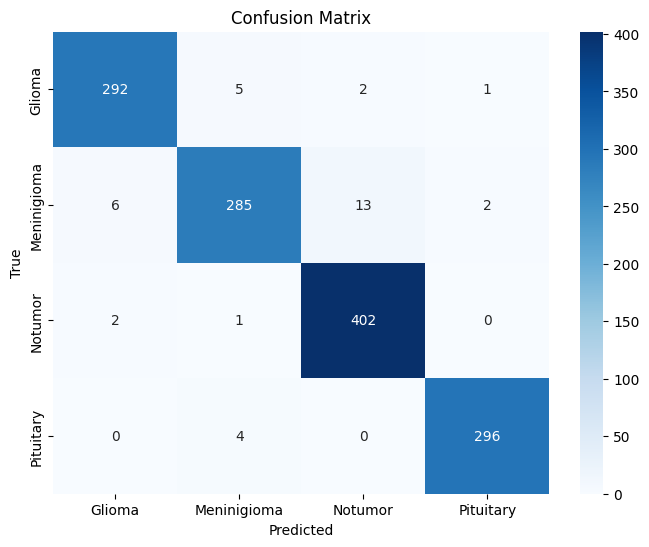

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()